This code
1. Loads the cancer dataset, available at: https://hastie.su.domains/ElemStatLearn/datasets/prostate.data
2. Standardizes the training data (not the targets)
3. Transforms the testing data in the same manner by using the means and standard deviations of the training data
4. Performs Ordinary Least Squares on training data
5. Starts applying an L2 penalty
6. Gets the lowest test error over all lambda
7. Plots the coefficient paths

In [1]:
import torch
torch.manual_seed(0)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data =  pd.read_csv('prostate.data', sep="	")

n=97 observations, 67 training, 30 test
p=8 predictors
y = lpsa (response) 96 * 1 
X = 96 * 8
beta = 8 * 1 (coefficients)
y = X * beta

Data needs to be split. Normalize and standardize (columns) using the training data only, extend the stored parameters to normalize and standardize the test data too

In [2]:
# Convert data to doubles
data_cols = ['age', 'gleason', 'lbph', 'lcavol', 'lcp','lweight', 'pgg45', 'svi']
data[data_cols] = data[data_cols].astype('double', copy=True, errors='raise')

grouped = data.groupby(data.train)
pan_train_data = grouped.get_group("T")
pan_test_data = grouped.get_group("F")


# The data needs to be normalized (normalize columns of X)
means = pan_train_data[data_cols].mean()
variances = pan_train_data[data_cols].std(ddof=0)

pan_train_data[data_cols] = (pan_train_data[data_cols]-means)/variances
pan_test_data[data_cols] = (pan_test_data[data_cols]-means)/variances



/var/folders/y3/t7nmdh795s52pz2bygv2tzj00000gn/T/ipykernel_24378/549593570.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pan_train_data[data_cols] = (pan_train_data[data_cols]-means)/variances
/var/folders/y3/t7nmdh795s52pz2bygv2tzj00000gn/T/ipykernel_24378/549593570.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pan_test_data[data_cols] = (pan_test_data[data_cols]-means)/variances


In [3]:
X_train = pan_train_data[['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']]
y_train = pan_train_data[['lpsa']]

X_test = pan_test_data[['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']]
y_test = pan_test_data[['lpsa']]


In [4]:
train_data = []
for i in range(len(X_train)):
    train_data.append([X_train.iloc[i].to_numpy(),y_train.iloc[i].to_numpy()])

test_data = []
for i in range(len(X_test)):
    test_data.append([X_test.iloc[i].to_numpy(),y_test.iloc[i].to_numpy()])
    


In [5]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

Now we can define the linear model we want to train (without bias)

In [6]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize,bias=False)

    def forward(self, x):
        out = self.linear(x)
        return out

inputDim = len(train_data[0][0])        # takes variable 'x' 
outputDim = len(train_data[0][1])       # takes variable 'y'
learningRate = 0.1 
epochs = 500

model = linearRegression(inputDim, outputDim)
model = model.double()

train_loss = []
test_loss = []

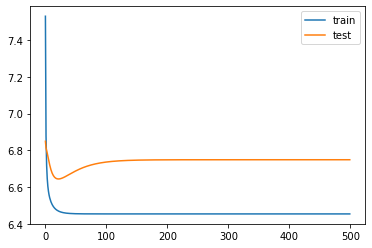

In [7]:
inputDim = len(train_data[0][0])        # takes variable 'x' 
outputDim = len(train_data[0][1])       # takes variable 'y'
learningRate = 0.1 
epochs = 500

model = linearRegression(inputDim, outputDim)
model = model.double()

train_loss = []
test_loss = []

loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

def train_loop(train_loader, model, loss_fn, optimizer, train_loss):
    size = len(train_loader.dataset)
    for batch, (X,y) in enumerate(train_loader):
        pred = model(X)
        loss = loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss = loss.item()
    train_loss.append(loss)

            
def test_loop(train_loader, model, loss_fn, test_loss):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    t_loss = 0
    
    with torch.no_grad():
        for X,y in test_loader:
            pred = model(X)
            t_loss += loss_fn(pred,y).item()
    
    t_loss /= num_batches
    test_loss.append([t_loss])



for t in range(epochs):
    train_loop(train_loader, model, loss_fn, optimizer,train_loss)
    test_loop(test_loader, model, loss_fn, test_loss)


plt.plot([x for x in range(len(train_loss))],train_loss,label='train')
plt.plot([x for x in range(len(test_loss))],test_loss,label='test')
plt.legend()


train_loss = []
test_loss = []

In [8]:
def train_loop(train_loader, model, loss_fn, optimizer, train_loss, l1_lambda, l2_lambda):
    size = len(train_loader.dataset)
    for batch, (X,y) in enumerate(train_loader):
        pred = model(X)
        loss = loss_fn(pred,y)
        
        training_error = loss.item()
        
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        l1_norm = sum(p.abs().sum() for p in model.parameters())

 
        loss = loss + l2_lambda * l2_norm + l1_lambda * l1_norm
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss = training_error
    print(f"Training loss: {loss:>7f}")
    train_loss.append(loss)

            
def test_loop(train_loader, model, loss_fn, test_loss):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    t_loss = 0
    
    with torch.no_grad():
        for X,y in test_loader:
            pred = model(X)
            t_loss += loss_fn(pred,y).item()
    
    t_loss /= num_batches
    print(f"Test loss: {t_loss:>8f}\n")
    test_loss.append([t_loss])



In [9]:
epochs = 100
learningRate = 0.005
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)


interval_start = -5
interval_end = 2


l1_lambda = 0

l2_intervals = 500

train_path = []
test_path = []
weight_path = []


for l2_index, l2_lambda in enumerate(np.logspace(interval_start, interval_end, num=l2_intervals)):
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model, loss_fn, optimizer,train_loss, l1_lambda, l2_lambda)
        test_loop(test_loader, model, loss_fn, test_loss)
    print(f"Done with {np.log10(l2_lambda)}\n")
    train_path.append(train_loss[-1])
    test_path.append(test_loss[-1])
    weight_path.append(np.array([param for param in model.parameters()][0][0].detach()))

print('Done!')

Epoch 1
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 2
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 3
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 4
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 5
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 6
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 7
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 12
-------------------------------
Training loss: 6.45319

Test loss: 6.748631

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 12
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 17
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 18
-------------------------------
Training loss: 6.453196
Test loss: 6.748631

Epoch 19
--------------------------

Training loss: 6.453196
Test loss: 6.748630

Epoch 76
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 77
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 78
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 79
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 80
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 81
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 82
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 83
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 84
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 85
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 86
-------------------------------
Training loss: 6.453196
Test loss: 6.748630

Epoch 87


Test loss: 6.748626

Epoch 68
-------------------------------
Training loss: 6.453196
Test loss: 6.748626

Epoch 69
-------------------------------
Training loss: 6.453196
Test loss: 6.748626

Epoch 70
-------------------------------
Training loss: 6.453196
Test loss: 6.748626

Epoch 71
-------------------------------
Training loss: 6.453196
Test loss: 6.748626

Epoch 72
-------------------------------
Training loss: 6.453196
Test loss: 6.748626

Epoch 73
-------------------------------
Training loss: 6.453196
Test loss: 6.748626

Epoch 74
-------------------------------
Training loss: 6.453196
Test loss: 6.748626

Epoch 75
-------------------------------
Training loss: 6.453196
Test loss: 6.748626

Epoch 76
-------------------------------
Training loss: 6.453196
Test loss: 6.748626

Epoch 77
-------------------------------
Training loss: 6.453196
Test loss: 6.748626

Epoch 78
-------------------------------
Training loss: 6.453196
Test loss: 6.748626

Epoch 79
------------------------

Training loss: 6.453196
Test loss: 6.748624

Epoch 95
-------------------------------
Training loss: 6.453196
Test loss: 6.748624

Epoch 96
-------------------------------
Training loss: 6.453196
Test loss: 6.748624

Epoch 97
-------------------------------
Training loss: 6.453196
Test loss: 6.748624

Epoch 98
-------------------------------
Training loss: 6.453196
Test loss: 6.748624

Epoch 99
-------------------------------
Training loss: 6.453196
Test loss: 6.748624

Epoch 100
-------------------------------
Training loss: 6.453196
Test loss: 6.748624

Done with -4.929859719438878

Epoch 1
-------------------------------
Training loss: 6.453196
Test loss: 6.748624

Epoch 2
-------------------------------
Training loss: 6.453196
Test loss: 6.748624

Epoch 3
-------------------------------
Training loss: 6.453196
Test loss: 6.748624

Epoch 4
-------------------------------
Training loss: 6.453196
Test loss: 6.748624

Epoch 5
-------------------------------
Training loss: 6.453196
Test

Test loss: 6.748622

Epoch 18
-------------------------------
Training loss: 6.453196
Test loss: 6.748622

Epoch 19
-------------------------------
Training loss: 6.453196
Test loss: 6.748622

Epoch 20
-------------------------------
Training loss: 6.453196
Test loss: 6.748622

Epoch 21
-------------------------------
Training loss: 6.453196
Test loss: 6.748622

Epoch 22
-------------------------------
Training loss: 6.453196
Test loss: 6.748622

Epoch 23
-------------------------------
Training loss: 6.453196
Test loss: 6.748622

Epoch 24
-------------------------------
Training loss: 6.453196
Test loss: 6.748622

Epoch 25
-------------------------------
Training loss: 6.453196
Test loss: 6.748622

Epoch 26
-------------------------------
Training loss: 6.453196
Test loss: 6.748622

Epoch 27
-------------------------------
Training loss: 6.453196
Test loss: 6.748622

Epoch 28
-------------------------------
Training loss: 6.453196
Test loss: 6.748622

Epoch 29
------------------------

Test loss: 6.748620

Epoch 48
-------------------------------
Training loss: 6.453196
Test loss: 6.748620

Epoch 49
-------------------------------
Training loss: 6.453196
Test loss: 6.748620

Epoch 50
-------------------------------
Training loss: 6.453196
Test loss: 6.748620

Epoch 51
-------------------------------
Training loss: 6.453196
Test loss: 6.748620

Epoch 52
-------------------------------
Training loss: 6.453196
Test loss: 6.748620

Epoch 53
-------------------------------
Training loss: 6.453196
Test loss: 6.748620

Epoch 54
-------------------------------
Training loss: 6.453196
Test loss: 6.748620

Epoch 55
-------------------------------
Training loss: 6.453196
Test loss: 6.748620

Epoch 56
-------------------------------
Training loss: 6.453196
Test loss: 6.748620

Epoch 57
-------------------------------
Training loss: 6.453196
Test loss: 6.748620

Epoch 58
-------------------------------
Training loss: 6.453196
Test loss: 6.748620

Epoch 59
------------------------

Test loss: 6.748618

Epoch 73
-------------------------------
Training loss: 6.453196
Test loss: 6.748618

Epoch 74
-------------------------------
Training loss: 6.453196
Test loss: 6.748618

Epoch 75
-------------------------------
Training loss: 6.453196
Test loss: 6.748618

Epoch 76
-------------------------------
Training loss: 6.453196
Test loss: 6.748618

Epoch 77
-------------------------------
Training loss: 6.453196
Test loss: 6.748618

Epoch 78
-------------------------------
Training loss: 6.453196
Test loss: 6.748618

Epoch 79
-------------------------------
Training loss: 6.453196
Test loss: 6.748618

Epoch 80
-------------------------------
Training loss: 6.453196
Test loss: 6.748618

Epoch 81
-------------------------------
Training loss: 6.453196
Test loss: 6.748618

Epoch 82
-------------------------------
Training loss: 6.453196
Test loss: 6.748618

Epoch 83
-------------------------------
Training loss: 6.453196
Test loss: 6.748618

Epoch 84
------------------------

Training loss: 6.453196
Test loss: 6.748616

Epoch 6
-------------------------------
Training loss: 6.453196
Test loss: 6.748616

Epoch 7
-------------------------------
Training loss: 6.453196
Test loss: 6.748616

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748616

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748616

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748616

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748616

Epoch 12
-------------------------------
Training loss: 6.453196
Test loss: 6.748616

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748616

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748616

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748616

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748616

Epoch 17
----

Training loss: 6.453196
Test loss: 6.748615

Epoch 34
-------------------------------
Training loss: 6.453196
Test loss: 6.748615

Epoch 35
-------------------------------
Training loss: 6.453196
Test loss: 6.748615

Epoch 36
-------------------------------
Training loss: 6.453196
Test loss: 6.748615

Epoch 37
-------------------------------
Training loss: 6.453196
Test loss: 6.748615

Epoch 38
-------------------------------
Training loss: 6.453196
Test loss: 6.748615

Epoch 39
-------------------------------
Training loss: 6.453196
Test loss: 6.748615

Epoch 40
-------------------------------
Training loss: 6.453196
Test loss: 6.748615

Epoch 41
-------------------------------
Training loss: 6.453196
Test loss: 6.748615

Epoch 42
-------------------------------
Training loss: 6.453196
Test loss: 6.748615

Epoch 43
-------------------------------
Training loss: 6.453196
Test loss: 6.748615

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748615

Epoch 45


Test loss: 6.748614

Epoch 64
-------------------------------
Training loss: 6.453196
Test loss: 6.748614

Epoch 65
-------------------------------
Training loss: 6.453196
Test loss: 6.748614

Epoch 66
-------------------------------
Training loss: 6.453196
Test loss: 6.748614

Epoch 67
-------------------------------
Training loss: 6.453196
Test loss: 6.748614

Epoch 68
-------------------------------
Training loss: 6.453196
Test loss: 6.748613

Epoch 69
-------------------------------
Training loss: 6.453196
Test loss: 6.748613

Epoch 70
-------------------------------
Training loss: 6.453196
Test loss: 6.748613

Epoch 71
-------------------------------
Training loss: 6.453196
Test loss: 6.748613

Epoch 72
-------------------------------
Training loss: 6.453196
Test loss: 6.748613

Epoch 73
-------------------------------
Training loss: 6.453196
Test loss: 6.748613

Epoch 74
-------------------------------
Training loss: 6.453196
Test loss: 6.748613

Epoch 75
------------------------

Test loss: 6.748612

Epoch 88
-------------------------------
Training loss: 6.453196
Test loss: 6.748612

Epoch 89
-------------------------------
Training loss: 6.453196
Test loss: 6.748612

Epoch 90
-------------------------------
Training loss: 6.453196
Test loss: 6.748612

Epoch 91
-------------------------------
Training loss: 6.453196
Test loss: 6.748612

Epoch 92
-------------------------------
Training loss: 6.453196
Test loss: 6.748612

Epoch 93
-------------------------------
Training loss: 6.453196
Test loss: 6.748612

Epoch 94
-------------------------------
Training loss: 6.453196
Test loss: 6.748612

Epoch 95
-------------------------------
Training loss: 6.453196
Test loss: 6.748612

Epoch 96
-------------------------------
Training loss: 6.453196
Test loss: 6.748612

Epoch 97
-------------------------------
Training loss: 6.453196
Test loss: 6.748612

Epoch 98
-------------------------------
Training loss: 6.453196
Test loss: 6.748612

Epoch 99
------------------------

Training loss: 6.453196
Test loss: 6.748611

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748611

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748611

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748611

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748611

Epoch 17
-------------------------------
Training loss: 6.453196
Test loss: 6.748611

Epoch 18
-------------------------------
Training loss: 6.453196
Test loss: 6.748611

Epoch 19
-------------------------------
Training loss: 6.453196
Test loss: 6.748611

Epoch 20
-------------------------------
Training loss: 6.453196
Test loss: 6.748611

Epoch 21
-------------------------------
Training loss: 6.453196
Test loss: 6.748611

Epoch 22
-------------------------------
Training loss: 6.453196
Test loss: 6.748611

Epoch 23
-------------------------------
Training loss: 6.453196
Test loss: 6.748611

Epoch 24


Training loss: 6.453196
Test loss: 6.748610

Epoch 39
-------------------------------
Training loss: 6.453196
Test loss: 6.748610

Epoch 40
-------------------------------
Training loss: 6.453196
Test loss: 6.748610

Epoch 41
-------------------------------
Training loss: 6.453196
Test loss: 6.748610

Epoch 42
-------------------------------
Training loss: 6.453196
Test loss: 6.748610

Epoch 43
-------------------------------
Training loss: 6.453196
Test loss: 6.748610

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748610

Epoch 45
-------------------------------
Training loss: 6.453196
Test loss: 6.748610

Epoch 46
-------------------------------
Training loss: 6.453196
Test loss: 6.748610

Epoch 47
-------------------------------
Training loss: 6.453196
Test loss: 6.748610

Epoch 48
-------------------------------
Training loss: 6.453196
Test loss: 6.748610

Epoch 49
-------------------------------
Training loss: 6.453196
Test loss: 6.748610

Epoch 50


Training loss: 6.453196
Test loss: 6.748609

Epoch 71
-------------------------------
Training loss: 6.453196
Test loss: 6.748609

Epoch 72
-------------------------------
Training loss: 6.453196
Test loss: 6.748609

Epoch 73
-------------------------------
Training loss: 6.453196
Test loss: 6.748609

Epoch 74
-------------------------------
Training loss: 6.453196
Test loss: 6.748609

Epoch 75
-------------------------------
Training loss: 6.453196
Test loss: 6.748609

Epoch 76
-------------------------------
Training loss: 6.453196
Test loss: 6.748609

Epoch 77
-------------------------------
Training loss: 6.453196
Test loss: 6.748609

Epoch 78
-------------------------------
Training loss: 6.453196
Test loss: 6.748609

Epoch 79
-------------------------------
Training loss: 6.453196
Test loss: 6.748609

Epoch 80
-------------------------------
Training loss: 6.453196
Test loss: 6.748608

Epoch 81
-------------------------------
Training loss: 6.453196
Test loss: 6.748608

Epoch 82


Test loss: 6.748607

Epoch 7
-------------------------------
Training loss: 6.453196
Test loss: 6.748607

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748607

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748607

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748607

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748607

Epoch 12
-------------------------------
Training loss: 6.453196
Test loss: 6.748607

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748607

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748607

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748607

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748607

Epoch 17
-------------------------------
Training loss: 6.453196
Test loss: 6.748607

Epoch 18
---------------------------

Training loss: 6.453196
Test loss: 6.748606

Epoch 35
-------------------------------
Training loss: 6.453196
Test loss: 6.748606

Epoch 36
-------------------------------
Training loss: 6.453196
Test loss: 6.748606

Epoch 37
-------------------------------
Training loss: 6.453196
Test loss: 6.748606

Epoch 38
-------------------------------
Training loss: 6.453196
Test loss: 6.748606

Epoch 39
-------------------------------
Training loss: 6.453196
Test loss: 6.748606

Epoch 40
-------------------------------
Training loss: 6.453196
Test loss: 6.748606

Epoch 41
-------------------------------
Training loss: 6.453196
Test loss: 6.748606

Epoch 42
-------------------------------
Training loss: 6.453196
Test loss: 6.748606

Epoch 43
-------------------------------
Training loss: 6.453196
Test loss: 6.748606

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748606

Epoch 45
-------------------------------
Training loss: 6.453196
Test loss: 6.748606

Epoch 46


Test loss: 6.748605

Epoch 68
-------------------------------
Training loss: 6.453196
Test loss: 6.748605

Epoch 69
-------------------------------
Training loss: 6.453196
Test loss: 6.748605

Epoch 70
-------------------------------
Training loss: 6.453196
Test loss: 6.748605

Epoch 71
-------------------------------
Training loss: 6.453196
Test loss: 6.748605

Epoch 72
-------------------------------
Training loss: 6.453196
Test loss: 6.748605

Epoch 73
-------------------------------
Training loss: 6.453196
Test loss: 6.748605

Epoch 74
-------------------------------
Training loss: 6.453196
Test loss: 6.748605

Epoch 75
-------------------------------
Training loss: 6.453196
Test loss: 6.748605

Epoch 76
-------------------------------
Training loss: 6.453196
Test loss: 6.748605

Epoch 77
-------------------------------
Training loss: 6.453196
Test loss: 6.748605

Epoch 78
-------------------------------
Training loss: 6.453196
Test loss: 6.748605

Epoch 79
------------------------

Training loss: 6.453196
Test loss: 6.748604

Epoch 5
-------------------------------
Training loss: 6.453196
Test loss: 6.748604

Epoch 6
-------------------------------
Training loss: 6.453196
Test loss: 6.748604

Epoch 7
-------------------------------
Training loss: 6.453196
Test loss: 6.748604

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748604

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748604

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748604

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748604

Epoch 12
-------------------------------
Training loss: 6.453196
Test loss: 6.748604

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748604

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748604

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748604

Epoch 16
-----

Training loss: 6.453196
Test loss: 6.748602

Epoch 41
-------------------------------
Training loss: 6.453196
Test loss: 6.748602

Epoch 42
-------------------------------
Training loss: 6.453196
Test loss: 6.748602

Epoch 43
-------------------------------
Training loss: 6.453196
Test loss: 6.748602

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748602

Epoch 45
-------------------------------
Training loss: 6.453196
Test loss: 6.748602

Epoch 46
-------------------------------
Training loss: 6.453196
Test loss: 6.748602

Epoch 47
-------------------------------
Training loss: 6.453196
Test loss: 6.748602

Epoch 48
-------------------------------
Training loss: 6.453196
Test loss: 6.748602

Epoch 49
-------------------------------
Training loss: 6.453196
Test loss: 6.748602

Epoch 50
-------------------------------
Training loss: 6.453196
Test loss: 6.748602

Epoch 51
-------------------------------
Training loss: 6.453196
Test loss: 6.748602

Epoch 52


Training loss: 6.453196
Test loss: 6.748601

Epoch 79
-------------------------------
Training loss: 6.453196
Test loss: 6.748601

Epoch 80
-------------------------------
Training loss: 6.453196
Test loss: 6.748601

Epoch 81
-------------------------------
Training loss: 6.453196
Test loss: 6.748601

Epoch 82
-------------------------------
Training loss: 6.453196
Test loss: 6.748601

Epoch 83
-------------------------------
Training loss: 6.453196
Test loss: 6.748601

Epoch 84
-------------------------------
Training loss: 6.453196
Test loss: 6.748601

Epoch 85
-------------------------------
Training loss: 6.453196
Test loss: 6.748601

Epoch 86
-------------------------------
Training loss: 6.453196
Test loss: 6.748601

Epoch 87
-------------------------------
Training loss: 6.453196
Test loss: 6.748601

Epoch 88
-------------------------------
Training loss: 6.453196
Test loss: 6.748601

Epoch 89
-------------------------------
Training loss: 6.453196
Test loss: 6.748601

Epoch 90


Training loss: 6.453196
Test loss: 6.748600

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748600

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748600

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748600

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748600

Epoch 12
-------------------------------
Training loss: 6.453196
Test loss: 6.748600

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748600

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748600

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748600

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748600

Epoch 17
-------------------------------
Training loss: 6.453196
Test loss: 6.748600

Epoch 18
-------------------------------
Training loss: 6.453196
Test loss: 6.748600

Epoch 19
--

Training loss: 6.453196
Test loss: 6.748599

Epoch 21
-------------------------------
Training loss: 6.453196
Test loss: 6.748599

Epoch 22
-------------------------------
Training loss: 6.453196
Test loss: 6.748599

Epoch 23
-------------------------------
Training loss: 6.453196
Test loss: 6.748598

Epoch 24
-------------------------------
Training loss: 6.453196
Test loss: 6.748598

Epoch 25
-------------------------------
Training loss: 6.453196
Test loss: 6.748598

Epoch 26
-------------------------------
Training loss: 6.453196
Test loss: 6.748598

Epoch 27
-------------------------------
Training loss: 6.453196
Test loss: 6.748598

Epoch 28
-------------------------------
Training loss: 6.453196
Test loss: 6.748598

Epoch 29
-------------------------------
Training loss: 6.453196
Test loss: 6.748598

Epoch 30
-------------------------------
Training loss: 6.453196
Test loss: 6.748598

Epoch 31
-------------------------------
Training loss: 6.453196
Test loss: 6.748598

Epoch 32


Test loss: 6.748597

Epoch 32
-------------------------------
Training loss: 6.453196
Test loss: 6.748597

Epoch 33
-------------------------------
Training loss: 6.453196
Test loss: 6.748597

Epoch 34
-------------------------------
Training loss: 6.453196
Test loss: 6.748597

Epoch 35
-------------------------------
Training loss: 6.453196
Test loss: 6.748597

Epoch 36
-------------------------------
Training loss: 6.453196
Test loss: 6.748597

Epoch 37
-------------------------------
Training loss: 6.453196
Test loss: 6.748597

Epoch 38
-------------------------------
Training loss: 6.453196
Test loss: 6.748597

Epoch 39
-------------------------------
Training loss: 6.453196
Test loss: 6.748597

Epoch 40
-------------------------------
Training loss: 6.453196
Test loss: 6.748597

Epoch 41
-------------------------------
Training loss: 6.453196
Test loss: 6.748597

Epoch 42
-------------------------------
Training loss: 6.453196
Test loss: 6.748597

Epoch 43
------------------------

Training loss: 6.453196
Test loss: 6.748596

Epoch 56
-------------------------------
Training loss: 6.453196
Test loss: 6.748596

Epoch 57
-------------------------------
Training loss: 6.453196
Test loss: 6.748596

Epoch 58
-------------------------------
Training loss: 6.453196
Test loss: 6.748596

Epoch 59
-------------------------------
Training loss: 6.453196
Test loss: 6.748596

Epoch 60
-------------------------------
Training loss: 6.453196
Test loss: 6.748596

Epoch 61
-------------------------------
Training loss: 6.453196
Test loss: 6.748596

Epoch 62
-------------------------------
Training loss: 6.453196
Test loss: 6.748596

Epoch 63
-------------------------------
Training loss: 6.453196
Test loss: 6.748596

Epoch 64
-------------------------------
Training loss: 6.453196
Test loss: 6.748596

Epoch 65
-------------------------------
Training loss: 6.453196
Test loss: 6.748596

Epoch 66
-------------------------------
Training loss: 6.453196
Test loss: 6.748596

Epoch 67


Test loss: 6.748594

Epoch 93
-------------------------------
Training loss: 6.453196
Test loss: 6.748594

Epoch 94
-------------------------------
Training loss: 6.453196
Test loss: 6.748594

Epoch 95
-------------------------------
Training loss: 6.453196
Test loss: 6.748594

Epoch 96
-------------------------------
Training loss: 6.453196
Test loss: 6.748594

Epoch 97
-------------------------------
Training loss: 6.453196
Test loss: 6.748594

Epoch 98
-------------------------------
Training loss: 6.453196
Test loss: 6.748594

Epoch 99
-------------------------------
Training loss: 6.453196
Test loss: 6.748594

Epoch 100
-------------------------------
Training loss: 6.453196
Test loss: 6.748594

Done with -4.551102204408817

Epoch 1
-------------------------------
Training loss: 6.453196
Test loss: 6.748594

Epoch 2
-------------------------------
Training loss: 6.453196
Test loss: 6.748594

Epoch 3
-------------------------------
Training loss: 6.453196
Test loss: 6.748594

Epoch

Training loss: 6.453196
Test loss: 6.748593

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748593

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748593

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748593

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748593

Epoch 12
-------------------------------
Training loss: 6.453196
Test loss: 6.748593

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748593

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748593

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748593

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748593

Epoch 17
-------------------------------
Training loss: 6.453196
Test loss: 6.748593

Epoch 18
-------------------------------
Training loss: 6.453196
Test loss: 6.748593

Epoch 19
--

Epoch 24
-------------------------------
Training loss: 6.453196
Test loss: 6.748592

Epoch 25
-------------------------------
Training loss: 6.453196
Test loss: 6.748592

Epoch 26
-------------------------------
Training loss: 6.453196
Test loss: 6.748592

Epoch 27
-------------------------------
Training loss: 6.453196
Test loss: 6.748592

Epoch 28
-------------------------------
Training loss: 6.453196
Test loss: 6.748592

Epoch 29
-------------------------------
Training loss: 6.453196
Test loss: 6.748592

Epoch 30
-------------------------------
Training loss: 6.453196
Test loss: 6.748592

Epoch 31
-------------------------------
Training loss: 6.453196
Test loss: 6.748592

Epoch 32
-------------------------------
Training loss: 6.453196
Test loss: 6.748591

Epoch 33
-------------------------------
Training loss: 6.453196
Test loss: 6.748591

Epoch 34
-------------------------------
Training loss: 6.453196
Test loss: 6.748591

Epoch 35
-------------------------------
Training loss

Training loss: 6.453196
Test loss: 6.748590

Epoch 54
-------------------------------
Training loss: 6.453196
Test loss: 6.748590

Epoch 55
-------------------------------
Training loss: 6.453196
Test loss: 6.748590

Epoch 56
-------------------------------
Training loss: 6.453196
Test loss: 6.748590

Epoch 57
-------------------------------
Training loss: 6.453196
Test loss: 6.748590

Epoch 58
-------------------------------
Training loss: 6.453196
Test loss: 6.748590

Epoch 59
-------------------------------
Training loss: 6.453196
Test loss: 6.748590

Epoch 60
-------------------------------
Training loss: 6.453196
Test loss: 6.748590

Epoch 61
-------------------------------
Training loss: 6.453196
Test loss: 6.748590

Epoch 62
-------------------------------
Training loss: 6.453196
Test loss: 6.748590

Epoch 63
-------------------------------
Training loss: 6.453196
Test loss: 6.748590

Epoch 64
-------------------------------
Training loss: 6.453196
Test loss: 6.748590

Epoch 65


Test loss: 6.748589

Epoch 59
-------------------------------
Training loss: 6.453196
Test loss: 6.748589

Epoch 60
-------------------------------
Training loss: 6.453196
Test loss: 6.748589

Epoch 61
-------------------------------
Training loss: 6.453196
Test loss: 6.748589

Epoch 62
-------------------------------
Training loss: 6.453196
Test loss: 6.748589

Epoch 63
-------------------------------
Training loss: 6.453196
Test loss: 6.748588

Epoch 64
-------------------------------
Training loss: 6.453196
Test loss: 6.748588

Epoch 65
-------------------------------
Training loss: 6.453196
Test loss: 6.748588

Epoch 66
-------------------------------
Training loss: 6.453196
Test loss: 6.748588

Epoch 67
-------------------------------
Training loss: 6.453196
Test loss: 6.748588

Epoch 68
-------------------------------
Training loss: 6.453196
Test loss: 6.748588

Epoch 69
-------------------------------
Training loss: 6.453196
Test loss: 6.748588

Epoch 70
------------------------

Training loss: 6.453196
Test loss: 6.748586

Epoch 42
-------------------------------
Training loss: 6.453196
Test loss: 6.748586

Epoch 43
-------------------------------
Training loss: 6.453196
Test loss: 6.748586

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748586

Epoch 45
-------------------------------
Training loss: 6.453196
Test loss: 6.748586

Epoch 46
-------------------------------
Training loss: 6.453196
Test loss: 6.748586

Epoch 47
-------------------------------
Training loss: 6.453196
Test loss: 6.748586

Epoch 48
-------------------------------
Training loss: 6.453196
Test loss: 6.748586

Epoch 49
-------------------------------
Training loss: 6.453196
Test loss: 6.748586

Epoch 50
-------------------------------
Training loss: 6.453196
Test loss: 6.748586

Epoch 51
-------------------------------
Training loss: 6.453196
Test loss: 6.748586

Epoch 52
-------------------------------
Training loss: 6.453196
Test loss: 6.748586

Epoch 53


Test loss: 6.748584

Epoch 72
-------------------------------
Training loss: 6.453196
Test loss: 6.748584

Epoch 73
-------------------------------
Training loss: 6.453196
Test loss: 6.748584

Epoch 74
-------------------------------
Training loss: 6.453196
Test loss: 6.748584

Epoch 75
-------------------------------
Training loss: 6.453196
Test loss: 6.748584

Epoch 76
-------------------------------
Training loss: 6.453196
Test loss: 6.748584

Epoch 77
-------------------------------
Training loss: 6.453196
Test loss: 6.748584

Epoch 78
-------------------------------
Training loss: 6.453196
Test loss: 6.748584

Epoch 79
-------------------------------
Training loss: 6.453196
Test loss: 6.748584

Epoch 80
-------------------------------
Training loss: 6.453196
Test loss: 6.748584

Epoch 81
-------------------------------
Training loss: 6.453196
Test loss: 6.748584

Epoch 82
-------------------------------
Training loss: 6.453196
Test loss: 6.748584

Epoch 83
------------------------

Training loss: 6.453196
Test loss: 6.748582

Epoch 88
-------------------------------
Training loss: 6.453196
Test loss: 6.748582

Epoch 89
-------------------------------
Training loss: 6.453196
Test loss: 6.748582

Epoch 90
-------------------------------
Training loss: 6.453196
Test loss: 6.748582

Epoch 91
-------------------------------
Training loss: 6.453196
Test loss: 6.748582

Epoch 92
-------------------------------
Training loss: 6.453196
Test loss: 6.748582

Epoch 93
-------------------------------
Training loss: 6.453196
Test loss: 6.748582

Epoch 94
-------------------------------
Training loss: 6.453196
Test loss: 6.748582

Epoch 95
-------------------------------
Training loss: 6.453196
Test loss: 6.748582

Epoch 96
-------------------------------
Training loss: 6.453196
Test loss: 6.748582

Epoch 97
-------------------------------
Training loss: 6.453196
Test loss: 6.748582

Epoch 98
-------------------------------
Training loss: 6.453196
Test loss: 6.748582

Epoch 99


Training loss: 6.453196
Test loss: 6.748581

Epoch 90
-------------------------------
Training loss: 6.453196
Test loss: 6.748581

Epoch 91
-------------------------------
Training loss: 6.453196
Test loss: 6.748581

Epoch 92
-------------------------------
Training loss: 6.453196
Test loss: 6.748581

Epoch 93
-------------------------------
Training loss: 6.453196
Test loss: 6.748581

Epoch 94
-------------------------------
Training loss: 6.453196
Test loss: 6.748581

Epoch 95
-------------------------------
Training loss: 6.453196
Test loss: 6.748581

Epoch 96
-------------------------------
Training loss: 6.453196
Test loss: 6.748581

Epoch 97
-------------------------------
Training loss: 6.453196
Test loss: 6.748581

Epoch 98
-------------------------------
Training loss: 6.453196
Test loss: 6.748581

Epoch 99
-------------------------------
Training loss: 6.453196
Test loss: 6.748581

Epoch 100
-------------------------------
Training loss: 6.453196
Test loss: 6.748581

Done wit

Training loss: 6.453196
Test loss: 6.748579

Epoch 6
-------------------------------
Training loss: 6.453196
Test loss: 6.748579

Epoch 7
-------------------------------
Training loss: 6.453196
Test loss: 6.748579

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748579

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748579

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748579

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748579

Epoch 12
-------------------------------
Training loss: 6.453196
Test loss: 6.748579

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748579

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748579

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748579

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748579

Epoch 17
----

Training loss: 6.453196
Test loss: 6.748577

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748577

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748577

Epoch 17
-------------------------------
Training loss: 6.453196
Test loss: 6.748577

Epoch 18
-------------------------------
Training loss: 6.453196
Test loss: 6.748577

Epoch 19
-------------------------------
Training loss: 6.453196
Test loss: 6.748577

Epoch 20
-------------------------------
Training loss: 6.453196
Test loss: 6.748577

Epoch 21
-------------------------------
Training loss: 6.453196
Test loss: 6.748577

Epoch 22
-------------------------------
Training loss: 6.453196
Test loss: 6.748577

Epoch 23
-------------------------------
Training loss: 6.453196
Test loss: 6.748577

Epoch 24
-------------------------------
Training loss: 6.453196
Test loss: 6.748577

Epoch 25
-------------------------------
Training loss: 6.453196
Test loss: 6.748577

Epoch 26


Test loss: 6.748575

Epoch 28
-------------------------------
Training loss: 6.453196
Test loss: 6.748575

Epoch 29
-------------------------------
Training loss: 6.453196
Test loss: 6.748575

Epoch 30
-------------------------------
Training loss: 6.453196
Test loss: 6.748575

Epoch 31
-------------------------------
Training loss: 6.453196
Test loss: 6.748575

Epoch 32
-------------------------------
Training loss: 6.453196
Test loss: 6.748575

Epoch 33
-------------------------------
Training loss: 6.453196
Test loss: 6.748575

Epoch 34
-------------------------------
Training loss: 6.453196
Test loss: 6.748575

Epoch 35
-------------------------------
Training loss: 6.453196
Test loss: 6.748575

Epoch 36
-------------------------------
Training loss: 6.453196
Test loss: 6.748575

Epoch 37
-------------------------------
Training loss: 6.453196
Test loss: 6.748575

Epoch 38
-------------------------------
Training loss: 6.453196
Test loss: 6.748575

Epoch 39
------------------------

Training loss: 6.453196
Test loss: 6.748573

Epoch 39
-------------------------------
Training loss: 6.453196
Test loss: 6.748573

Epoch 40
-------------------------------
Training loss: 6.453196
Test loss: 6.748573

Epoch 41
-------------------------------
Training loss: 6.453196
Test loss: 6.748573

Epoch 42
-------------------------------
Training loss: 6.453196
Test loss: 6.748573

Epoch 43
-------------------------------
Training loss: 6.453196
Test loss: 6.748573

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748573

Epoch 45
-------------------------------
Training loss: 6.453196
Test loss: 6.748573

Epoch 46
-------------------------------
Training loss: 6.453196
Test loss: 6.748573

Epoch 47
-------------------------------
Training loss: 6.453196
Test loss: 6.748573

Epoch 48
-------------------------------
Training loss: 6.453196
Test loss: 6.748573

Epoch 49
-------------------------------
Training loss: 6.453196
Test loss: 6.748573

Epoch 50


Training loss: 6.453196
Test loss: 6.748571

Epoch 37
-------------------------------
Training loss: 6.453196
Test loss: 6.748571

Epoch 38
-------------------------------
Training loss: 6.453196
Test loss: 6.748571

Epoch 39
-------------------------------
Training loss: 6.453196
Test loss: 6.748571

Epoch 40
-------------------------------
Training loss: 6.453196
Test loss: 6.748571

Epoch 41
-------------------------------
Training loss: 6.453196
Test loss: 6.748571

Epoch 42
-------------------------------
Training loss: 6.453196
Test loss: 6.748571

Epoch 43
-------------------------------
Training loss: 6.453196
Test loss: 6.748571

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748571

Epoch 45
-------------------------------
Training loss: 6.453196
Test loss: 6.748571

Epoch 46
-------------------------------
Training loss: 6.453196
Test loss: 6.748571

Epoch 47
-------------------------------
Training loss: 6.453196
Test loss: 6.748571

Epoch 48


Test loss: 6.748569

Epoch 50
-------------------------------
Training loss: 6.453196
Test loss: 6.748569

Epoch 51
-------------------------------
Training loss: 6.453196
Test loss: 6.748569

Epoch 52
-------------------------------
Training loss: 6.453196
Test loss: 6.748569

Epoch 53
-------------------------------
Training loss: 6.453196
Test loss: 6.748569

Epoch 54
-------------------------------
Training loss: 6.453196
Test loss: 6.748569

Epoch 55
-------------------------------
Training loss: 6.453196
Test loss: 6.748569

Epoch 56
-------------------------------
Training loss: 6.453196
Test loss: 6.748569

Epoch 57
-------------------------------
Training loss: 6.453196
Test loss: 6.748569

Epoch 58
-------------------------------
Training loss: 6.453196
Test loss: 6.748569

Epoch 59
-------------------------------
Training loss: 6.453196
Test loss: 6.748569

Epoch 60
-------------------------------
Training loss: 6.453196
Test loss: 6.748569

Epoch 61
------------------------

Training loss: 6.453196
Test loss: 6.748567

Epoch 73
-------------------------------
Training loss: 6.453196
Test loss: 6.748567

Epoch 74
-------------------------------
Training loss: 6.453196
Test loss: 6.748567

Epoch 75
-------------------------------
Training loss: 6.453196
Test loss: 6.748567

Epoch 76
-------------------------------
Training loss: 6.453196
Test loss: 6.748567

Epoch 77
-------------------------------
Training loss: 6.453196
Test loss: 6.748566

Epoch 78
-------------------------------
Training loss: 6.453196
Test loss: 6.748566

Epoch 79
-------------------------------
Training loss: 6.453196
Test loss: 6.748566

Epoch 80
-------------------------------
Training loss: 6.453196
Test loss: 6.748566

Epoch 81
-------------------------------
Training loss: 6.453196
Test loss: 6.748566

Epoch 82
-------------------------------
Training loss: 6.453196
Test loss: 6.748566

Epoch 83
-------------------------------
Training loss: 6.453196
Test loss: 6.748566

Epoch 84


Test loss: 6.748563

Epoch 62
-------------------------------
Training loss: 6.453196
Test loss: 6.748563

Epoch 63
-------------------------------
Training loss: 6.453196
Test loss: 6.748563

Epoch 64
-------------------------------
Training loss: 6.453196
Test loss: 6.748563

Epoch 65
-------------------------------
Training loss: 6.453196
Test loss: 6.748563

Epoch 66
-------------------------------
Training loss: 6.453196
Test loss: 6.748563

Epoch 67
-------------------------------
Training loss: 6.453196
Test loss: 6.748562

Epoch 68
-------------------------------
Training loss: 6.453196
Test loss: 6.748562

Epoch 69
-------------------------------
Training loss: 6.453196
Test loss: 6.748562

Epoch 70
-------------------------------
Training loss: 6.453196
Test loss: 6.748562

Epoch 71
-------------------------------
Training loss: 6.453196
Test loss: 6.748562

Epoch 72
-------------------------------
Training loss: 6.453196
Test loss: 6.748562

Epoch 73
------------------------

Training loss: 6.453196
Test loss: 6.748560

Epoch 63
-------------------------------
Training loss: 6.453196
Test loss: 6.748560

Epoch 64
-------------------------------
Training loss: 6.453196
Test loss: 6.748560

Epoch 65
-------------------------------
Training loss: 6.453196
Test loss: 6.748560

Epoch 66
-------------------------------
Training loss: 6.453196
Test loss: 6.748560

Epoch 67
-------------------------------
Training loss: 6.453196
Test loss: 6.748560

Epoch 68
-------------------------------
Training loss: 6.453196
Test loss: 6.748560

Epoch 69
-------------------------------
Training loss: 6.453196
Test loss: 6.748560

Epoch 70
-------------------------------
Training loss: 6.453196
Test loss: 6.748560

Epoch 71
-------------------------------
Training loss: 6.453196
Test loss: 6.748560

Epoch 72
-------------------------------
Training loss: 6.453196
Test loss: 6.748560

Epoch 73
-------------------------------
Training loss: 6.453196
Test loss: 6.748560

Epoch 74


Training loss: 6.453196
Test loss: 6.748558

Epoch 62
-------------------------------
Training loss: 6.453196
Test loss: 6.748558

Epoch 63
-------------------------------
Training loss: 6.453196
Test loss: 6.748558

Epoch 64
-------------------------------
Training loss: 6.453196
Test loss: 6.748558

Epoch 65
-------------------------------
Training loss: 6.453196
Test loss: 6.748558

Epoch 66
-------------------------------
Training loss: 6.453196
Test loss: 6.748558

Epoch 67
-------------------------------
Training loss: 6.453196
Test loss: 6.748558

Epoch 68
-------------------------------
Training loss: 6.453196
Test loss: 6.748558

Epoch 69
-------------------------------
Training loss: 6.453196
Test loss: 6.748558

Epoch 70
-------------------------------
Training loss: 6.453196
Test loss: 6.748558

Epoch 71
-------------------------------
Training loss: 6.453196
Test loss: 6.748558

Epoch 72
-------------------------------
Training loss: 6.453196
Test loss: 6.748558

Epoch 73


Training loss: 6.453196
Test loss: 6.748556

Epoch 60
-------------------------------
Training loss: 6.453196
Test loss: 6.748556

Epoch 61
-------------------------------
Training loss: 6.453196
Test loss: 6.748556

Epoch 62
-------------------------------
Training loss: 6.453196
Test loss: 6.748556

Epoch 63
-------------------------------
Training loss: 6.453196
Test loss: 6.748556

Epoch 64
-------------------------------
Training loss: 6.453196
Test loss: 6.748556

Epoch 65
-------------------------------
Training loss: 6.453196
Test loss: 6.748556

Epoch 66
-------------------------------
Training loss: 6.453196
Test loss: 6.748556

Epoch 67
-------------------------------
Training loss: 6.453196
Test loss: 6.748556

Epoch 68
-------------------------------
Training loss: 6.453196
Test loss: 6.748556

Epoch 69
-------------------------------
Training loss: 6.453196
Test loss: 6.748556

Epoch 70
-------------------------------
Training loss: 6.453196
Test loss: 6.748556

Epoch 71


Test loss: 6.748553

Epoch 68
-------------------------------
Training loss: 6.453196
Test loss: 6.748553

Epoch 69
-------------------------------
Training loss: 6.453196
Test loss: 6.748553

Epoch 70
-------------------------------
Training loss: 6.453196
Test loss: 6.748553

Epoch 71
-------------------------------
Training loss: 6.453196
Test loss: 6.748553

Epoch 72
-------------------------------
Training loss: 6.453196
Test loss: 6.748553

Epoch 73
-------------------------------
Training loss: 6.453196
Test loss: 6.748553

Epoch 74
-------------------------------
Training loss: 6.453196
Test loss: 6.748553

Epoch 75
-------------------------------
Training loss: 6.453196
Test loss: 6.748553

Epoch 76
-------------------------------
Training loss: 6.453196
Test loss: 6.748553

Epoch 77
-------------------------------
Training loss: 6.453196
Test loss: 6.748553

Epoch 78
-------------------------------
Training loss: 6.453196
Test loss: 6.748553

Epoch 79
------------------------

Test loss: 6.748549

Epoch 29
-------------------------------
Training loss: 6.453196
Test loss: 6.748549

Epoch 30
-------------------------------
Training loss: 6.453196
Test loss: 6.748549

Epoch 31
-------------------------------
Training loss: 6.453196
Test loss: 6.748549

Epoch 32
-------------------------------
Training loss: 6.453196
Test loss: 6.748549

Epoch 33
-------------------------------
Training loss: 6.453196
Test loss: 6.748549

Epoch 34
-------------------------------
Training loss: 6.453196
Test loss: 6.748549

Epoch 35
-------------------------------
Training loss: 6.453196
Test loss: 6.748549

Epoch 36
-------------------------------
Training loss: 6.453196
Test loss: 6.748549

Epoch 37
-------------------------------
Training loss: 6.453196
Test loss: 6.748549

Epoch 38
-------------------------------
Training loss: 6.453196
Test loss: 6.748549

Epoch 39
-------------------------------
Training loss: 6.453196
Test loss: 6.748549

Epoch 40
------------------------

Training loss: 6.453196
Test loss: 6.748546

Epoch 43
-------------------------------
Training loss: 6.453196
Test loss: 6.748546

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748546

Epoch 45
-------------------------------
Training loss: 6.453196
Test loss: 6.748546

Epoch 46
-------------------------------
Training loss: 6.453196
Test loss: 6.748546

Epoch 47
-------------------------------
Training loss: 6.453196
Test loss: 6.748546

Epoch 48
-------------------------------
Training loss: 6.453196
Test loss: 6.748546

Epoch 49
-------------------------------
Training loss: 6.453196
Test loss: 6.748546

Epoch 50
-------------------------------
Training loss: 6.453196
Test loss: 6.748546

Epoch 51
-------------------------------
Training loss: 6.453196
Test loss: 6.748546

Epoch 52
-------------------------------
Training loss: 6.453196
Test loss: 6.748546

Epoch 53
-------------------------------
Training loss: 6.453196
Test loss: 6.748546

Epoch 54


Training loss: 6.453196
Test loss: 6.748543

Epoch 48
-------------------------------
Training loss: 6.453196
Test loss: 6.748543

Epoch 49
-------------------------------
Training loss: 6.453196
Test loss: 6.748543

Epoch 50
-------------------------------
Training loss: 6.453196
Test loss: 6.748543

Epoch 51
-------------------------------
Training loss: 6.453196
Test loss: 6.748543

Epoch 52
-------------------------------
Training loss: 6.453196
Test loss: 6.748543

Epoch 53
-------------------------------
Training loss: 6.453196
Test loss: 6.748543

Epoch 54
-------------------------------
Training loss: 6.453196
Test loss: 6.748543

Epoch 55
-------------------------------
Training loss: 6.453196
Test loss: 6.748543

Epoch 56
-------------------------------
Training loss: 6.453196
Test loss: 6.748543

Epoch 57
-------------------------------
Training loss: 6.453196
Test loss: 6.748543

Epoch 58
-------------------------------
Training loss: 6.453196
Test loss: 6.748543

Epoch 59


Test loss: 6.748538

Epoch 27
-------------------------------
Training loss: 6.453196
Test loss: 6.748538

Epoch 28
-------------------------------
Training loss: 6.453196
Test loss: 6.748538

Epoch 29
-------------------------------
Training loss: 6.453196
Test loss: 6.748538

Epoch 30
-------------------------------
Training loss: 6.453196
Test loss: 6.748538

Epoch 31
-------------------------------
Training loss: 6.453196
Test loss: 6.748538

Epoch 32
-------------------------------
Training loss: 6.453196
Test loss: 6.748538

Epoch 33
-------------------------------
Training loss: 6.453196
Test loss: 6.748538

Epoch 34
-------------------------------
Training loss: 6.453196
Test loss: 6.748538

Epoch 35
-------------------------------
Training loss: 6.453196
Test loss: 6.748538

Epoch 36
-------------------------------
Training loss: 6.453196
Test loss: 6.748538

Epoch 37
-------------------------------
Training loss: 6.453196
Test loss: 6.748538

Epoch 38
------------------------

Training loss: 6.453196
Test loss: 6.748535

Epoch 35
-------------------------------
Training loss: 6.453196
Test loss: 6.748535

Epoch 36
-------------------------------
Training loss: 6.453196
Test loss: 6.748535

Epoch 37
-------------------------------
Training loss: 6.453196
Test loss: 6.748535

Epoch 38
-------------------------------
Training loss: 6.453196
Test loss: 6.748535

Epoch 39
-------------------------------
Training loss: 6.453196
Test loss: 6.748535

Epoch 40
-------------------------------
Training loss: 6.453196
Test loss: 6.748535

Epoch 41
-------------------------------
Training loss: 6.453196
Test loss: 6.748535

Epoch 42
-------------------------------
Training loss: 6.453196
Test loss: 6.748535

Epoch 43
-------------------------------
Training loss: 6.453196
Test loss: 6.748534

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748534

Epoch 45
-------------------------------
Training loss: 6.453196
Test loss: 6.748534

Epoch 46


Training loss: 6.453196
Test loss: 6.748531

Epoch 41
-------------------------------
Training loss: 6.453196
Test loss: 6.748531

Epoch 42
-------------------------------
Training loss: 6.453196
Test loss: 6.748531

Epoch 43
-------------------------------
Training loss: 6.453196
Test loss: 6.748531

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748531

Epoch 45
-------------------------------
Training loss: 6.453196
Test loss: 6.748531

Epoch 46
-------------------------------
Training loss: 6.453196
Test loss: 6.748531

Epoch 47
-------------------------------
Training loss: 6.453196
Test loss: 6.748531

Epoch 48
-------------------------------
Training loss: 6.453196
Test loss: 6.748531

Epoch 49
-------------------------------
Training loss: 6.453196
Test loss: 6.748531

Epoch 50
-------------------------------
Training loss: 6.453196
Test loss: 6.748531

Epoch 51
-------------------------------
Training loss: 6.453196
Test loss: 6.748531

Epoch 52


Test loss: 6.748528

Epoch 48
-------------------------------
Training loss: 6.453196
Test loss: 6.748528

Epoch 49
-------------------------------
Training loss: 6.453196
Test loss: 6.748528

Epoch 50
-------------------------------
Training loss: 6.453196
Test loss: 6.748528

Epoch 51
-------------------------------
Training loss: 6.453196
Test loss: 6.748528

Epoch 52
-------------------------------
Training loss: 6.453196
Test loss: 6.748528

Epoch 53
-------------------------------
Training loss: 6.453196
Test loss: 6.748528

Epoch 54
-------------------------------
Training loss: 6.453196
Test loss: 6.748528

Epoch 55
-------------------------------
Training loss: 6.453196
Test loss: 6.748528

Epoch 56
-------------------------------
Training loss: 6.453196
Test loss: 6.748528

Epoch 57
-------------------------------
Training loss: 6.453196
Test loss: 6.748528

Epoch 58
-------------------------------
Training loss: 6.453196
Test loss: 6.748528

Epoch 59
------------------------

Test loss: 6.748521

Epoch 41
-------------------------------
Training loss: 6.453196
Test loss: 6.748521

Epoch 42
-------------------------------
Training loss: 6.453196
Test loss: 6.748521

Epoch 43
-------------------------------
Training loss: 6.453196
Test loss: 6.748521

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748521

Epoch 45
-------------------------------
Training loss: 6.453196
Test loss: 6.748521

Epoch 46
-------------------------------
Training loss: 6.453196
Test loss: 6.748521

Epoch 47
-------------------------------
Training loss: 6.453196
Test loss: 6.748521

Epoch 48
-------------------------------
Training loss: 6.453196
Test loss: 6.748521

Epoch 49
-------------------------------
Training loss: 6.453196
Test loss: 6.748521

Epoch 50
-------------------------------
Training loss: 6.453196
Test loss: 6.748521

Epoch 51
-------------------------------
Training loss: 6.453196
Test loss: 6.748521

Epoch 52
------------------------

Test loss: 6.748514

Epoch 36
-------------------------------
Training loss: 6.453196
Test loss: 6.748514

Epoch 37
-------------------------------
Training loss: 6.453196
Test loss: 6.748514

Epoch 38
-------------------------------
Training loss: 6.453196
Test loss: 6.748514

Epoch 39
-------------------------------
Training loss: 6.453196
Test loss: 6.748514

Epoch 40
-------------------------------
Training loss: 6.453196
Test loss: 6.748514

Epoch 41
-------------------------------
Training loss: 6.453196
Test loss: 6.748514

Epoch 42
-------------------------------
Training loss: 6.453196
Test loss: 6.748514

Epoch 43
-------------------------------
Training loss: 6.453196
Test loss: 6.748514

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748514

Epoch 45
-------------------------------
Training loss: 6.453196
Test loss: 6.748514

Epoch 46
-------------------------------
Training loss: 6.453196
Test loss: 6.748514

Epoch 47
------------------------

Training loss: 6.453196
Test loss: 6.748510

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748510

Epoch 45
-------------------------------
Training loss: 6.453196
Test loss: 6.748510

Epoch 46
-------------------------------
Training loss: 6.453196
Test loss: 6.748510

Epoch 47
-------------------------------
Training loss: 6.453196
Test loss: 6.748510

Epoch 48
-------------------------------
Training loss: 6.453196
Test loss: 6.748510

Epoch 49
-------------------------------
Training loss: 6.453196
Test loss: 6.748510

Epoch 50
-------------------------------
Training loss: 6.453196
Test loss: 6.748510

Epoch 51
-------------------------------
Training loss: 6.453196
Test loss: 6.748510

Epoch 52
-------------------------------
Training loss: 6.453196
Test loss: 6.748510

Epoch 53
-------------------------------
Training loss: 6.453196
Test loss: 6.748510

Epoch 54
-------------------------------
Training loss: 6.453196
Test loss: 6.748510

Epoch 55


Test loss: 6.748506

Epoch 42
-------------------------------
Training loss: 6.453196
Test loss: 6.748506

Epoch 43
-------------------------------
Training loss: 6.453196
Test loss: 6.748506

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748506

Epoch 45
-------------------------------
Training loss: 6.453196
Test loss: 6.748506

Epoch 46
-------------------------------
Training loss: 6.453196
Test loss: 6.748506

Epoch 47
-------------------------------
Training loss: 6.453196
Test loss: 6.748506

Epoch 48
-------------------------------
Training loss: 6.453196
Test loss: 6.748506

Epoch 49
-------------------------------
Training loss: 6.453196
Test loss: 6.748506

Epoch 50
-------------------------------
Training loss: 6.453196
Test loss: 6.748506

Epoch 51
-------------------------------
Training loss: 6.453196
Test loss: 6.748506

Epoch 52
-------------------------------
Training loss: 6.453196
Test loss: 6.748506

Epoch 53
------------------------

Training loss: 6.453196
Test loss: 6.748500

Epoch 98
-------------------------------
Training loss: 6.453196
Test loss: 6.748500

Epoch 99
-------------------------------
Training loss: 6.453196
Test loss: 6.748500

Epoch 100
-------------------------------
Training loss: 6.453196
Test loss: 6.748500

Done with -3.9899799599198396

Epoch 1
-------------------------------
Training loss: 6.453196
Test loss: 6.748500

Epoch 2
-------------------------------
Training loss: 6.453196
Test loss: 6.748500

Epoch 3
-------------------------------
Training loss: 6.453196
Test loss: 6.748500

Epoch 4
-------------------------------
Training loss: 6.453196
Test loss: 6.748500

Epoch 5
-------------------------------
Training loss: 6.453196
Test loss: 6.748500

Epoch 6
-------------------------------
Training loss: 6.453196
Test loss: 6.748500

Epoch 7
-------------------------------
Training loss: 6.453196
Test loss: 6.748500

Epoch 8
-------------------------------
Training loss: 6.453196
Test l

Test loss: 6.748493

Epoch 57
-------------------------------
Training loss: 6.453196
Test loss: 6.748493

Epoch 58
-------------------------------
Training loss: 6.453196
Test loss: 6.748493

Epoch 59
-------------------------------
Training loss: 6.453196
Test loss: 6.748493

Epoch 60
-------------------------------
Training loss: 6.453196
Test loss: 6.748493

Epoch 61
-------------------------------
Training loss: 6.453196
Test loss: 6.748493

Epoch 62
-------------------------------
Training loss: 6.453196
Test loss: 6.748493

Epoch 63
-------------------------------
Training loss: 6.453196
Test loss: 6.748493

Epoch 64
-------------------------------
Training loss: 6.453196
Test loss: 6.748493

Epoch 65
-------------------------------
Training loss: 6.453196
Test loss: 6.748493

Epoch 66
-------------------------------
Training loss: 6.453196
Test loss: 6.748493

Epoch 67
-------------------------------
Training loss: 6.453196
Test loss: 6.748493

Epoch 68
------------------------

Training loss: 6.453196
Test loss: 6.748488

Epoch 66
-------------------------------
Training loss: 6.453196
Test loss: 6.748488

Epoch 67
-------------------------------
Training loss: 6.453196
Test loss: 6.748488

Epoch 68
-------------------------------
Training loss: 6.453196
Test loss: 6.748488

Epoch 69
-------------------------------
Training loss: 6.453196
Test loss: 6.748488

Epoch 70
-------------------------------
Training loss: 6.453196
Test loss: 6.748488

Epoch 71
-------------------------------
Training loss: 6.453196
Test loss: 6.748488

Epoch 72
-------------------------------
Training loss: 6.453196
Test loss: 6.748488

Epoch 73
-------------------------------
Training loss: 6.453196
Test loss: 6.748488

Epoch 74
-------------------------------
Training loss: 6.453196
Test loss: 6.748488

Epoch 75
-------------------------------
Training loss: 6.453196
Test loss: 6.748488

Epoch 76
-------------------------------
Training loss: 6.453196
Test loss: 6.748488

Epoch 77


Training loss: 6.453196
Test loss: 6.748482

Epoch 98
-------------------------------
Training loss: 6.453196
Test loss: 6.748482

Epoch 99
-------------------------------
Training loss: 6.453196
Test loss: 6.748482

Epoch 100
-------------------------------
Training loss: 6.453196
Test loss: 6.748482

Done with -3.933867735470942

Epoch 1
-------------------------------
Training loss: 6.453196
Test loss: 6.748482

Epoch 2
-------------------------------
Training loss: 6.453196
Test loss: 6.748482

Epoch 3
-------------------------------
Training loss: 6.453196
Test loss: 6.748482

Epoch 4
-------------------------------
Training loss: 6.453196
Test loss: 6.748482

Epoch 5
-------------------------------
Training loss: 6.453196
Test loss: 6.748482

Epoch 6
-------------------------------
Training loss: 6.453196
Test loss: 6.748482

Epoch 7
-------------------------------
Training loss: 6.453196
Test loss: 6.748482

Epoch 8
-------------------------------
Training loss: 6.453196
Test lo

Training loss: 6.453196
Test loss: 6.748476

Epoch 31
-------------------------------
Training loss: 6.453196
Test loss: 6.748476

Epoch 32
-------------------------------
Training loss: 6.453196
Test loss: 6.748476

Epoch 33
-------------------------------
Training loss: 6.453196
Test loss: 6.748475

Epoch 34
-------------------------------
Training loss: 6.453196
Test loss: 6.748475

Epoch 35
-------------------------------
Training loss: 6.453196
Test loss: 6.748475

Epoch 36
-------------------------------
Training loss: 6.453196
Test loss: 6.748475

Epoch 37
-------------------------------
Training loss: 6.453196
Test loss: 6.748475

Epoch 38
-------------------------------
Training loss: 6.453196
Test loss: 6.748475

Epoch 39
-------------------------------
Training loss: 6.453196
Test loss: 6.748475

Epoch 40
-------------------------------
Training loss: 6.453196
Test loss: 6.748475

Epoch 41
-------------------------------
Training loss: 6.453196
Test loss: 6.748475

Epoch 42


Epoch 39
-------------------------------
Training loss: 6.453196
Test loss: 6.748470

Epoch 40
-------------------------------
Training loss: 6.453196
Test loss: 6.748470

Epoch 41
-------------------------------
Training loss: 6.453196
Test loss: 6.748470

Epoch 42
-------------------------------
Training loss: 6.453196
Test loss: 6.748470

Epoch 43
-------------------------------
Training loss: 6.453196
Test loss: 6.748470

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748470

Epoch 45
-------------------------------
Training loss: 6.453196
Test loss: 6.748470

Epoch 46
-------------------------------
Training loss: 6.453196
Test loss: 6.748470

Epoch 47
-------------------------------
Training loss: 6.453196
Test loss: 6.748470

Epoch 48
-------------------------------
Training loss: 6.453196
Test loss: 6.748470

Epoch 49
-------------------------------
Training loss: 6.453196
Test loss: 6.748470

Epoch 50
-------------------------------
Training loss

Training loss: 6.453196
Test loss: 6.748465

Epoch 44
-------------------------------
Training loss: 6.453196
Test loss: 6.748465

Epoch 45
-------------------------------
Training loss: 6.453196
Test loss: 6.748465

Epoch 46
-------------------------------
Training loss: 6.453196
Test loss: 6.748465

Epoch 47
-------------------------------
Training loss: 6.453196
Test loss: 6.748464

Epoch 48
-------------------------------
Training loss: 6.453196
Test loss: 6.748464

Epoch 49
-------------------------------
Training loss: 6.453196
Test loss: 6.748464

Epoch 50
-------------------------------
Training loss: 6.453196
Test loss: 6.748464

Epoch 51
-------------------------------
Training loss: 6.453196
Test loss: 6.748464

Epoch 52
-------------------------------
Training loss: 6.453196
Test loss: 6.748464

Epoch 53
-------------------------------
Training loss: 6.453196
Test loss: 6.748464

Epoch 54
-------------------------------
Training loss: 6.453196
Test loss: 6.748464

Epoch 55


Test loss: 6.748455

Epoch 22
-------------------------------
Training loss: 6.453196
Test loss: 6.748455

Epoch 23
-------------------------------
Training loss: 6.453196
Test loss: 6.748455

Epoch 24
-------------------------------
Training loss: 6.453196
Test loss: 6.748455

Epoch 25
-------------------------------
Training loss: 6.453196
Test loss: 6.748455

Epoch 26
-------------------------------
Training loss: 6.453196
Test loss: 6.748455

Epoch 27
-------------------------------
Training loss: 6.453196
Test loss: 6.748455

Epoch 28
-------------------------------
Training loss: 6.453196
Test loss: 6.748454

Epoch 29
-------------------------------
Training loss: 6.453196
Test loss: 6.748454

Epoch 30
-------------------------------
Training loss: 6.453196
Test loss: 6.748454

Epoch 31
-------------------------------
Training loss: 6.453196
Test loss: 6.748454

Epoch 32
-------------------------------
Training loss: 6.453196
Test loss: 6.748454

Epoch 33
------------------------

Training loss: 6.453196
Test loss: 6.748444

Epoch 7
-------------------------------
Training loss: 6.453196
Test loss: 6.748444

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748444

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748444

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748444

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748444

Epoch 12
-------------------------------
Training loss: 6.453196
Test loss: 6.748444

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748444

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748444

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748444

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748443

Epoch 17
-------------------------------
Training loss: 6.453196
Test loss: 6.748443

Epoch 18
---

Training loss: 6.453196
Test loss: 6.748438

Epoch 6
-------------------------------
Training loss: 6.453196
Test loss: 6.748438

Epoch 7
-------------------------------
Training loss: 6.453196
Test loss: 6.748438

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748438

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748438

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748438

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748438

Epoch 12
-------------------------------
Training loss: 6.453196
Test loss: 6.748438

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748438

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748437

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748437

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748437

Epoch 17
----

Training loss: 6.453196
Test loss: 6.748432

Epoch 2
-------------------------------
Training loss: 6.453196
Test loss: 6.748432

Epoch 3
-------------------------------
Training loss: 6.453196
Test loss: 6.748432

Epoch 4
-------------------------------
Training loss: 6.453196
Test loss: 6.748432

Epoch 5
-------------------------------
Training loss: 6.453196
Test loss: 6.748432

Epoch 6
-------------------------------
Training loss: 6.453196
Test loss: 6.748432

Epoch 7
-------------------------------
Training loss: 6.453196
Test loss: 6.748432

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748432

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748431

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748431

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748431

Epoch 12
-------------------------------
Training loss: 6.453196
Test loss: 6.748431

Epoch 13
--------

Training loss: 6.453196
Test loss: 6.748419

Done with -3.779559118236473

Epoch 1
-------------------------------
Training loss: 6.453196
Test loss: 6.748419

Epoch 2
-------------------------------
Training loss: 6.453196
Test loss: 6.748419

Epoch 3
-------------------------------
Training loss: 6.453196
Test loss: 6.748419

Epoch 4
-------------------------------
Training loss: 6.453196
Test loss: 6.748419

Epoch 5
-------------------------------
Training loss: 6.453196
Test loss: 6.748418

Epoch 6
-------------------------------
Training loss: 6.453196
Test loss: 6.748418

Epoch 7
-------------------------------
Training loss: 6.453196
Test loss: 6.748418

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748418

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748418

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748418

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss

Test loss: 6.748406

Epoch 86
-------------------------------
Training loss: 6.453196
Test loss: 6.748406

Epoch 87
-------------------------------
Training loss: 6.453196
Test loss: 6.748406

Epoch 88
-------------------------------
Training loss: 6.453196
Test loss: 6.748406

Epoch 89
-------------------------------
Training loss: 6.453196
Test loss: 6.748406

Epoch 90
-------------------------------
Training loss: 6.453196
Test loss: 6.748406

Epoch 91
-------------------------------
Training loss: 6.453196
Test loss: 6.748405

Epoch 92
-------------------------------
Training loss: 6.453196
Test loss: 6.748405

Epoch 93
-------------------------------
Training loss: 6.453196
Test loss: 6.748405

Epoch 94
-------------------------------
Training loss: 6.453196
Test loss: 6.748405

Epoch 95
-------------------------------
Training loss: 6.453196
Test loss: 6.748405

Epoch 96
-------------------------------
Training loss: 6.453196
Test loss: 6.748405

Epoch 97
------------------------

Training loss: 6.453196
Test loss: 6.748394

Epoch 54
-------------------------------
Training loss: 6.453196
Test loss: 6.748393

Epoch 55
-------------------------------
Training loss: 6.453196
Test loss: 6.748393

Epoch 56
-------------------------------
Training loss: 6.453196
Test loss: 6.748393

Epoch 57
-------------------------------
Training loss: 6.453196
Test loss: 6.748393

Epoch 58
-------------------------------
Training loss: 6.453196
Test loss: 6.748393

Epoch 59
-------------------------------
Training loss: 6.453196
Test loss: 6.748393

Epoch 60
-------------------------------
Training loss: 6.453196
Test loss: 6.748393

Epoch 61
-------------------------------
Training loss: 6.453196
Test loss: 6.748393

Epoch 62
-------------------------------
Training loss: 6.453196
Test loss: 6.748393

Epoch 63
-------------------------------
Training loss: 6.453196
Test loss: 6.748393

Epoch 64
-------------------------------
Training loss: 6.453196
Test loss: 6.748393

Epoch 65


Test loss: 6.748380

Epoch 27
-------------------------------
Training loss: 6.453196
Test loss: 6.748380

Epoch 28
-------------------------------
Training loss: 6.453196
Test loss: 6.748380

Epoch 29
-------------------------------
Training loss: 6.453196
Test loss: 6.748380

Epoch 30
-------------------------------
Training loss: 6.453196
Test loss: 6.748380

Epoch 31
-------------------------------
Training loss: 6.453196
Test loss: 6.748380

Epoch 32
-------------------------------
Training loss: 6.453196
Test loss: 6.748379

Epoch 33
-------------------------------
Training loss: 6.453196
Test loss: 6.748379

Epoch 34
-------------------------------
Training loss: 6.453196
Test loss: 6.748379

Epoch 35
-------------------------------
Training loss: 6.453196
Test loss: 6.748379

Epoch 36
-------------------------------
Training loss: 6.453196
Test loss: 6.748379

Epoch 37
-------------------------------
Training loss: 6.453196
Test loss: 6.748379

Epoch 38
------------------------

Test loss: 6.748364

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748364

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748364

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748364

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748364

Epoch 17
-------------------------------
Training loss: 6.453196
Test loss: 6.748364

Epoch 18
-------------------------------
Training loss: 6.453196
Test loss: 6.748364

Epoch 19
-------------------------------
Training loss: 6.453196
Test loss: 6.748364

Epoch 20
-------------------------------
Training loss: 6.453196
Test loss: 6.748364

Epoch 21
-------------------------------
Training loss: 6.453196
Test loss: 6.748364

Epoch 22
-------------------------------
Training loss: 6.453196
Test loss: 6.748364

Epoch 23
-------------------------------
Training loss: 6.453196
Test loss: 6.748364

Epoch 24
------------------------

Training loss: 6.453196
Test loss: 6.748356

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748356

Epoch 12
-------------------------------
Training loss: 6.453196
Test loss: 6.748356

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748356

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748356

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748355

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748355

Epoch 17
-------------------------------
Training loss: 6.453196
Test loss: 6.748355

Epoch 18
-------------------------------
Training loss: 6.453196
Test loss: 6.748355

Epoch 19
-------------------------------
Training loss: 6.453196
Test loss: 6.748355

Epoch 20
-------------------------------
Training loss: 6.453196
Test loss: 6.748355

Epoch 21
-------------------------------
Training loss: 6.453196
Test loss: 6.748355

Epoch 22


Test loss: 6.748338

Epoch 7
-------------------------------
Training loss: 6.453196
Test loss: 6.748338

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748338

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748338

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748338

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748338

Epoch 12
-------------------------------
Training loss: 6.453196
Test loss: 6.748337

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748337

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748337

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748337

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748337

Epoch 17
-------------------------------
Training loss: 6.453196
Test loss: 6.748337

Epoch 18
---------------------------

Test loss: 6.748328

Epoch 8
-------------------------------
Training loss: 6.453196
Test loss: 6.748328

Epoch 9
-------------------------------
Training loss: 6.453196
Test loss: 6.748328

Epoch 10
-------------------------------
Training loss: 6.453196
Test loss: 6.748328

Epoch 11
-------------------------------
Training loss: 6.453196
Test loss: 6.748328

Epoch 12
-------------------------------
Training loss: 6.453196
Test loss: 6.748328

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748328

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748328

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748328

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748327

Epoch 17
-------------------------------
Training loss: 6.453196
Test loss: 6.748327

Epoch 18
-------------------------------
Training loss: 6.453196
Test loss: 6.748327

Epoch 19
--------------------------

Test loss: 6.748318

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748318

Epoch 17
-------------------------------
Training loss: 6.453196
Test loss: 6.748317

Epoch 18
-------------------------------
Training loss: 6.453196
Test loss: 6.748317

Epoch 19
-------------------------------
Training loss: 6.453196
Test loss: 6.748317

Epoch 20
-------------------------------
Training loss: 6.453196
Test loss: 6.748317

Epoch 21
-------------------------------
Training loss: 6.453196
Test loss: 6.748317

Epoch 22
-------------------------------
Training loss: 6.453196
Test loss: 6.748317

Epoch 23
-------------------------------
Training loss: 6.453196
Test loss: 6.748317

Epoch 24
-------------------------------
Training loss: 6.453196
Test loss: 6.748317

Epoch 25
-------------------------------
Training loss: 6.453196
Test loss: 6.748317

Epoch 26
-------------------------------
Training loss: 6.453196
Test loss: 6.748317

Epoch 27
------------------------

Training loss: 6.453196
Test loss: 6.748307

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748307

Epoch 17
-------------------------------
Training loss: 6.453196
Test loss: 6.748307

Epoch 18
-------------------------------
Training loss: 6.453196
Test loss: 6.748307

Epoch 19
-------------------------------
Training loss: 6.453196
Test loss: 6.748307

Epoch 20
-------------------------------
Training loss: 6.453196
Test loss: 6.748307

Epoch 21
-------------------------------
Training loss: 6.453196
Test loss: 6.748307

Epoch 22
-------------------------------
Training loss: 6.453196
Test loss: 6.748307

Epoch 23
-------------------------------
Training loss: 6.453196
Test loss: 6.748307

Epoch 24
-------------------------------
Training loss: 6.453196
Test loss: 6.748307

Epoch 25
-------------------------------
Training loss: 6.453196
Test loss: 6.748306

Epoch 26
-------------------------------
Training loss: 6.453196
Test loss: 6.748306

Epoch 27


Training loss: 6.453196
Test loss: 6.748297

Epoch 18
-------------------------------
Training loss: 6.453196
Test loss: 6.748297

Epoch 19
-------------------------------
Training loss: 6.453196
Test loss: 6.748296

Epoch 20
-------------------------------
Training loss: 6.453196
Test loss: 6.748296

Epoch 21
-------------------------------
Training loss: 6.453196
Test loss: 6.748296

Epoch 22
-------------------------------
Training loss: 6.453196
Test loss: 6.748296

Epoch 23
-------------------------------
Training loss: 6.453196
Test loss: 6.748296

Epoch 24
-------------------------------
Training loss: 6.453196
Test loss: 6.748296

Epoch 25
-------------------------------
Training loss: 6.453196
Test loss: 6.748296

Epoch 26
-------------------------------
Training loss: 6.453196
Test loss: 6.748296

Epoch 27
-------------------------------
Training loss: 6.453196
Test loss: 6.748296

Epoch 28
-------------------------------
Training loss: 6.453196
Test loss: 6.748296

Epoch 29


Test loss: 6.748286

Epoch 13
-------------------------------
Training loss: 6.453196
Test loss: 6.748286

Epoch 14
-------------------------------
Training loss: 6.453196
Test loss: 6.748286

Epoch 15
-------------------------------
Training loss: 6.453196
Test loss: 6.748286

Epoch 16
-------------------------------
Training loss: 6.453196
Test loss: 6.748286

Epoch 17
-------------------------------
Training loss: 6.453196
Test loss: 6.748286

Epoch 18
-------------------------------
Training loss: 6.453196
Test loss: 6.748286

Epoch 19
-------------------------------
Training loss: 6.453196
Test loss: 6.748286

Epoch 20
-------------------------------
Training loss: 6.453196
Test loss: 6.748285

Epoch 21
-------------------------------
Training loss: 6.453196
Test loss: 6.748285

Epoch 22
-------------------------------
Training loss: 6.453196
Test loss: 6.748285

Epoch 23
-------------------------------
Training loss: 6.453196
Test loss: 6.748285

Epoch 24
------------------------

Training loss: 6.453196
Test loss: 6.748266

Epoch 93
-------------------------------
Training loss: 6.453196
Test loss: 6.748266

Epoch 94
-------------------------------
Training loss: 6.453196
Test loss: 6.748265

Epoch 95
-------------------------------
Training loss: 6.453196
Test loss: 6.748265

Epoch 96
-------------------------------
Training loss: 6.453196
Test loss: 6.748265

Epoch 97
-------------------------------
Training loss: 6.453196
Test loss: 6.748265

Epoch 98
-------------------------------
Training loss: 6.453196
Test loss: 6.748265

Epoch 99
-------------------------------
Training loss: 6.453196
Test loss: 6.748265

Epoch 100
-------------------------------
Training loss: 6.453196
Test loss: 6.748265

Done with -3.541082164328657

Epoch 1
-------------------------------
Training loss: 6.453196
Test loss: 6.748265

Epoch 2
-------------------------------
Training loss: 6.453196
Test loss: 6.748264

Epoch 3
-------------------------------
Training loss: 6.453196
Te

Training loss: 6.453196
Test loss: 6.748244

Epoch 73
-------------------------------
Training loss: 6.453196
Test loss: 6.748244

Epoch 74
-------------------------------
Training loss: 6.453196
Test loss: 6.748244

Epoch 75
-------------------------------
Training loss: 6.453196
Test loss: 6.748244

Epoch 76
-------------------------------
Training loss: 6.453196
Test loss: 6.748244

Epoch 77
-------------------------------
Training loss: 6.453196
Test loss: 6.748243

Epoch 78
-------------------------------
Training loss: 6.453196
Test loss: 6.748243

Epoch 79
-------------------------------
Training loss: 6.453196
Test loss: 6.748243

Epoch 80
-------------------------------
Training loss: 6.453196
Test loss: 6.748243

Epoch 81
-------------------------------
Training loss: 6.453196
Test loss: 6.748243

Epoch 82
-------------------------------
Training loss: 6.453196
Test loss: 6.748243

Epoch 83
-------------------------------
Training loss: 6.453196
Test loss: 6.748243

Epoch 84


Training loss: 6.453196
Test loss: 6.748226

Epoch 18
-------------------------------
Training loss: 6.453196
Test loss: 6.748225

Epoch 19
-------------------------------
Training loss: 6.453196
Test loss: 6.748225

Epoch 20
-------------------------------
Training loss: 6.453196
Test loss: 6.748225

Epoch 21
-------------------------------
Training loss: 6.453196
Test loss: 6.748225

Epoch 22
-------------------------------
Training loss: 6.453196
Test loss: 6.748225

Epoch 23
-------------------------------
Training loss: 6.453196
Test loss: 6.748225

Epoch 24
-------------------------------
Training loss: 6.453196
Test loss: 6.748225

Epoch 25
-------------------------------
Training loss: 6.453196
Test loss: 6.748225

Epoch 26
-------------------------------
Training loss: 6.453196
Test loss: 6.748224

Epoch 27
-------------------------------
Training loss: 6.453196
Test loss: 6.748224

Epoch 28
-------------------------------
Training loss: 6.453196
Test loss: 6.748224

Epoch 29


Training loss: 6.453196
Test loss: 6.748205

Epoch 76
-------------------------------
Training loss: 6.453196
Test loss: 6.748204

Epoch 77
-------------------------------
Training loss: 6.453196
Test loss: 6.748204

Epoch 78
-------------------------------
Training loss: 6.453196
Test loss: 6.748204

Epoch 79
-------------------------------
Training loss: 6.453196
Test loss: 6.748204

Epoch 80
-------------------------------
Training loss: 6.453196
Test loss: 6.748204

Epoch 81
-------------------------------
Training loss: 6.453196
Test loss: 6.748204

Epoch 82
-------------------------------
Training loss: 6.453196
Test loss: 6.748203

Epoch 83
-------------------------------
Training loss: 6.453196
Test loss: 6.748203

Epoch 84
-------------------------------
Training loss: 6.453196
Test loss: 6.748203

Epoch 85
-------------------------------
Training loss: 6.453196
Test loss: 6.748203

Epoch 86
-------------------------------
Training loss: 6.453196
Test loss: 6.748203

Epoch 87


Test loss: 6.748183

Epoch 29
-------------------------------
Training loss: 6.453196
Test loss: 6.748183

Epoch 30
-------------------------------
Training loss: 6.453196
Test loss: 6.748183

Epoch 31
-------------------------------
Training loss: 6.453196
Test loss: 6.748183

Epoch 32
-------------------------------
Training loss: 6.453196
Test loss: 6.748183

Epoch 33
-------------------------------
Training loss: 6.453196
Test loss: 6.748182

Epoch 34
-------------------------------
Training loss: 6.453196
Test loss: 6.748182

Epoch 35
-------------------------------
Training loss: 6.453196
Test loss: 6.748182

Epoch 36
-------------------------------
Training loss: 6.453196
Test loss: 6.748182

Epoch 37
-------------------------------
Training loss: 6.453196
Test loss: 6.748182

Epoch 38
-------------------------------
Training loss: 6.453196
Test loss: 6.748182

Epoch 39
-------------------------------
Training loss: 6.453196
Test loss: 6.748182

Epoch 40
------------------------

Training loss: 6.453196
Test loss: 6.748169

Epoch 28
-------------------------------
Training loss: 6.453196
Test loss: 6.748168

Epoch 29
-------------------------------
Training loss: 6.453196
Test loss: 6.748168

Epoch 30
-------------------------------
Training loss: 6.453196
Test loss: 6.748168

Epoch 31
-------------------------------
Training loss: 6.453196
Test loss: 6.748168

Epoch 32
-------------------------------
Training loss: 6.453196
Test loss: 6.748168

Epoch 33
-------------------------------
Training loss: 6.453196
Test loss: 6.748168

Epoch 34
-------------------------------
Training loss: 6.453196
Test loss: 6.748168

Epoch 35
-------------------------------
Training loss: 6.453196
Test loss: 6.748167

Epoch 36
-------------------------------
Training loss: 6.453196
Test loss: 6.748167

Epoch 37
-------------------------------
Training loss: 6.453196
Test loss: 6.748167

Epoch 38
-------------------------------
Training loss: 6.453196
Test loss: 6.748167

Epoch 39


Test loss: 6.748154

Epoch 23
-------------------------------
Training loss: 6.453196
Test loss: 6.748154

Epoch 24
-------------------------------
Training loss: 6.453196
Test loss: 6.748154

Epoch 25
-------------------------------
Training loss: 6.453196
Test loss: 6.748154

Epoch 26
-------------------------------
Training loss: 6.453196
Test loss: 6.748154

Epoch 27
-------------------------------
Training loss: 6.453196
Test loss: 6.748153

Epoch 28
-------------------------------
Training loss: 6.453196
Test loss: 6.748153

Epoch 29
-------------------------------
Training loss: 6.453196
Test loss: 6.748153

Epoch 30
-------------------------------
Training loss: 6.453196
Test loss: 6.748153

Epoch 31
-------------------------------
Training loss: 6.453196
Test loss: 6.748153

Epoch 32
-------------------------------
Training loss: 6.453196
Test loss: 6.748153

Epoch 33
-------------------------------
Training loss: 6.453196
Test loss: 6.748153

Epoch 34
------------------------

Training loss: 6.453197
Test loss: 6.748126

Epoch 99
-------------------------------
Training loss: 6.453197
Test loss: 6.748126

Epoch 100
-------------------------------
Training loss: 6.453197
Test loss: 6.748126

Done with -3.400801603206413

Epoch 1
-------------------------------
Training loss: 6.453197
Test loss: 6.748126

Epoch 2
-------------------------------
Training loss: 6.453197
Test loss: 6.748126

Epoch 3
-------------------------------
Training loss: 6.453197
Test loss: 6.748125

Epoch 4
-------------------------------
Training loss: 6.453197
Test loss: 6.748125

Epoch 5
-------------------------------
Training loss: 6.453197
Test loss: 6.748125

Epoch 6
-------------------------------
Training loss: 6.453197
Test loss: 6.748125

Epoch 7
-------------------------------
Training loss: 6.453197
Test loss: 6.748125

Epoch 8
-------------------------------
Training loss: 6.453197
Test loss: 6.748125

Epoch 9
-------------------------------
Training loss: 6.453197
Test los

Training loss: 6.453197
Test loss: 6.748099

Epoch 64
-------------------------------
Training loss: 6.453197
Test loss: 6.748099

Epoch 65
-------------------------------
Training loss: 6.453197
Test loss: 6.748099

Epoch 66
-------------------------------
Training loss: 6.453197
Test loss: 6.748099

Epoch 67
-------------------------------
Training loss: 6.453197
Test loss: 6.748098

Epoch 68
-------------------------------
Training loss: 6.453197
Test loss: 6.748098

Epoch 69
-------------------------------
Training loss: 6.453197
Test loss: 6.748098

Epoch 70
-------------------------------
Training loss: 6.453197
Test loss: 6.748098

Epoch 71
-------------------------------
Training loss: 6.453197
Test loss: 6.748098

Epoch 72
-------------------------------
Training loss: 6.453197
Test loss: 6.748097

Epoch 73
-------------------------------
Training loss: 6.453197
Test loss: 6.748097

Epoch 74
-------------------------------
Training loss: 6.453197
Test loss: 6.748097

Epoch 75


Test loss: 6.748082

Epoch 62
-------------------------------
Training loss: 6.453197
Test loss: 6.748082

Epoch 63
-------------------------------
Training loss: 6.453197
Test loss: 6.748082

Epoch 64
-------------------------------
Training loss: 6.453197
Test loss: 6.748082

Epoch 65
-------------------------------
Training loss: 6.453197
Test loss: 6.748081

Epoch 66
-------------------------------
Training loss: 6.453197
Test loss: 6.748081

Epoch 67
-------------------------------
Training loss: 6.453197
Test loss: 6.748081

Epoch 68
-------------------------------
Training loss: 6.453197
Test loss: 6.748081

Epoch 69
-------------------------------
Training loss: 6.453197
Test loss: 6.748081

Epoch 70
-------------------------------
Training loss: 6.453197
Test loss: 6.748080

Epoch 71
-------------------------------
Training loss: 6.453197
Test loss: 6.748080

Epoch 72
-------------------------------
Training loss: 6.453197
Test loss: 6.748080

Epoch 73
------------------------

Test loss: 6.748065

Epoch 59
-------------------------------
Training loss: 6.453197
Test loss: 6.748065

Epoch 60
-------------------------------
Training loss: 6.453197
Test loss: 6.748064

Epoch 61
-------------------------------
Training loss: 6.453197
Test loss: 6.748064

Epoch 62
-------------------------------
Training loss: 6.453197
Test loss: 6.748064

Epoch 63
-------------------------------
Training loss: 6.453197
Test loss: 6.748064

Epoch 64
-------------------------------
Training loss: 6.453197
Test loss: 6.748064

Epoch 65
-------------------------------
Training loss: 6.453197
Test loss: 6.748063

Epoch 66
-------------------------------
Training loss: 6.453197
Test loss: 6.748063

Epoch 67
-------------------------------
Training loss: 6.453197
Test loss: 6.748063

Epoch 68
-------------------------------
Training loss: 6.453197
Test loss: 6.748063

Epoch 69
-------------------------------
Training loss: 6.453197
Test loss: 6.748063

Epoch 70
------------------------

Training loss: 6.453197
Test loss: 6.748031

Epoch 37
-------------------------------
Training loss: 6.453197
Test loss: 6.748031

Epoch 38
-------------------------------
Training loss: 6.453197
Test loss: 6.748031

Epoch 39
-------------------------------
Training loss: 6.453197
Test loss: 6.748031

Epoch 40
-------------------------------
Training loss: 6.453197
Test loss: 6.748031

Epoch 41
-------------------------------
Training loss: 6.453197
Test loss: 6.748030

Epoch 42
-------------------------------
Training loss: 6.453197
Test loss: 6.748030

Epoch 43
-------------------------------
Training loss: 6.453197
Test loss: 6.748030

Epoch 44
-------------------------------
Training loss: 6.453197
Test loss: 6.748030

Epoch 45
-------------------------------
Training loss: 6.453197
Test loss: 6.748030

Epoch 46
-------------------------------
Training loss: 6.453197
Test loss: 6.748030

Epoch 47
-------------------------------
Training loss: 6.453197
Test loss: 6.748029

Epoch 48


Training loss: 6.453197
Test loss: 6.747993

Epoch 30
-------------------------------
Training loss: 6.453197
Test loss: 6.747993

Epoch 31
-------------------------------
Training loss: 6.453197
Test loss: 6.747993

Epoch 32
-------------------------------
Training loss: 6.453197
Test loss: 6.747992

Epoch 33
-------------------------------
Training loss: 6.453197
Test loss: 6.747992

Epoch 34
-------------------------------
Training loss: 6.453197
Test loss: 6.747992

Epoch 35
-------------------------------
Training loss: 6.453197
Test loss: 6.747992

Epoch 36
-------------------------------
Training loss: 6.453197
Test loss: 6.747992

Epoch 37
-------------------------------
Training loss: 6.453197
Test loss: 6.747991

Epoch 38
-------------------------------
Training loss: 6.453197
Test loss: 6.747991

Epoch 39
-------------------------------
Training loss: 6.453197
Test loss: 6.747991

Epoch 40
-------------------------------
Training loss: 6.453197
Test loss: 6.747991

Epoch 41


Training loss: 6.453197
Test loss: 6.747972

Epoch 30
-------------------------------
Training loss: 6.453197
Test loss: 6.747972

Epoch 31
-------------------------------
Training loss: 6.453197
Test loss: 6.747972

Epoch 32
-------------------------------
Training loss: 6.453197
Test loss: 6.747972

Epoch 33
-------------------------------
Training loss: 6.453197
Test loss: 6.747971

Epoch 34
-------------------------------
Training loss: 6.453197
Test loss: 6.747971

Epoch 35
-------------------------------
Training loss: 6.453197
Test loss: 6.747971

Epoch 36
-------------------------------
Training loss: 6.453197
Test loss: 6.747971

Epoch 37
-------------------------------
Training loss: 6.453197
Test loss: 6.747971

Epoch 38
-------------------------------
Training loss: 6.453197
Test loss: 6.747970

Epoch 39
-------------------------------
Training loss: 6.453197
Test loss: 6.747970

Epoch 40
-------------------------------
Training loss: 6.453197
Test loss: 6.747970

Epoch 41


Training loss: 6.453197
Test loss: 6.747937

Epoch 92
-------------------------------
Training loss: 6.453197
Test loss: 6.747937

Epoch 93
-------------------------------
Training loss: 6.453197
Test loss: 6.747936

Epoch 94
-------------------------------
Training loss: 6.453197
Test loss: 6.747936

Epoch 95
-------------------------------
Training loss: 6.453197
Test loss: 6.747936

Epoch 96
-------------------------------
Training loss: 6.453197
Test loss: 6.747936

Epoch 97
-------------------------------
Training loss: 6.453197
Test loss: 6.747935

Epoch 98
-------------------------------
Training loss: 6.453197
Test loss: 6.747935

Epoch 99
-------------------------------
Training loss: 6.453197
Test loss: 6.747935

Epoch 100
-------------------------------
Training loss: 6.453197
Test loss: 6.747935

Done with -3.2605210420841684

Epoch 1
-------------------------------
Training loss: 6.453197
Test loss: 6.747934

Epoch 2
-------------------------------
Training loss: 6.453197


Training loss: 6.453197
Test loss: 6.747894

Epoch 78
-------------------------------
Training loss: 6.453197
Test loss: 6.747894

Epoch 79
-------------------------------
Training loss: 6.453197
Test loss: 6.747894

Epoch 80
-------------------------------
Training loss: 6.453197
Test loss: 6.747894

Epoch 81
-------------------------------
Training loss: 6.453197
Test loss: 6.747893

Epoch 82
-------------------------------
Training loss: 6.453197
Test loss: 6.747893

Epoch 83
-------------------------------
Training loss: 6.453197
Test loss: 6.747893

Epoch 84
-------------------------------
Training loss: 6.453197
Test loss: 6.747893

Epoch 85
-------------------------------
Training loss: 6.453197
Test loss: 6.747892

Epoch 86
-------------------------------
Training loss: 6.453197
Test loss: 6.747892

Epoch 87
-------------------------------
Training loss: 6.453197
Test loss: 6.747892

Epoch 88
-------------------------------
Training loss: 6.453197
Test loss: 6.747891

Epoch 89


Training loss: 6.453197
Test loss: 6.747852

Epoch 53
-------------------------------
Training loss: 6.453197
Test loss: 6.747852

Epoch 54
-------------------------------
Training loss: 6.453197
Test loss: 6.747851

Epoch 55
-------------------------------
Training loss: 6.453197
Test loss: 6.747851

Epoch 56
-------------------------------
Training loss: 6.453197
Test loss: 6.747851

Epoch 57
-------------------------------
Training loss: 6.453197
Test loss: 6.747851

Epoch 58
-------------------------------
Training loss: 6.453197
Test loss: 6.747850

Epoch 59
-------------------------------
Training loss: 6.453197
Test loss: 6.747850

Epoch 60
-------------------------------
Training loss: 6.453197
Test loss: 6.747850

Epoch 61
-------------------------------
Training loss: 6.453197
Test loss: 6.747850

Epoch 62
-------------------------------
Training loss: 6.453197
Test loss: 6.747849

Epoch 63
-------------------------------
Training loss: 6.453197
Test loss: 6.747849

Epoch 64


Test loss: 6.747803

Epoch 43
-------------------------------
Training loss: 6.453197
Test loss: 6.747803

Epoch 44
-------------------------------
Training loss: 6.453197
Test loss: 6.747802

Epoch 45
-------------------------------
Training loss: 6.453197
Test loss: 6.747802

Epoch 46
-------------------------------
Training loss: 6.453197
Test loss: 6.747802

Epoch 47
-------------------------------
Training loss: 6.453197
Test loss: 6.747802

Epoch 48
-------------------------------
Training loss: 6.453197
Test loss: 6.747801

Epoch 49
-------------------------------
Training loss: 6.453197
Test loss: 6.747801

Epoch 50
-------------------------------
Training loss: 6.453197
Test loss: 6.747801

Epoch 51
-------------------------------
Training loss: 6.453197
Test loss: 6.747801

Epoch 52
-------------------------------
Training loss: 6.453197
Test loss: 6.747800

Epoch 53
-------------------------------
Training loss: 6.453197
Test loss: 6.747800

Epoch 54
------------------------

Training loss: 6.453197
Test loss: 6.747753

Epoch 25
-------------------------------
Training loss: 6.453197
Test loss: 6.747753

Epoch 26
-------------------------------
Training loss: 6.453197
Test loss: 6.747752

Epoch 27
-------------------------------
Training loss: 6.453197
Test loss: 6.747752

Epoch 28
-------------------------------
Training loss: 6.453197
Test loss: 6.747752

Epoch 29
-------------------------------
Training loss: 6.453197
Test loss: 6.747752

Epoch 30
-------------------------------
Training loss: 6.453197
Test loss: 6.747751

Epoch 31
-------------------------------
Training loss: 6.453197
Test loss: 6.747751

Epoch 32
-------------------------------
Training loss: 6.453197
Test loss: 6.747751

Epoch 33
-------------------------------
Training loss: 6.453197
Test loss: 6.747751

Epoch 34
-------------------------------
Training loss: 6.453197
Test loss: 6.747750

Epoch 35
-------------------------------
Training loss: 6.453197
Test loss: 6.747750

Epoch 36


Training loss: 6.453197
Test loss: 6.747699

Epoch 10
-------------------------------
Training loss: 6.453197
Test loss: 6.747699

Epoch 11
-------------------------------
Training loss: 6.453197
Test loss: 6.747699

Epoch 12
-------------------------------
Training loss: 6.453197
Test loss: 6.747698

Epoch 13
-------------------------------
Training loss: 6.453197
Test loss: 6.747698

Epoch 14
-------------------------------
Training loss: 6.453197
Test loss: 6.747698

Epoch 15
-------------------------------
Training loss: 6.453197
Test loss: 6.747697

Epoch 16
-------------------------------
Training loss: 6.453197
Test loss: 6.747697

Epoch 17
-------------------------------
Training loss: 6.453197
Test loss: 6.747697

Epoch 18
-------------------------------
Training loss: 6.453197
Test loss: 6.747697

Epoch 19
-------------------------------
Training loss: 6.453197
Test loss: 6.747696

Epoch 20
-------------------------------
Training loss: 6.453197
Test loss: 6.747696

Epoch 21



Epoch 60
-------------------------------
Training loss: 6.453197
Test loss: 6.747653

Epoch 61
-------------------------------
Training loss: 6.453197
Test loss: 6.747653

Epoch 62
-------------------------------
Training loss: 6.453197
Test loss: 6.747653

Epoch 63
-------------------------------
Training loss: 6.453197
Test loss: 6.747652

Epoch 64
-------------------------------
Training loss: 6.453197
Test loss: 6.747652

Epoch 65
-------------------------------
Training loss: 6.453197
Test loss: 6.747652

Epoch 66
-------------------------------
Training loss: 6.453197
Test loss: 6.747651

Epoch 67
-------------------------------
Training loss: 6.453197
Test loss: 6.747651

Epoch 68
-------------------------------
Training loss: 6.453197
Test loss: 6.747651

Epoch 69
-------------------------------
Training loss: 6.453197
Test loss: 6.747650

Epoch 70
-------------------------------
Training loss: 6.453197
Test loss: 6.747650

Epoch 71
-------------------------------
Training los

Training loss: 6.453198
Test loss: 6.747603

Epoch 16
-------------------------------
Training loss: 6.453198
Test loss: 6.747603

Epoch 17
-------------------------------
Training loss: 6.453198
Test loss: 6.747603

Epoch 18
-------------------------------
Training loss: 6.453198
Test loss: 6.747602

Epoch 19
-------------------------------
Training loss: 6.453198
Test loss: 6.747602

Epoch 20
-------------------------------
Training loss: 6.453198
Test loss: 6.747602

Epoch 21
-------------------------------
Training loss: 6.453198
Test loss: 6.747601

Epoch 22
-------------------------------
Training loss: 6.453198
Test loss: 6.747601

Epoch 23
-------------------------------
Training loss: 6.453198
Test loss: 6.747601

Epoch 24
-------------------------------
Training loss: 6.453198
Test loss: 6.747600

Epoch 25
-------------------------------
Training loss: 6.453198
Test loss: 6.747600

Epoch 26
-------------------------------
Training loss: 6.453198
Test loss: 6.747600

Epoch 27


Training loss: 6.453198
Test loss: 6.747543

Epoch 93
-------------------------------
Training loss: 6.453198
Test loss: 6.747543

Epoch 94
-------------------------------
Training loss: 6.453198
Test loss: 6.747542

Epoch 95
-------------------------------
Training loss: 6.453198
Test loss: 6.747542

Epoch 96
-------------------------------
Training loss: 6.453198
Test loss: 6.747541

Epoch 97
-------------------------------
Training loss: 6.453198
Test loss: 6.747541

Epoch 98
-------------------------------
Training loss: 6.453198
Test loss: 6.747541

Epoch 99
-------------------------------
Training loss: 6.453198
Test loss: 6.747540

Epoch 100
-------------------------------
Training loss: 6.453198
Test loss: 6.747540

Done with -3.064128256513026

Epoch 1
-------------------------------
Training loss: 6.453198
Test loss: 6.747540

Epoch 2
-------------------------------
Training loss: 6.453198
Test loss: 6.747539

Epoch 3
-------------------------------
Training loss: 6.453198
Te

Test loss: 6.747481

Epoch 67
-------------------------------
Training loss: 6.453198
Test loss: 6.747481

Epoch 68
-------------------------------
Training loss: 6.453198
Test loss: 6.747480

Epoch 69
-------------------------------
Training loss: 6.453198
Test loss: 6.747480

Epoch 70
-------------------------------
Training loss: 6.453198
Test loss: 6.747480

Epoch 71
-------------------------------
Training loss: 6.453198
Test loss: 6.747479

Epoch 72
-------------------------------
Training loss: 6.453198
Test loss: 6.747479

Epoch 73
-------------------------------
Training loss: 6.453198
Test loss: 6.747478

Epoch 74
-------------------------------
Training loss: 6.453198
Test loss: 6.747478

Epoch 75
-------------------------------
Training loss: 6.453198
Test loss: 6.747478

Epoch 76
-------------------------------
Training loss: 6.453198
Test loss: 6.747477

Epoch 77
-------------------------------
Training loss: 6.453198
Test loss: 6.747477

Epoch 78
------------------------

Training loss: 6.453198
Test loss: 6.747415

Epoch 42
-------------------------------
Training loss: 6.453198
Test loss: 6.747415

Epoch 43
-------------------------------
Training loss: 6.453198
Test loss: 6.747414

Epoch 44
-------------------------------
Training loss: 6.453198
Test loss: 6.747414

Epoch 45
-------------------------------
Training loss: 6.453198
Test loss: 6.747413

Epoch 46
-------------------------------
Training loss: 6.453198
Test loss: 6.747413

Epoch 47
-------------------------------
Training loss: 6.453198
Test loss: 6.747413

Epoch 48
-------------------------------
Training loss: 6.453198
Test loss: 6.747412

Epoch 49
-------------------------------
Training loss: 6.453198
Test loss: 6.747412

Epoch 50
-------------------------------
Training loss: 6.453198
Test loss: 6.747411

Epoch 51
-------------------------------
Training loss: 6.453198
Test loss: 6.747411

Epoch 52
-------------------------------
Training loss: 6.453198
Test loss: 6.747411

Epoch 53


Training loss: 6.453198
Test loss: 6.747357

Epoch 86
-------------------------------
Training loss: 6.453198
Test loss: 6.747357

Epoch 87
-------------------------------
Training loss: 6.453198
Test loss: 6.747356

Epoch 88
-------------------------------
Training loss: 6.453198
Test loss: 6.747356

Epoch 89
-------------------------------
Training loss: 6.453198
Test loss: 6.747355

Epoch 90
-------------------------------
Training loss: 6.453198
Test loss: 6.747355

Epoch 91
-------------------------------
Training loss: 6.453198
Test loss: 6.747355

Epoch 92
-------------------------------
Training loss: 6.453198
Test loss: 6.747354

Epoch 93
-------------------------------
Training loss: 6.453198
Test loss: 6.747354

Epoch 94
-------------------------------
Training loss: 6.453198
Test loss: 6.747353

Epoch 95
-------------------------------
Training loss: 6.453198
Test loss: 6.747353

Epoch 96
-------------------------------
Training loss: 6.453198
Test loss: 6.747352

Epoch 97


Training loss: 6.453198
Test loss: 6.747315

Epoch 88
-------------------------------
Training loss: 6.453198
Test loss: 6.747314

Epoch 89
-------------------------------
Training loss: 6.453198
Test loss: 6.747314

Epoch 90
-------------------------------
Training loss: 6.453198
Test loss: 6.747314

Epoch 91
-------------------------------
Training loss: 6.453198
Test loss: 6.747313

Epoch 92
-------------------------------
Training loss: 6.453198
Test loss: 6.747313

Epoch 93
-------------------------------
Training loss: 6.453198
Test loss: 6.747312

Epoch 94
-------------------------------
Training loss: 6.453198
Test loss: 6.747312

Epoch 95
-------------------------------
Training loss: 6.453198
Test loss: 6.747311

Epoch 96
-------------------------------
Training loss: 6.453198
Test loss: 6.747311

Epoch 97
-------------------------------
Training loss: 6.453198
Test loss: 6.747310

Epoch 98
-------------------------------
Training loss: 6.453198
Test loss: 6.747310

Epoch 99


Training loss: 6.453199
Test loss: 6.747271

Epoch 91
-------------------------------
Training loss: 6.453199
Test loss: 6.747270

Epoch 92
-------------------------------
Training loss: 6.453199
Test loss: 6.747270

Epoch 93
-------------------------------
Training loss: 6.453199
Test loss: 6.747269

Epoch 94
-------------------------------
Training loss: 6.453199
Test loss: 6.747269

Epoch 95
-------------------------------
Training loss: 6.453199
Test loss: 6.747268

Epoch 96
-------------------------------
Training loss: 6.453199
Test loss: 6.747268

Epoch 97
-------------------------------
Training loss: 6.453199
Test loss: 6.747267

Epoch 98
-------------------------------
Training loss: 6.453199
Test loss: 6.747267

Epoch 99
-------------------------------
Training loss: 6.453199
Test loss: 6.747266

Epoch 100
-------------------------------
Training loss: 6.453199
Test loss: 6.747266

Done with -2.9659318637274548

Epoch 1
-------------------------------
Training loss: 6.453199

Training loss: 6.453199
Test loss: 6.747227

Epoch 90
-------------------------------
Training loss: 6.453199
Test loss: 6.747227

Epoch 91
-------------------------------
Training loss: 6.453199
Test loss: 6.747226

Epoch 92
-------------------------------
Training loss: 6.453199
Test loss: 6.747226

Epoch 93
-------------------------------
Training loss: 6.453199
Test loss: 6.747225

Epoch 94
-------------------------------
Training loss: 6.453199
Test loss: 6.747225

Epoch 95
-------------------------------
Training loss: 6.453199
Test loss: 6.747224

Epoch 96
-------------------------------
Training loss: 6.453199
Test loss: 6.747224

Epoch 97
-------------------------------
Training loss: 6.453199
Test loss: 6.747223

Epoch 98
-------------------------------
Training loss: 6.453199
Test loss: 6.747223

Epoch 99
-------------------------------
Training loss: 6.453199
Test loss: 6.747222

Epoch 100
-------------------------------
Training loss: 6.453199
Test loss: 6.747222

Done wit

Training loss: 6.453199
Test loss: 6.747180

Epoch 93
-------------------------------
Training loss: 6.453199
Test loss: 6.747179

Epoch 94
-------------------------------
Training loss: 6.453199
Test loss: 6.747179

Epoch 95
-------------------------------
Training loss: 6.453199
Test loss: 6.747178

Epoch 96
-------------------------------
Training loss: 6.453199
Test loss: 6.747178

Epoch 97
-------------------------------
Training loss: 6.453199
Test loss: 6.747177

Epoch 98
-------------------------------
Training loss: 6.453199
Test loss: 6.747177

Epoch 99
-------------------------------
Training loss: 6.453199
Test loss: 6.747176

Epoch 100
-------------------------------
Training loss: 6.453199
Test loss: 6.747176

Done with -2.937875751503006

Epoch 1
-------------------------------
Training loss: 6.453199
Test loss: 6.747175

Epoch 2
-------------------------------
Training loss: 6.453199
Test loss: 6.747175

Epoch 3
-------------------------------
Training loss: 6.453199
Te

Test loss: 6.747130

Epoch 98
-------------------------------
Training loss: 6.453199
Test loss: 6.747130

Epoch 99
-------------------------------
Training loss: 6.453199
Test loss: 6.747129

Epoch 100
-------------------------------
Training loss: 6.453199
Test loss: 6.747129

Done with -2.9238476953907817

Epoch 1
-------------------------------
Training loss: 6.453199
Test loss: 6.747128

Epoch 2
-------------------------------
Training loss: 6.453199
Test loss: 6.747128

Epoch 3
-------------------------------
Training loss: 6.453199
Test loss: 6.747127

Epoch 4
-------------------------------
Training loss: 6.453199
Test loss: 6.747127

Epoch 5
-------------------------------
Training loss: 6.453199
Test loss: 6.747126

Epoch 6
-------------------------------
Training loss: 6.453199
Test loss: 6.747126

Epoch 7
-------------------------------
Training loss: 6.453199
Test loss: 6.747126

Epoch 8
-------------------------------
Training loss: 6.453199
Test loss: 6.747125

Epoch 9
-

Training loss: 6.453199
Test loss: 6.747080

Done with -2.909819639278557

Epoch 1
-------------------------------
Training loss: 6.453199
Test loss: 6.747079

Epoch 2
-------------------------------
Training loss: 6.453199
Test loss: 6.747079

Epoch 3
-------------------------------
Training loss: 6.453199
Test loss: 6.747079

Epoch 4
-------------------------------
Training loss: 6.453199
Test loss: 6.747078

Epoch 5
-------------------------------
Training loss: 6.453199
Test loss: 6.747078

Epoch 6
-------------------------------
Training loss: 6.453199
Test loss: 6.747077

Epoch 7
-------------------------------
Training loss: 6.453199
Test loss: 6.747077

Epoch 8
-------------------------------
Training loss: 6.453199
Test loss: 6.747076

Epoch 9
-------------------------------
Training loss: 6.453199
Test loss: 6.747076

Epoch 10
-------------------------------
Training loss: 6.453199
Test loss: 6.747075

Epoch 11
-------------------------------
Training loss: 6.453199
Test loss

Training loss: 6.453200
Test loss: 6.746980

Epoch 96
-------------------------------
Training loss: 6.453200
Test loss: 6.746980

Epoch 97
-------------------------------
Training loss: 6.453200
Test loss: 6.746979

Epoch 98
-------------------------------
Training loss: 6.453200
Test loss: 6.746979

Epoch 99
-------------------------------
Training loss: 6.453200
Test loss: 6.746978

Epoch 100
-------------------------------
Training loss: 6.453200
Test loss: 6.746978

Done with -2.881763527054108

Epoch 1
-------------------------------
Training loss: 6.453200
Test loss: 6.746977

Epoch 2
-------------------------------
Training loss: 6.453200
Test loss: 6.746977

Epoch 3
-------------------------------
Training loss: 6.453200
Test loss: 6.746976

Epoch 4
-------------------------------
Training loss: 6.453200
Test loss: 6.746976

Epoch 5
-------------------------------
Training loss: 6.453200
Test loss: 6.746975

Epoch 6
-------------------------------
Training loss: 6.453200
Test 

Test loss: 6.746884

Epoch 75
-------------------------------
Training loss: 6.453200
Test loss: 6.746884

Epoch 76
-------------------------------
Training loss: 6.453200
Test loss: 6.746883

Epoch 77
-------------------------------
Training loss: 6.453200
Test loss: 6.746882

Epoch 78
-------------------------------
Training loss: 6.453200
Test loss: 6.746882

Epoch 79
-------------------------------
Training loss: 6.453200
Test loss: 6.746881

Epoch 80
-------------------------------
Training loss: 6.453200
Test loss: 6.746881

Epoch 81
-------------------------------
Training loss: 6.453200
Test loss: 6.746880

Epoch 82
-------------------------------
Training loss: 6.453200
Test loss: 6.746879

Epoch 83
-------------------------------
Training loss: 6.453200
Test loss: 6.746879

Epoch 84
-------------------------------
Training loss: 6.453200
Test loss: 6.746878

Epoch 85
-------------------------------
Training loss: 6.453200
Test loss: 6.746878

Epoch 86
------------------------

Test loss: 6.746791

Epoch 38
-------------------------------
Training loss: 6.453201
Test loss: 6.746791

Epoch 39
-------------------------------
Training loss: 6.453201
Test loss: 6.746790

Epoch 40
-------------------------------
Training loss: 6.453201
Test loss: 6.746790

Epoch 41
-------------------------------
Training loss: 6.453201
Test loss: 6.746789

Epoch 42
-------------------------------
Training loss: 6.453201
Test loss: 6.746788

Epoch 43
-------------------------------
Training loss: 6.453201
Test loss: 6.746788

Epoch 44
-------------------------------
Training loss: 6.453201
Test loss: 6.746787

Epoch 45
-------------------------------
Training loss: 6.453201
Test loss: 6.746787

Epoch 46
-------------------------------
Training loss: 6.453201
Test loss: 6.746786

Epoch 47
-------------------------------
Training loss: 6.453201
Test loss: 6.746785

Epoch 48
-------------------------------
Training loss: 6.453201
Test loss: 6.746785

Epoch 49
------------------------

Training loss: 6.453201
Test loss: 6.746678

Epoch 25
-------------------------------
Training loss: 6.453201
Test loss: 6.746678

Epoch 26
-------------------------------
Training loss: 6.453201
Test loss: 6.746677

Epoch 27
-------------------------------
Training loss: 6.453201
Test loss: 6.746676

Epoch 28
-------------------------------
Training loss: 6.453201
Test loss: 6.746676

Epoch 29
-------------------------------
Training loss: 6.453201
Test loss: 6.746675

Epoch 30
-------------------------------
Training loss: 6.453201
Test loss: 6.746675

Epoch 31
-------------------------------
Training loss: 6.453201
Test loss: 6.746674

Epoch 32
-------------------------------
Training loss: 6.453201
Test loss: 6.746673

Epoch 33
-------------------------------
Training loss: 6.453201
Test loss: 6.746673

Epoch 34
-------------------------------
Training loss: 6.453201
Test loss: 6.746672

Epoch 35
-------------------------------
Training loss: 6.453201
Test loss: 6.746671

Epoch 36


Training loss: 6.453202
Test loss: 6.746581

Epoch 77
-------------------------------
Training loss: 6.453202
Test loss: 6.746580

Epoch 78
-------------------------------
Training loss: 6.453202
Test loss: 6.746580

Epoch 79
-------------------------------
Training loss: 6.453202
Test loss: 6.746579

Epoch 80
-------------------------------
Training loss: 6.453202
Test loss: 6.746578

Epoch 81
-------------------------------
Training loss: 6.453202
Test loss: 6.746578

Epoch 82
-------------------------------
Training loss: 6.453202
Test loss: 6.746577

Epoch 83
-------------------------------
Training loss: 6.453202
Test loss: 6.746576

Epoch 84
-------------------------------
Training loss: 6.453202
Test loss: 6.746576

Epoch 85
-------------------------------
Training loss: 6.453202
Test loss: 6.746575

Epoch 86
-------------------------------
Training loss: 6.453202
Test loss: 6.746574

Epoch 87
-------------------------------
Training loss: 6.453202
Test loss: 6.746574

Epoch 88


Training loss: 6.453202
Test loss: 6.746454

Epoch 66
-------------------------------
Training loss: 6.453202
Test loss: 6.746454

Epoch 67
-------------------------------
Training loss: 6.453202
Test loss: 6.746453

Epoch 68
-------------------------------
Training loss: 6.453202
Test loss: 6.746452

Epoch 69
-------------------------------
Training loss: 6.453202
Test loss: 6.746452

Epoch 70
-------------------------------
Training loss: 6.453202
Test loss: 6.746451

Epoch 71
-------------------------------
Training loss: 6.453202
Test loss: 6.746450

Epoch 72
-------------------------------
Training loss: 6.453202
Test loss: 6.746449

Epoch 73
-------------------------------
Training loss: 6.453202
Test loss: 6.746449

Epoch 74
-------------------------------
Training loss: 6.453202
Test loss: 6.746448

Epoch 75
-------------------------------
Training loss: 6.453202
Test loss: 6.746447

Epoch 76
-------------------------------
Training loss: 6.453202
Test loss: 6.746446

Epoch 77


Test loss: 6.746383

Epoch 67
-------------------------------
Training loss: 6.453203
Test loss: 6.746383

Epoch 68
-------------------------------
Training loss: 6.453203
Test loss: 6.746382

Epoch 69
-------------------------------
Training loss: 6.453203
Test loss: 6.746381

Epoch 70
-------------------------------
Training loss: 6.453203
Test loss: 6.746380

Epoch 71
-------------------------------
Training loss: 6.453203
Test loss: 6.746380

Epoch 72
-------------------------------
Training loss: 6.453203
Test loss: 6.746379

Epoch 73
-------------------------------
Training loss: 6.453203
Test loss: 6.746378

Epoch 74
-------------------------------
Training loss: 6.453203
Test loss: 6.746377

Epoch 75
-------------------------------
Training loss: 6.453203
Test loss: 6.746377

Epoch 76
-------------------------------
Training loss: 6.453203
Test loss: 6.746376

Epoch 77
-------------------------------
Training loss: 6.453203
Test loss: 6.746375

Epoch 78
------------------------

Training loss: 6.453203
Test loss: 6.746311

Epoch 67
-------------------------------
Training loss: 6.453203
Test loss: 6.746310

Epoch 68
-------------------------------
Training loss: 6.453203
Test loss: 6.746309

Epoch 69
-------------------------------
Training loss: 6.453203
Test loss: 6.746308

Epoch 70
-------------------------------
Training loss: 6.453203
Test loss: 6.746308

Epoch 71
-------------------------------
Training loss: 6.453203
Test loss: 6.746307

Epoch 72
-------------------------------
Training loss: 6.453203
Test loss: 6.746306

Epoch 73
-------------------------------
Training loss: 6.453203
Test loss: 6.746305

Epoch 74
-------------------------------
Training loss: 6.453203
Test loss: 6.746305

Epoch 75
-------------------------------
Training loss: 6.453203
Test loss: 6.746304

Epoch 76
-------------------------------
Training loss: 6.453203
Test loss: 6.746303

Epoch 77
-------------------------------
Training loss: 6.453203
Test loss: 6.746302

Epoch 78


Training loss: 6.453204
Test loss: 6.746240

Epoch 62
-------------------------------
Training loss: 6.453204
Test loss: 6.746239

Epoch 63
-------------------------------
Training loss: 6.453204
Test loss: 6.746238

Epoch 64
-------------------------------
Training loss: 6.453204
Test loss: 6.746237

Epoch 65
-------------------------------
Training loss: 6.453204
Test loss: 6.746237

Epoch 66
-------------------------------
Training loss: 6.453204
Test loss: 6.746236

Epoch 67
-------------------------------
Training loss: 6.453204
Test loss: 6.746235

Epoch 68
-------------------------------
Training loss: 6.453204
Test loss: 6.746234

Epoch 69
-------------------------------
Training loss: 6.453204
Test loss: 6.746234

Epoch 70
-------------------------------
Training loss: 6.453204
Test loss: 6.746233

Epoch 71
-------------------------------
Training loss: 6.453204
Test loss: 6.746232

Epoch 72
-------------------------------
Training loss: 6.453204
Test loss: 6.746231

Epoch 73


Test loss: 6.746167

Epoch 57
-------------------------------
Training loss: 6.453204
Test loss: 6.746166

Epoch 58
-------------------------------
Training loss: 6.453204
Test loss: 6.746165

Epoch 59
-------------------------------
Training loss: 6.453204
Test loss: 6.746164

Epoch 60
-------------------------------
Training loss: 6.453204
Test loss: 6.746163

Epoch 61
-------------------------------
Training loss: 6.453204
Test loss: 6.746163

Epoch 62
-------------------------------
Training loss: 6.453204
Test loss: 6.746162

Epoch 63
-------------------------------
Training loss: 6.453204
Test loss: 6.746161

Epoch 64
-------------------------------
Training loss: 6.453204
Test loss: 6.746160

Epoch 65
-------------------------------
Training loss: 6.453204
Test loss: 6.746159

Epoch 66
-------------------------------
Training loss: 6.453204
Test loss: 6.746159

Epoch 67
-------------------------------
Training loss: 6.453204
Test loss: 6.746158

Epoch 68
------------------------

Training loss: 6.453205
Test loss: 6.746010

Epoch 51
-------------------------------
Training loss: 6.453205
Test loss: 6.746009

Epoch 52
-------------------------------
Training loss: 6.453205
Test loss: 6.746009

Epoch 53
-------------------------------
Training loss: 6.453205
Test loss: 6.746008

Epoch 54
-------------------------------
Training loss: 6.453205
Test loss: 6.746007

Epoch 55
-------------------------------
Training loss: 6.453205
Test loss: 6.746006

Epoch 56
-------------------------------
Training loss: 6.453205
Test loss: 6.746005

Epoch 57
-------------------------------
Training loss: 6.453205
Test loss: 6.746004

Epoch 58
-------------------------------
Training loss: 6.453205
Test loss: 6.746004

Epoch 59
-------------------------------
Training loss: 6.453205
Test loss: 6.746003

Epoch 60
-------------------------------
Training loss: 6.453205
Test loss: 6.746002

Epoch 61
-------------------------------
Training loss: 6.453205
Test loss: 6.746001

Epoch 62


Test loss: 6.745927

Epoch 50
-------------------------------
Training loss: 6.453206
Test loss: 6.745926

Epoch 51
-------------------------------
Training loss: 6.453206
Test loss: 6.745925

Epoch 52
-------------------------------
Training loss: 6.453206
Test loss: 6.745924

Epoch 53
-------------------------------
Training loss: 6.453206
Test loss: 6.745923

Epoch 54
-------------------------------
Training loss: 6.453206
Test loss: 6.745922

Epoch 55
-------------------------------
Training loss: 6.453206
Test loss: 6.745922

Epoch 56
-------------------------------
Training loss: 6.453206
Test loss: 6.745921

Epoch 57
-------------------------------
Training loss: 6.453206
Test loss: 6.745920

Epoch 58
-------------------------------
Training loss: 6.453206
Test loss: 6.745919

Epoch 59
-------------------------------
Training loss: 6.453206
Test loss: 6.745918

Epoch 60
-------------------------------
Training loss: 6.453206
Test loss: 6.745917

Epoch 61
------------------------

Training loss: 6.453206
Test loss: 6.745843

Epoch 46
-------------------------------
Training loss: 6.453206
Test loss: 6.745842

Epoch 47
-------------------------------
Training loss: 6.453206
Test loss: 6.745842

Epoch 48
-------------------------------
Training loss: 6.453206
Test loss: 6.745841

Epoch 49
-------------------------------
Training loss: 6.453206
Test loss: 6.745840

Epoch 50
-------------------------------
Training loss: 6.453206
Test loss: 6.745839

Epoch 51
-------------------------------
Training loss: 6.453206
Test loss: 6.745838

Epoch 52
-------------------------------
Training loss: 6.453206
Test loss: 6.745837

Epoch 53
-------------------------------
Training loss: 6.453206
Test loss: 6.745836

Epoch 54
-------------------------------
Training loss: 6.453206
Test loss: 6.745835

Epoch 55
-------------------------------
Training loss: 6.453206
Test loss: 6.745834

Epoch 56
-------------------------------
Training loss: 6.453206
Test loss: 6.745833

Epoch 57


Test loss: 6.745752

Epoch 48
-------------------------------
Training loss: 6.453207
Test loss: 6.745751

Epoch 49
-------------------------------
Training loss: 6.453207
Test loss: 6.745750

Epoch 50
-------------------------------
Training loss: 6.453207
Test loss: 6.745749

Epoch 51
-------------------------------
Training loss: 6.453207
Test loss: 6.745748

Epoch 52
-------------------------------
Training loss: 6.453207
Test loss: 6.745747

Epoch 53
-------------------------------
Training loss: 6.453207
Test loss: 6.745746

Epoch 54
-------------------------------
Training loss: 6.453207
Test loss: 6.745745

Epoch 55
-------------------------------
Training loss: 6.453207
Test loss: 6.745744

Epoch 56
-------------------------------
Training loss: 6.453207
Test loss: 6.745744

Epoch 57
-------------------------------
Training loss: 6.453207
Test loss: 6.745743

Epoch 58
-------------------------------
Training loss: 6.453207
Test loss: 6.745742

Epoch 59
------------------------

Test loss: 6.745655

Epoch 52
-------------------------------
Training loss: 6.453208
Test loss: 6.745655

Epoch 53
-------------------------------
Training loss: 6.453208
Test loss: 6.745654

Epoch 54
-------------------------------
Training loss: 6.453208
Test loss: 6.745653

Epoch 55
-------------------------------
Training loss: 6.453208
Test loss: 6.745652

Epoch 56
-------------------------------
Training loss: 6.453208
Test loss: 6.745651

Epoch 57
-------------------------------
Training loss: 6.453208
Test loss: 6.745650

Epoch 58
-------------------------------
Training loss: 6.453208
Test loss: 6.745649

Epoch 59
-------------------------------
Training loss: 6.453208
Test loss: 6.745648

Epoch 60
-------------------------------
Training loss: 6.453208
Test loss: 6.745647

Epoch 61
-------------------------------
Training loss: 6.453208
Test loss: 6.745646

Epoch 62
-------------------------------
Training loss: 6.453208
Test loss: 6.745645

Epoch 63
------------------------

Test loss: 6.745553

Epoch 59
-------------------------------
Training loss: 6.453209
Test loss: 6.745552

Epoch 60
-------------------------------
Training loss: 6.453209
Test loss: 6.745551

Epoch 61
-------------------------------
Training loss: 6.453209
Test loss: 6.745550

Epoch 62
-------------------------------
Training loss: 6.453209
Test loss: 6.745549

Epoch 63
-------------------------------
Training loss: 6.453209
Test loss: 6.745548

Epoch 64
-------------------------------
Training loss: 6.453209
Test loss: 6.745547

Epoch 65
-------------------------------
Training loss: 6.453209
Test loss: 6.745546

Epoch 66
-------------------------------
Training loss: 6.453209
Test loss: 6.745545

Epoch 67
-------------------------------
Training loss: 6.453209
Test loss: 6.745544

Epoch 68
-------------------------------
Training loss: 6.453209
Test loss: 6.745543

Epoch 69
-------------------------------
Training loss: 6.453209
Test loss: 6.745542

Epoch 70
------------------------

Training loss: 6.453209
Test loss: 6.745454

Epoch 59
-------------------------------
Training loss: 6.453209
Test loss: 6.745453

Epoch 60
-------------------------------
Training loss: 6.453209
Test loss: 6.745452

Epoch 61
-------------------------------
Training loss: 6.453209
Test loss: 6.745451

Epoch 62
-------------------------------
Training loss: 6.453209
Test loss: 6.745450

Epoch 63
-------------------------------
Training loss: 6.453209
Test loss: 6.745449

Epoch 64
-------------------------------
Training loss: 6.453209
Test loss: 6.745448

Epoch 65
-------------------------------
Training loss: 6.453209
Test loss: 6.745447

Epoch 66
-------------------------------
Training loss: 6.453209
Test loss: 6.745446

Epoch 67
-------------------------------
Training loss: 6.453209
Test loss: 6.745445

Epoch 68
-------------------------------
Training loss: 6.453209
Test loss: 6.745444

Epoch 69
-------------------------------
Training loss: 6.453209
Test loss: 6.745443

Epoch 70


Training loss: 6.453210
Test loss: 6.745345

Epoch 66
-------------------------------
Training loss: 6.453210
Test loss: 6.745344

Epoch 67
-------------------------------
Training loss: 6.453210
Test loss: 6.745343

Epoch 68
-------------------------------
Training loss: 6.453210
Test loss: 6.745342

Epoch 69
-------------------------------
Training loss: 6.453210
Test loss: 6.745341

Epoch 70
-------------------------------
Training loss: 6.453210
Test loss: 6.745339

Epoch 71
-------------------------------
Training loss: 6.453210
Test loss: 6.745338

Epoch 72
-------------------------------
Training loss: 6.453210
Test loss: 6.745337

Epoch 73
-------------------------------
Training loss: 6.453210
Test loss: 6.745336

Epoch 74
-------------------------------
Training loss: 6.453210
Test loss: 6.745335

Epoch 75
-------------------------------
Training loss: 6.453210
Test loss: 6.745334

Epoch 76
-------------------------------
Training loss: 6.453210
Test loss: 6.745333

Epoch 77


Training loss: 6.453212
Test loss: 6.745152

Epoch 47
-------------------------------
Training loss: 6.453212
Test loss: 6.745151

Epoch 48
-------------------------------
Training loss: 6.453212
Test loss: 6.745150

Epoch 49
-------------------------------
Training loss: 6.453212
Test loss: 6.745149

Epoch 50
-------------------------------
Training loss: 6.453212
Test loss: 6.745148

Epoch 51
-------------------------------
Training loss: 6.453212
Test loss: 6.745147

Epoch 52
-------------------------------
Training loss: 6.453212
Test loss: 6.745146

Epoch 53
-------------------------------
Training loss: 6.453212
Test loss: 6.745144

Epoch 54
-------------------------------
Training loss: 6.453212
Test loss: 6.745143

Epoch 55
-------------------------------
Training loss: 6.453212
Test loss: 6.745142

Epoch 56
-------------------------------
Training loss: 6.453212
Test loss: 6.745141

Epoch 57
-------------------------------
Training loss: 6.453212
Test loss: 6.745140

Epoch 58


Training loss: 6.453214
Test loss: 6.744948

Epoch 28
-------------------------------
Training loss: 6.453214
Test loss: 6.744947

Epoch 29
-------------------------------
Training loss: 6.453214
Test loss: 6.744945

Epoch 30
-------------------------------
Training loss: 6.453214
Test loss: 6.744944

Epoch 31
-------------------------------
Training loss: 6.453214
Test loss: 6.744943

Epoch 32
-------------------------------
Training loss: 6.453214
Test loss: 6.744942

Epoch 33
-------------------------------
Training loss: 6.453214
Test loss: 6.744941

Epoch 34
-------------------------------
Training loss: 6.453214
Test loss: 6.744940

Epoch 35
-------------------------------
Training loss: 6.453214
Test loss: 6.744939

Epoch 36
-------------------------------
Training loss: 6.453214
Test loss: 6.744938

Epoch 37
-------------------------------
Training loss: 6.453214
Test loss: 6.744936

Epoch 38
-------------------------------
Training loss: 6.453214
Test loss: 6.744935

Epoch 39


Training loss: 6.453215
Test loss: 6.744832

Epoch 26
-------------------------------
Training loss: 6.453215
Test loss: 6.744831

Epoch 27
-------------------------------
Training loss: 6.453215
Test loss: 6.744830

Epoch 28
-------------------------------
Training loss: 6.453215
Test loss: 6.744829

Epoch 29
-------------------------------
Training loss: 6.453215
Test loss: 6.744828

Epoch 30
-------------------------------
Training loss: 6.453215
Test loss: 6.744827

Epoch 31
-------------------------------
Training loss: 6.453215
Test loss: 6.744825

Epoch 32
-------------------------------
Training loss: 6.453215
Test loss: 6.744824

Epoch 33
-------------------------------
Training loss: 6.453215
Test loss: 6.744823

Epoch 34
-------------------------------
Training loss: 6.453215
Test loss: 6.744822

Epoch 35
-------------------------------
Training loss: 6.453215
Test loss: 6.744821

Epoch 36
-------------------------------
Training loss: 6.453215
Test loss: 6.744820

Epoch 37


Training loss: 6.453216
Test loss: 6.744713

Epoch 24
-------------------------------
Training loss: 6.453216
Test loss: 6.744712

Epoch 25
-------------------------------
Training loss: 6.453216
Test loss: 6.744711

Epoch 26
-------------------------------
Training loss: 6.453216
Test loss: 6.744710

Epoch 27
-------------------------------
Training loss: 6.453216
Test loss: 6.744709

Epoch 28
-------------------------------
Training loss: 6.453216
Test loss: 6.744707

Epoch 29
-------------------------------
Training loss: 6.453217
Test loss: 6.744706

Epoch 30
-------------------------------
Training loss: 6.453217
Test loss: 6.744705

Epoch 31
-------------------------------
Training loss: 6.453217
Test loss: 6.744704

Epoch 32
-------------------------------
Training loss: 6.453217
Test loss: 6.744703

Epoch 33
-------------------------------
Training loss: 6.453217
Test loss: 6.744702

Epoch 34
-------------------------------
Training loss: 6.453217
Test loss: 6.744700

Epoch 35


Training loss: 6.453218
Test loss: 6.744587

Epoch 25
-------------------------------
Training loss: 6.453218
Test loss: 6.744586

Epoch 26
-------------------------------
Training loss: 6.453218
Test loss: 6.744585

Epoch 27
-------------------------------
Training loss: 6.453218
Test loss: 6.744584

Epoch 28
-------------------------------
Training loss: 6.453218
Test loss: 6.744582

Epoch 29
-------------------------------
Training loss: 6.453218
Test loss: 6.744581

Epoch 30
-------------------------------
Training loss: 6.453218
Test loss: 6.744580

Epoch 31
-------------------------------
Training loss: 6.453218
Test loss: 6.744579

Epoch 32
-------------------------------
Training loss: 6.453218
Test loss: 6.744577

Epoch 33
-------------------------------
Training loss: 6.453218
Test loss: 6.744576

Epoch 34
-------------------------------
Training loss: 6.453218
Test loss: 6.744575

Epoch 35
-------------------------------
Training loss: 6.453218
Test loss: 6.744574

Epoch 36


Test loss: 6.744453

Epoch 29
-------------------------------
Training loss: 6.453219
Test loss: 6.744452

Epoch 30
-------------------------------
Training loss: 6.453219
Test loss: 6.744451

Epoch 31
-------------------------------
Training loss: 6.453219
Test loss: 6.744450

Epoch 32
-------------------------------
Training loss: 6.453219
Test loss: 6.744448

Epoch 33
-------------------------------
Training loss: 6.453219
Test loss: 6.744447

Epoch 34
-------------------------------
Training loss: 6.453219
Test loss: 6.744446

Epoch 35
-------------------------------
Training loss: 6.453219
Test loss: 6.744444

Epoch 36
-------------------------------
Training loss: 6.453219
Test loss: 6.744443

Epoch 37
-------------------------------
Training loss: 6.453219
Test loss: 6.744442

Epoch 38
-------------------------------
Training loss: 6.453219
Test loss: 6.744441

Epoch 39
-------------------------------
Training loss: 6.453219
Test loss: 6.744439

Epoch 40
------------------------

Test loss: 6.744324

Epoch 26
-------------------------------
Training loss: 6.453221
Test loss: 6.744323

Epoch 27
-------------------------------
Training loss: 6.453221
Test loss: 6.744322

Epoch 28
-------------------------------
Training loss: 6.453221
Test loss: 6.744320

Epoch 29
-------------------------------
Training loss: 6.453221
Test loss: 6.744319

Epoch 30
-------------------------------
Training loss: 6.453221
Test loss: 6.744318

Epoch 31
-------------------------------
Training loss: 6.453221
Test loss: 6.744316

Epoch 32
-------------------------------
Training loss: 6.453221
Test loss: 6.744315

Epoch 33
-------------------------------
Training loss: 6.453221
Test loss: 6.744314

Epoch 34
-------------------------------
Training loss: 6.453221
Test loss: 6.744313

Epoch 35
-------------------------------
Training loss: 6.453221
Test loss: 6.744311

Epoch 36
-------------------------------
Training loss: 6.453221
Test loss: 6.744310

Epoch 37
------------------------

Training loss: 6.453224
Test loss: 6.744070

Epoch 8
-------------------------------
Training loss: 6.453224
Test loss: 6.744069

Epoch 9
-------------------------------
Training loss: 6.453224
Test loss: 6.744067

Epoch 10
-------------------------------
Training loss: 6.453224
Test loss: 6.744066

Epoch 11
-------------------------------
Training loss: 6.453224
Test loss: 6.744065

Epoch 12
-------------------------------
Training loss: 6.453224
Test loss: 6.744064

Epoch 13
-------------------------------
Training loss: 6.453224
Test loss: 6.744062

Epoch 14
-------------------------------
Training loss: 6.453224
Test loss: 6.744061

Epoch 15
-------------------------------
Training loss: 6.453224
Test loss: 6.744060

Epoch 16
-------------------------------
Training loss: 6.453224
Test loss: 6.744058

Epoch 17
-------------------------------
Training loss: 6.453224
Test loss: 6.744057

Epoch 18
-------------------------------
Training loss: 6.453224
Test loss: 6.744056

Epoch 19
--

Test loss: 6.743824

Epoch 77
-------------------------------
Training loss: 6.453227
Test loss: 6.743823

Epoch 78
-------------------------------
Training loss: 6.453227
Test loss: 6.743821

Epoch 79
-------------------------------
Training loss: 6.453227
Test loss: 6.743819

Epoch 80
-------------------------------
Training loss: 6.453227
Test loss: 6.743818

Epoch 81
-------------------------------
Training loss: 6.453227
Test loss: 6.743816

Epoch 82
-------------------------------
Training loss: 6.453227
Test loss: 6.743815

Epoch 83
-------------------------------
Training loss: 6.453227
Test loss: 6.743813

Epoch 84
-------------------------------
Training loss: 6.453227
Test loss: 6.743812

Epoch 85
-------------------------------
Training loss: 6.453227
Test loss: 6.743810

Epoch 86
-------------------------------
Training loss: 6.453227
Test loss: 6.743808

Epoch 87
-------------------------------
Training loss: 6.453227
Test loss: 6.743807

Epoch 88
------------------------

Test loss: 6.743569

Epoch 44
-------------------------------
Training loss: 6.453230
Test loss: 6.743567

Epoch 45
-------------------------------
Training loss: 6.453230
Test loss: 6.743565

Epoch 46
-------------------------------
Training loss: 6.453230
Test loss: 6.743564

Epoch 47
-------------------------------
Training loss: 6.453230
Test loss: 6.743562

Epoch 48
-------------------------------
Training loss: 6.453230
Test loss: 6.743561

Epoch 49
-------------------------------
Training loss: 6.453230
Test loss: 6.743559

Epoch 50
-------------------------------
Training loss: 6.453231
Test loss: 6.743558

Epoch 51
-------------------------------
Training loss: 6.453231
Test loss: 6.743556

Epoch 52
-------------------------------
Training loss: 6.453231
Test loss: 6.743554

Epoch 53
-------------------------------
Training loss: 6.453231
Test loss: 6.743553

Epoch 54
-------------------------------
Training loss: 6.453231
Test loss: 6.743551

Epoch 55
------------------------

Test loss: 6.743274

Epoch 25
-------------------------------
Training loss: 6.453235
Test loss: 6.743273

Epoch 26
-------------------------------
Training loss: 6.453235
Test loss: 6.743271

Epoch 27
-------------------------------
Training loss: 6.453235
Test loss: 6.743270

Epoch 28
-------------------------------
Training loss: 6.453235
Test loss: 6.743268

Epoch 29
-------------------------------
Training loss: 6.453235
Test loss: 6.743266

Epoch 30
-------------------------------
Training loss: 6.453235
Test loss: 6.743265

Epoch 31
-------------------------------
Training loss: 6.453235
Test loss: 6.743263

Epoch 32
-------------------------------
Training loss: 6.453235
Test loss: 6.743262

Epoch 33
-------------------------------
Training loss: 6.453235
Test loss: 6.743260

Epoch 34
-------------------------------
Training loss: 6.453235
Test loss: 6.743258

Epoch 35
-------------------------------
Training loss: 6.453235
Test loss: 6.743257

Epoch 36
------------------------

Test loss: 6.742967

Epoch 3
-------------------------------
Training loss: 6.453239
Test loss: 6.742965

Epoch 4
-------------------------------
Training loss: 6.453239
Test loss: 6.742964

Epoch 5
-------------------------------
Training loss: 6.453239
Test loss: 6.742962

Epoch 6
-------------------------------
Training loss: 6.453239
Test loss: 6.742961

Epoch 7
-------------------------------
Training loss: 6.453239
Test loss: 6.742959

Epoch 8
-------------------------------
Training loss: 6.453239
Test loss: 6.742958

Epoch 9
-------------------------------
Training loss: 6.453239
Test loss: 6.742956

Epoch 10
-------------------------------
Training loss: 6.453239
Test loss: 6.742954

Epoch 11
-------------------------------
Training loss: 6.453239
Test loss: 6.742953

Epoch 12
-------------------------------
Training loss: 6.453239
Test loss: 6.742951

Epoch 13
-------------------------------
Training loss: 6.453239
Test loss: 6.742949

Epoch 14
-------------------------------

Test loss: 6.742623

Epoch 94
-------------------------------
Training loss: 6.453245
Test loss: 6.742621

Epoch 95
-------------------------------
Training loss: 6.453245
Test loss: 6.742619

Epoch 96
-------------------------------
Training loss: 6.453245
Test loss: 6.742617

Epoch 97
-------------------------------
Training loss: 6.453245
Test loss: 6.742615

Epoch 98
-------------------------------
Training loss: 6.453245
Test loss: 6.742613

Epoch 99
-------------------------------
Training loss: 6.453245
Test loss: 6.742611

Epoch 100
-------------------------------
Training loss: 6.453245
Test loss: 6.742608

Done with -2.306613226452906

Epoch 1
-------------------------------
Training loss: 6.453245
Test loss: 6.742607

Epoch 2
-------------------------------
Training loss: 6.453245
Test loss: 6.742605

Epoch 3
-------------------------------
Training loss: 6.453245
Test loss: 6.742603

Epoch 4
-------------------------------
Training loss: 6.453245
Test loss: 6.742602

Epoch 

Training loss: 6.453250
Test loss: 6.742286

Epoch 72
-------------------------------
Training loss: 6.453250
Test loss: 6.742284

Epoch 73
-------------------------------
Training loss: 6.453251
Test loss: 6.742282

Epoch 74
-------------------------------
Training loss: 6.453251
Test loss: 6.742279

Epoch 75
-------------------------------
Training loss: 6.453251
Test loss: 6.742277

Epoch 76
-------------------------------
Training loss: 6.453251
Test loss: 6.742275

Epoch 77
-------------------------------
Training loss: 6.453251
Test loss: 6.742273

Epoch 78
-------------------------------
Training loss: 6.453251
Test loss: 6.742271

Epoch 79
-------------------------------
Training loss: 6.453251
Test loss: 6.742269

Epoch 80
-------------------------------
Training loss: 6.453251
Test loss: 6.742267

Epoch 81
-------------------------------
Training loss: 6.453251
Test loss: 6.742265

Epoch 82
-------------------------------
Training loss: 6.453251
Test loss: 6.742263

Epoch 83


Training loss: 6.453256
Test loss: 6.741972

Epoch 29
-------------------------------
Training loss: 6.453256
Test loss: 6.741970

Epoch 30
-------------------------------
Training loss: 6.453256
Test loss: 6.741968

Epoch 31
-------------------------------
Training loss: 6.453256
Test loss: 6.741966

Epoch 32
-------------------------------
Training loss: 6.453256
Test loss: 6.741964

Epoch 33
-------------------------------
Training loss: 6.453256
Test loss: 6.741962

Epoch 34
-------------------------------
Training loss: 6.453256
Test loss: 6.741960

Epoch 35
-------------------------------
Training loss: 6.453256
Test loss: 6.741958

Epoch 36
-------------------------------
Training loss: 6.453256
Test loss: 6.741956

Epoch 37
-------------------------------
Training loss: 6.453257
Test loss: 6.741954

Epoch 38
-------------------------------
Training loss: 6.453257
Test loss: 6.741952

Epoch 39
-------------------------------
Training loss: 6.453257
Test loss: 6.741950

Epoch 40


Training loss: 6.453263
Test loss: 6.741588

Epoch 10
-------------------------------
Training loss: 6.453263
Test loss: 6.741586

Epoch 11
-------------------------------
Training loss: 6.453263
Test loss: 6.741584

Epoch 12
-------------------------------
Training loss: 6.453263
Test loss: 6.741582

Epoch 13
-------------------------------
Training loss: 6.453264
Test loss: 6.741580

Epoch 14
-------------------------------
Training loss: 6.453264
Test loss: 6.741578

Epoch 15
-------------------------------
Training loss: 6.453264
Test loss: 6.741576

Epoch 16
-------------------------------
Training loss: 6.453264
Test loss: 6.741574

Epoch 17
-------------------------------
Training loss: 6.453264
Test loss: 6.741572

Epoch 18
-------------------------------
Training loss: 6.453264
Test loss: 6.741570

Epoch 19
-------------------------------
Training loss: 6.453264
Test loss: 6.741568

Epoch 20
-------------------------------
Training loss: 6.453264
Test loss: 6.741566

Epoch 21


Test loss: 6.741269

Epoch 56
-------------------------------
Training loss: 6.453270
Test loss: 6.741267

Epoch 57
-------------------------------
Training loss: 6.453270
Test loss: 6.741265

Epoch 58
-------------------------------
Training loss: 6.453270
Test loss: 6.741262

Epoch 59
-------------------------------
Training loss: 6.453270
Test loss: 6.741260

Epoch 60
-------------------------------
Training loss: 6.453270
Test loss: 6.741258

Epoch 61
-------------------------------
Training loss: 6.453270
Test loss: 6.741255

Epoch 62
-------------------------------
Training loss: 6.453270
Test loss: 6.741253

Epoch 63
-------------------------------
Training loss: 6.453270
Test loss: 6.741251

Epoch 64
-------------------------------
Training loss: 6.453270
Test loss: 6.741248

Epoch 65
-------------------------------
Training loss: 6.453270
Test loss: 6.741246

Epoch 66
-------------------------------
Training loss: 6.453270
Test loss: 6.741244

Epoch 67
------------------------

Test loss: 6.741048

Epoch 53
-------------------------------
Training loss: 6.453275
Test loss: 6.741045

Epoch 54
-------------------------------
Training loss: 6.453275
Test loss: 6.741043

Epoch 55
-------------------------------
Training loss: 6.453275
Test loss: 6.741041

Epoch 56
-------------------------------
Training loss: 6.453275
Test loss: 6.741038

Epoch 57
-------------------------------
Training loss: 6.453275
Test loss: 6.741036

Epoch 58
-------------------------------
Training loss: 6.453275
Test loss: 6.741034

Epoch 59
-------------------------------
Training loss: 6.453275
Test loss: 6.741031

Epoch 60
-------------------------------
Training loss: 6.453275
Test loss: 6.741029

Epoch 61
-------------------------------
Training loss: 6.453275
Test loss: 6.741026

Epoch 62
-------------------------------
Training loss: 6.453275
Test loss: 6.741024

Epoch 63
-------------------------------
Training loss: 6.453275
Test loss: 6.741022

Epoch 64
------------------------

Training loss: 6.453284
Test loss: 6.740605

Epoch 39
-------------------------------
Training loss: 6.453285
Test loss: 6.740603

Epoch 40
-------------------------------
Training loss: 6.453285
Test loss: 6.740600

Epoch 41
-------------------------------
Training loss: 6.453285
Test loss: 6.740598

Epoch 42
-------------------------------
Training loss: 6.453285
Test loss: 6.740595

Epoch 43
-------------------------------
Training loss: 6.453285
Test loss: 6.740593

Epoch 44
-------------------------------
Training loss: 6.453285
Test loss: 6.740590

Epoch 45
-------------------------------
Training loss: 6.453285
Test loss: 6.740588

Epoch 46
-------------------------------
Training loss: 6.453285
Test loss: 6.740586

Epoch 47
-------------------------------
Training loss: 6.453285
Test loss: 6.740583

Epoch 48
-------------------------------
Training loss: 6.453285
Test loss: 6.740581

Epoch 49
-------------------------------
Training loss: 6.453285
Test loss: 6.740578

Epoch 50


Test loss: 6.740156

Epoch 17
-------------------------------
Training loss: 6.453295
Test loss: 6.740154

Epoch 18
-------------------------------
Training loss: 6.453295
Test loss: 6.740151

Epoch 19
-------------------------------
Training loss: 6.453295
Test loss: 6.740149

Epoch 20
-------------------------------
Training loss: 6.453295
Test loss: 6.740147

Epoch 21
-------------------------------
Training loss: 6.453295
Test loss: 6.740144

Epoch 22
-------------------------------
Training loss: 6.453295
Test loss: 6.740142

Epoch 23
-------------------------------
Training loss: 6.453295
Test loss: 6.740139

Epoch 24
-------------------------------
Training loss: 6.453295
Test loss: 6.740137

Epoch 25
-------------------------------
Training loss: 6.453295
Test loss: 6.740134

Epoch 26
-------------------------------
Training loss: 6.453296
Test loss: 6.740132

Epoch 27
-------------------------------
Training loss: 6.453296
Test loss: 6.740130

Epoch 28
------------------------

Test loss: 6.739654

Epoch 6
-------------------------------
Training loss: 6.453307
Test loss: 6.739652

Epoch 7
-------------------------------
Training loss: 6.453307
Test loss: 6.739650

Epoch 8
-------------------------------
Training loss: 6.453307
Test loss: 6.739647

Epoch 9
-------------------------------
Training loss: 6.453308
Test loss: 6.739645

Epoch 10
-------------------------------
Training loss: 6.453308
Test loss: 6.739642

Epoch 11
-------------------------------
Training loss: 6.453308
Test loss: 6.739640

Epoch 12
-------------------------------
Training loss: 6.453308
Test loss: 6.739637

Epoch 13
-------------------------------
Training loss: 6.453308
Test loss: 6.739635

Epoch 14
-------------------------------
Training loss: 6.453308
Test loss: 6.739632

Epoch 15
-------------------------------
Training loss: 6.453308
Test loss: 6.739630

Epoch 16
-------------------------------
Training loss: 6.453308
Test loss: 6.739627

Epoch 17
----------------------------

Training loss: 6.453321
Test loss: 6.739131

Epoch 94
-------------------------------
Training loss: 6.453321
Test loss: 6.739128

Epoch 95
-------------------------------
Training loss: 6.453321
Test loss: 6.739125

Epoch 96
-------------------------------
Training loss: 6.453321
Test loss: 6.739122

Epoch 97
-------------------------------
Training loss: 6.453321
Test loss: 6.739119

Epoch 98
-------------------------------
Training loss: 6.453321
Test loss: 6.739115

Epoch 99
-------------------------------
Training loss: 6.453322
Test loss: 6.739112

Epoch 100
-------------------------------
Training loss: 6.453322
Test loss: 6.739109

Done with -2.096192384769539

Epoch 1
-------------------------------
Training loss: 6.453322
Test loss: 6.739107

Epoch 2
-------------------------------
Training loss: 6.453322
Test loss: 6.739104

Epoch 3
-------------------------------
Training loss: 6.453322
Test loss: 6.739102

Epoch 4
-------------------------------
Training loss: 6.453322
Tes

Training loss: 6.453337
Test loss: 6.738579

Epoch 83
-------------------------------
Training loss: 6.453337
Test loss: 6.738576

Epoch 84
-------------------------------
Training loss: 6.453337
Test loss: 6.738573

Epoch 85
-------------------------------
Training loss: 6.453337
Test loss: 6.738569

Epoch 86
-------------------------------
Training loss: 6.453337
Test loss: 6.738566

Epoch 87
-------------------------------
Training loss: 6.453337
Test loss: 6.738563

Epoch 88
-------------------------------
Training loss: 6.453338
Test loss: 6.738560

Epoch 89
-------------------------------
Training loss: 6.453338
Test loss: 6.738556

Epoch 90
-------------------------------
Training loss: 6.453338
Test loss: 6.738553

Epoch 91
-------------------------------
Training loss: 6.453338
Test loss: 6.738550

Epoch 92
-------------------------------
Training loss: 6.453338
Test loss: 6.738547

Epoch 93
-------------------------------
Training loss: 6.453338
Test loss: 6.738543

Epoch 94


Epoch 80
-------------------------------
Training loss: 6.453346
Test loss: 6.738280

Epoch 81
-------------------------------
Training loss: 6.453346
Test loss: 6.738277

Epoch 82
-------------------------------
Training loss: 6.453346
Test loss: 6.738274

Epoch 83
-------------------------------
Training loss: 6.453346
Test loss: 6.738270

Epoch 84
-------------------------------
Training loss: 6.453346
Test loss: 6.738267

Epoch 85
-------------------------------
Training loss: 6.453346
Test loss: 6.738264

Epoch 86
-------------------------------
Training loss: 6.453347
Test loss: 6.738260

Epoch 87
-------------------------------
Training loss: 6.453347
Test loss: 6.738257

Epoch 88
-------------------------------
Training loss: 6.453347
Test loss: 6.738254

Epoch 89
-------------------------------
Training loss: 6.453347
Test loss: 6.738250

Epoch 90
-------------------------------
Training loss: 6.453347
Test loss: 6.738247

Epoch 91
-------------------------------
Training loss

Test loss: 6.737980

Epoch 77
-------------------------------
Training loss: 6.453355
Test loss: 6.737977

Epoch 78
-------------------------------
Training loss: 6.453356
Test loss: 6.737974

Epoch 79
-------------------------------
Training loss: 6.453356
Test loss: 6.737970

Epoch 80
-------------------------------
Training loss: 6.453356
Test loss: 6.737967

Epoch 81
-------------------------------
Training loss: 6.453356
Test loss: 6.737963

Epoch 82
-------------------------------
Training loss: 6.453356
Test loss: 6.737960

Epoch 83
-------------------------------
Training loss: 6.453356
Test loss: 6.737957

Epoch 84
-------------------------------
Training loss: 6.453356
Test loss: 6.737953

Epoch 85
-------------------------------
Training loss: 6.453356
Test loss: 6.737950

Epoch 86
-------------------------------
Training loss: 6.453356
Test loss: 6.737946

Epoch 87
-------------------------------
Training loss: 6.453356
Test loss: 6.737943

Epoch 88
------------------------

Training loss: 6.453366
Test loss: 6.737648

Epoch 80
-------------------------------
Training loss: 6.453366
Test loss: 6.737645

Epoch 81
-------------------------------
Training loss: 6.453366
Test loss: 6.737641

Epoch 82
-------------------------------
Training loss: 6.453366
Test loss: 6.737638

Epoch 83
-------------------------------
Training loss: 6.453366
Test loss: 6.737634

Epoch 84
-------------------------------
Training loss: 6.453366
Test loss: 6.737631

Epoch 85
-------------------------------
Training loss: 6.453366
Test loss: 6.737627

Epoch 86
-------------------------------
Training loss: 6.453367
Test loss: 6.737624

Epoch 87
-------------------------------
Training loss: 6.453367
Test loss: 6.737620

Epoch 88
-------------------------------
Training loss: 6.453367
Test loss: 6.737617

Epoch 89
-------------------------------
Training loss: 6.453367
Test loss: 6.737613

Epoch 90
-------------------------------
Training loss: 6.453367
Test loss: 6.737610

Epoch 91


Test loss: 6.737325

Epoch 78
-------------------------------
Training loss: 6.453377
Test loss: 6.737321

Epoch 79
-------------------------------
Training loss: 6.453377
Test loss: 6.737318

Epoch 80
-------------------------------
Training loss: 6.453377
Test loss: 6.737314

Epoch 81
-------------------------------
Training loss: 6.453377
Test loss: 6.737310

Epoch 82
-------------------------------
Training loss: 6.453377
Test loss: 6.737307

Epoch 83
-------------------------------
Training loss: 6.453377
Test loss: 6.737303

Epoch 84
-------------------------------
Training loss: 6.453377
Test loss: 6.737300

Epoch 85
-------------------------------
Training loss: 6.453378
Test loss: 6.737296

Epoch 86
-------------------------------
Training loss: 6.453378
Test loss: 6.737292

Epoch 87
-------------------------------
Training loss: 6.453378
Test loss: 6.737289

Epoch 88
-------------------------------
Training loss: 6.453378
Test loss: 6.737285

Epoch 89
------------------------

Test loss: 6.736970

Epoch 82
-------------------------------
Training loss: 6.453389
Test loss: 6.736967

Epoch 83
-------------------------------
Training loss: 6.453389
Test loss: 6.736963

Epoch 84
-------------------------------
Training loss: 6.453389
Test loss: 6.736959

Epoch 85
-------------------------------
Training loss: 6.453389
Test loss: 6.736956

Epoch 86
-------------------------------
Training loss: 6.453389
Test loss: 6.736952

Epoch 87
-------------------------------
Training loss: 6.453389
Test loss: 6.736948

Epoch 88
-------------------------------
Training loss: 6.453390
Test loss: 6.736944

Epoch 89
-------------------------------
Training loss: 6.453390
Test loss: 6.736941

Epoch 90
-------------------------------
Training loss: 6.453390
Test loss: 6.736937

Epoch 91
-------------------------------
Training loss: 6.453390
Test loss: 6.736933

Epoch 92
-------------------------------
Training loss: 6.453390
Test loss: 6.736930

Epoch 93
------------------------

Test loss: 6.736625

Epoch 81
-------------------------------
Training loss: 6.453401
Test loss: 6.736621

Epoch 82
-------------------------------
Training loss: 6.453401
Test loss: 6.736618

Epoch 83
-------------------------------
Training loss: 6.453401
Test loss: 6.736614

Epoch 84
-------------------------------
Training loss: 6.453402
Test loss: 6.736610

Epoch 85
-------------------------------
Training loss: 6.453402
Test loss: 6.736606

Epoch 86
-------------------------------
Training loss: 6.453402
Test loss: 6.736602

Epoch 87
-------------------------------
Training loss: 6.453402
Test loss: 6.736598

Epoch 88
-------------------------------
Training loss: 6.453402
Test loss: 6.736595

Epoch 89
-------------------------------
Training loss: 6.453402
Test loss: 6.736591

Epoch 90
-------------------------------
Training loss: 6.453402
Test loss: 6.736587

Epoch 91
-------------------------------
Training loss: 6.453402
Test loss: 6.736583

Epoch 92
------------------------

Training loss: 6.453414
Test loss: 6.736267

Epoch 81
-------------------------------
Training loss: 6.453414
Test loss: 6.736263

Epoch 82
-------------------------------
Training loss: 6.453415
Test loss: 6.736259

Epoch 83
-------------------------------
Training loss: 6.453415
Test loss: 6.736255

Epoch 84
-------------------------------
Training loss: 6.453415
Test loss: 6.736251

Epoch 85
-------------------------------
Training loss: 6.453415
Test loss: 6.736247

Epoch 86
-------------------------------
Training loss: 6.453415
Test loss: 6.736243

Epoch 87
-------------------------------
Training loss: 6.453415
Test loss: 6.736239

Epoch 88
-------------------------------
Training loss: 6.453415
Test loss: 6.736235

Epoch 89
-------------------------------
Training loss: 6.453415
Test loss: 6.736232

Epoch 90
-------------------------------
Training loss: 6.453415
Test loss: 6.736228

Epoch 91
-------------------------------
Training loss: 6.453416
Test loss: 6.736224

Epoch 92


Training loss: 6.453429
Test loss: 6.735879

Epoch 86
-------------------------------
Training loss: 6.453429
Test loss: 6.735875

Epoch 87
-------------------------------
Training loss: 6.453429
Test loss: 6.735871

Epoch 88
-------------------------------
Training loss: 6.453429
Test loss: 6.735867

Epoch 89
-------------------------------
Training loss: 6.453429
Test loss: 6.735863

Epoch 90
-------------------------------
Training loss: 6.453430
Test loss: 6.735859

Epoch 91
-------------------------------
Training loss: 6.453430
Test loss: 6.735855

Epoch 92
-------------------------------
Training loss: 6.453430
Test loss: 6.735851

Epoch 93
-------------------------------
Training loss: 6.453430
Test loss: 6.735847

Epoch 94
-------------------------------
Training loss: 6.453430
Test loss: 6.735842

Epoch 95
-------------------------------
Training loss: 6.453430
Test loss: 6.735838

Epoch 96
-------------------------------
Training loss: 6.453430
Test loss: 6.735834

Epoch 97


Training loss: 6.453457
Test loss: 6.735192

Epoch 67
-------------------------------
Training loss: 6.453457
Test loss: 6.735188

Epoch 68
-------------------------------
Training loss: 6.453457
Test loss: 6.735184

Epoch 69
-------------------------------
Training loss: 6.453457
Test loss: 6.735180

Epoch 70
-------------------------------
Training loss: 6.453458
Test loss: 6.735176

Epoch 71
-------------------------------
Training loss: 6.453458
Test loss: 6.735171

Epoch 72
-------------------------------
Training loss: 6.453458
Test loss: 6.735167

Epoch 73
-------------------------------
Training loss: 6.453458
Test loss: 6.735163

Epoch 74
-------------------------------
Training loss: 6.453458
Test loss: 6.735159

Epoch 75
-------------------------------
Training loss: 6.453458
Test loss: 6.735155

Epoch 76
-------------------------------
Training loss: 6.453459
Test loss: 6.735151

Epoch 77
-------------------------------
Training loss: 6.453459
Test loss: 6.735147

Epoch 78



Epoch 66
-------------------------------
Training loss: 6.453474
Test loss: 6.734796

Epoch 67
-------------------------------
Training loss: 6.453474
Test loss: 6.734792

Epoch 68
-------------------------------
Training loss: 6.453474
Test loss: 6.734788

Epoch 69
-------------------------------
Training loss: 6.453474
Test loss: 6.734784

Epoch 70
-------------------------------
Training loss: 6.453474
Test loss: 6.734779

Epoch 71
-------------------------------
Training loss: 6.453475
Test loss: 6.734775

Epoch 72
-------------------------------
Training loss: 6.453475
Test loss: 6.734771

Epoch 73
-------------------------------
Training loss: 6.453475
Test loss: 6.734767

Epoch 74
-------------------------------
Training loss: 6.453475
Test loss: 6.734762

Epoch 75
-------------------------------
Training loss: 6.453475
Test loss: 6.734758

Epoch 76
-------------------------------
Training loss: 6.453475
Test loss: 6.734754

Epoch 77
-------------------------------
Training los

Training loss: 6.453491
Test loss: 6.734403

Epoch 64
-------------------------------
Training loss: 6.453491
Test loss: 6.734399

Epoch 65
-------------------------------
Training loss: 6.453491
Test loss: 6.734394

Epoch 66
-------------------------------
Training loss: 6.453492
Test loss: 6.734390

Epoch 67
-------------------------------
Training loss: 6.453492
Test loss: 6.734386

Epoch 68
-------------------------------
Training loss: 6.453492
Test loss: 6.734382

Epoch 69
-------------------------------
Training loss: 6.453492
Test loss: 6.734377

Epoch 70
-------------------------------
Training loss: 6.453492
Test loss: 6.734373

Epoch 71
-------------------------------
Training loss: 6.453492
Test loss: 6.734369

Epoch 72
-------------------------------
Training loss: 6.453493
Test loss: 6.734364

Epoch 73
-------------------------------
Training loss: 6.453493
Test loss: 6.734360

Epoch 74
-------------------------------
Training loss: 6.453493
Test loss: 6.734355

Epoch 75


Training loss: 6.453509
Test loss: 6.734004

Epoch 60
-------------------------------
Training loss: 6.453509
Test loss: 6.734000

Epoch 61
-------------------------------
Training loss: 6.453510
Test loss: 6.733996

Epoch 62
-------------------------------
Training loss: 6.453510
Test loss: 6.733991

Epoch 63
-------------------------------
Training loss: 6.453510
Test loss: 6.733987

Epoch 64
-------------------------------
Training loss: 6.453510
Test loss: 6.733983

Epoch 65
-------------------------------
Training loss: 6.453510
Test loss: 6.733978

Epoch 66
-------------------------------
Training loss: 6.453510
Test loss: 6.733974

Epoch 67
-------------------------------
Training loss: 6.453511
Test loss: 6.733969

Epoch 68
-------------------------------
Training loss: 6.453511
Test loss: 6.733965

Epoch 69
-------------------------------
Training loss: 6.453511
Test loss: 6.733961

Epoch 70
-------------------------------
Training loss: 6.453511
Test loss: 6.733956

Epoch 71


Test loss: 6.733256

Epoch 34
-------------------------------
Training loss: 6.453545
Test loss: 6.733252

Epoch 35
-------------------------------
Training loss: 6.453545
Test loss: 6.733247

Epoch 36
-------------------------------
Training loss: 6.453545
Test loss: 6.733243

Epoch 37
-------------------------------
Training loss: 6.453546
Test loss: 6.733239

Epoch 38
-------------------------------
Training loss: 6.453546
Test loss: 6.733235

Epoch 39
-------------------------------
Training loss: 6.453546
Test loss: 6.733230

Epoch 40
-------------------------------
Training loss: 6.453546
Test loss: 6.733226

Epoch 41
-------------------------------
Training loss: 6.453547
Test loss: 6.733222

Epoch 42
-------------------------------
Training loss: 6.453547
Test loss: 6.733217

Epoch 43
-------------------------------
Training loss: 6.453547
Test loss: 6.733213

Epoch 44
-------------------------------
Training loss: 6.453547
Test loss: 6.733209

Epoch 45
------------------------

Training loss: 6.453568
Test loss: 6.732794

Epoch 38
-------------------------------
Training loss: 6.453568
Test loss: 6.732789

Epoch 39
-------------------------------
Training loss: 6.453568
Test loss: 6.732785

Epoch 40
-------------------------------
Training loss: 6.453569
Test loss: 6.732781

Epoch 41
-------------------------------
Training loss: 6.453569
Test loss: 6.732776

Epoch 42
-------------------------------
Training loss: 6.453569
Test loss: 6.732772

Epoch 43
-------------------------------
Training loss: 6.453569
Test loss: 6.732767

Epoch 44
-------------------------------
Training loss: 6.453570
Test loss: 6.732763

Epoch 45
-------------------------------
Training loss: 6.453570
Test loss: 6.732758

Epoch 46
-------------------------------
Training loss: 6.453570
Test loss: 6.732754

Epoch 47
-------------------------------
Training loss: 6.453570
Test loss: 6.732749

Epoch 48
-------------------------------
Training loss: 6.453570
Test loss: 6.732745

Epoch 49


Training loss: 6.453593
Test loss: 6.732306

Epoch 45
-------------------------------
Training loss: 6.453594
Test loss: 6.732302

Epoch 46
-------------------------------
Training loss: 6.453594
Test loss: 6.732297

Epoch 47
-------------------------------
Training loss: 6.453594
Test loss: 6.732292

Epoch 48
-------------------------------
Training loss: 6.453594
Test loss: 6.732288

Epoch 49
-------------------------------
Training loss: 6.453595
Test loss: 6.732283

Epoch 50
-------------------------------
Training loss: 6.453595
Test loss: 6.732278

Epoch 51
-------------------------------
Training loss: 6.453595
Test loss: 6.732274

Epoch 52
-------------------------------
Training loss: 6.453595
Test loss: 6.732269

Epoch 53
-------------------------------
Training loss: 6.453595
Test loss: 6.732264

Epoch 54
-------------------------------
Training loss: 6.453596
Test loss: 6.732260

Epoch 55
-------------------------------
Training loss: 6.453596
Test loss: 6.732255

Epoch 56


Test loss: 6.731810

Epoch 51
-------------------------------
Training loss: 6.453620
Test loss: 6.731805

Epoch 52
-------------------------------
Training loss: 6.453621
Test loss: 6.731801

Epoch 53
-------------------------------
Training loss: 6.453621
Test loss: 6.731796

Epoch 54
-------------------------------
Training loss: 6.453621
Test loss: 6.731791

Epoch 55
-------------------------------
Training loss: 6.453621
Test loss: 6.731786

Epoch 56
-------------------------------
Training loss: 6.453622
Test loss: 6.731781

Epoch 57
-------------------------------
Training loss: 6.453622
Test loss: 6.731776

Epoch 58
-------------------------------
Training loss: 6.453622
Test loss: 6.731772

Epoch 59
-------------------------------
Training loss: 6.453622
Test loss: 6.731767

Epoch 60
-------------------------------
Training loss: 6.453623
Test loss: 6.731762

Epoch 61
-------------------------------
Training loss: 6.453623
Test loss: 6.731757

Epoch 62
------------------------

Training loss: 6.453649
Test loss: 6.731296

Epoch 58
-------------------------------
Training loss: 6.453649
Test loss: 6.731291

Epoch 59
-------------------------------
Training loss: 6.453649
Test loss: 6.731286

Epoch 60
-------------------------------
Training loss: 6.453650
Test loss: 6.731281

Epoch 61
-------------------------------
Training loss: 6.453650
Test loss: 6.731276

Epoch 62
-------------------------------
Training loss: 6.453650
Test loss: 6.731271

Epoch 63
-------------------------------
Training loss: 6.453650
Test loss: 6.731266

Epoch 64
-------------------------------
Training loss: 6.453651
Test loss: 6.731261

Epoch 65
-------------------------------
Training loss: 6.453651
Test loss: 6.731256

Epoch 66
-------------------------------
Training loss: 6.453651
Test loss: 6.731251

Epoch 67
-------------------------------
Training loss: 6.453651
Test loss: 6.731246

Epoch 68
-------------------------------
Training loss: 6.453652
Test loss: 6.731241

Epoch 69


Test loss: 6.730769

Epoch 65
-------------------------------
Training loss: 6.453680
Test loss: 6.730763

Epoch 66
-------------------------------
Training loss: 6.453680
Test loss: 6.730758

Epoch 67
-------------------------------
Training loss: 6.453680
Test loss: 6.730753

Epoch 68
-------------------------------
Training loss: 6.453681
Test loss: 6.730748

Epoch 69
-------------------------------
Training loss: 6.453681
Test loss: 6.730742

Epoch 70
-------------------------------
Training loss: 6.453681
Test loss: 6.730737

Epoch 71
-------------------------------
Training loss: 6.453681
Test loss: 6.730732

Epoch 72
-------------------------------
Training loss: 6.453682
Test loss: 6.730727

Epoch 73
-------------------------------
Training loss: 6.453682
Test loss: 6.730721

Epoch 74
-------------------------------
Training loss: 6.453682
Test loss: 6.730716

Epoch 75
-------------------------------
Training loss: 6.453682
Test loss: 6.730711

Epoch 76
------------------------

Training loss: 6.453711
Test loss: 6.730249

Epoch 68
-------------------------------
Training loss: 6.453711
Test loss: 6.730244

Epoch 69
-------------------------------
Training loss: 6.453711
Test loss: 6.730238

Epoch 70
-------------------------------
Training loss: 6.453712
Test loss: 6.730233

Epoch 71
-------------------------------
Training loss: 6.453712
Test loss: 6.730227

Epoch 72
-------------------------------
Training loss: 6.453712
Test loss: 6.730222

Epoch 73
-------------------------------
Training loss: 6.453713
Test loss: 6.730216

Epoch 74
-------------------------------
Training loss: 6.453713
Test loss: 6.730211

Epoch 75
-------------------------------
Training loss: 6.453713
Test loss: 6.730206

Epoch 76
-------------------------------
Training loss: 6.453713
Test loss: 6.730200

Epoch 77
-------------------------------
Training loss: 6.453714
Test loss: 6.730195

Epoch 78
-------------------------------
Training loss: 6.453714
Test loss: 6.730189

Epoch 79


Test loss: 6.729706

Epoch 73
-------------------------------
Training loss: 6.453745
Test loss: 6.729700

Epoch 74
-------------------------------
Training loss: 6.453745
Test loss: 6.729695

Epoch 75
-------------------------------
Training loss: 6.453746
Test loss: 6.729689

Epoch 76
-------------------------------
Training loss: 6.453746
Test loss: 6.729683

Epoch 77
-------------------------------
Training loss: 6.453746
Test loss: 6.729678

Epoch 78
-------------------------------
Training loss: 6.453747
Test loss: 6.729672

Epoch 79
-------------------------------
Training loss: 6.453747
Test loss: 6.729667

Epoch 80
-------------------------------
Training loss: 6.453747
Test loss: 6.729661

Epoch 81
-------------------------------
Training loss: 6.453748
Test loss: 6.729655

Epoch 82
-------------------------------
Training loss: 6.453748
Test loss: 6.729650

Epoch 83
-------------------------------
Training loss: 6.453748
Test loss: 6.729644

Epoch 84
------------------------

Training loss: 6.453780
Test loss: 6.729172

Epoch 74
-------------------------------
Training loss: 6.453780
Test loss: 6.729167

Epoch 75
-------------------------------
Training loss: 6.453780
Test loss: 6.729161

Epoch 76
-------------------------------
Training loss: 6.453781
Test loss: 6.729155

Epoch 77
-------------------------------
Training loss: 6.453781
Test loss: 6.729149

Epoch 78
-------------------------------
Training loss: 6.453781
Test loss: 6.729144

Epoch 79
-------------------------------
Training loss: 6.453782
Test loss: 6.729138

Epoch 80
-------------------------------
Training loss: 6.453782
Test loss: 6.729132

Epoch 81
-------------------------------
Training loss: 6.453782
Test loss: 6.729126

Epoch 82
-------------------------------
Training loss: 6.453783
Test loss: 6.729121

Epoch 83
-------------------------------
Training loss: 6.453783
Test loss: 6.729115

Epoch 84
-------------------------------
Training loss: 6.453783
Test loss: 6.729109

Epoch 85


Training loss: 6.453817
Test loss: 6.728621

Epoch 76
-------------------------------
Training loss: 6.453817
Test loss: 6.728615

Epoch 77
-------------------------------
Training loss: 6.453818
Test loss: 6.728609

Epoch 78
-------------------------------
Training loss: 6.453818
Test loss: 6.728603

Epoch 79
-------------------------------
Training loss: 6.453818
Test loss: 6.728598

Epoch 80
-------------------------------
Training loss: 6.453819
Test loss: 6.728592

Epoch 81
-------------------------------
Training loss: 6.453819
Test loss: 6.728586

Epoch 82
-------------------------------
Training loss: 6.453819
Test loss: 6.728580

Epoch 83
-------------------------------
Training loss: 6.453820
Test loss: 6.728574

Epoch 84
-------------------------------
Training loss: 6.453820
Test loss: 6.728568

Epoch 85
-------------------------------
Training loss: 6.453820
Test loss: 6.728562

Epoch 86
-------------------------------
Training loss: 6.453821
Test loss: 6.728556

Epoch 87


Test loss: 6.728099

Epoch 71
-------------------------------
Training loss: 6.453855
Test loss: 6.728093

Epoch 72
-------------------------------
Training loss: 6.453855
Test loss: 6.728087

Epoch 73
-------------------------------
Training loss: 6.453855
Test loss: 6.728081

Epoch 74
-------------------------------
Training loss: 6.453856
Test loss: 6.728076

Epoch 75
-------------------------------
Training loss: 6.453856
Test loss: 6.728070

Epoch 76
-------------------------------
Training loss: 6.453856
Test loss: 6.728064

Epoch 77
-------------------------------
Training loss: 6.453857
Test loss: 6.728058

Epoch 78
-------------------------------
Training loss: 6.453857
Test loss: 6.728052

Epoch 79
-------------------------------
Training loss: 6.453857
Test loss: 6.728046

Epoch 80
-------------------------------
Training loss: 6.453858
Test loss: 6.728040

Epoch 81
-------------------------------
Training loss: 6.453858
Test loss: 6.728033

Epoch 82
------------------------

Test loss: 6.727561

Epoch 67
-------------------------------
Training loss: 6.453894
Test loss: 6.727555

Epoch 68
-------------------------------
Training loss: 6.453895
Test loss: 6.727549

Epoch 69
-------------------------------
Training loss: 6.453895
Test loss: 6.727543

Epoch 70
-------------------------------
Training loss: 6.453895
Test loss: 6.727537

Epoch 71
-------------------------------
Training loss: 6.453896
Test loss: 6.727531

Epoch 72
-------------------------------
Training loss: 6.453896
Test loss: 6.727525

Epoch 73
-------------------------------
Training loss: 6.453897
Test loss: 6.727519

Epoch 74
-------------------------------
Training loss: 6.453897
Test loss: 6.727512

Epoch 75
-------------------------------
Training loss: 6.453897
Test loss: 6.727506

Epoch 76
-------------------------------
Training loss: 6.453898
Test loss: 6.727500

Epoch 77
-------------------------------
Training loss: 6.453898
Test loss: 6.727494

Epoch 78
------------------------

Training loss: 6.453939
Test loss: 6.726962

Epoch 71
-------------------------------
Training loss: 6.453939
Test loss: 6.726956

Epoch 72
-------------------------------
Training loss: 6.453940
Test loss: 6.726950

Epoch 73
-------------------------------
Training loss: 6.453940
Test loss: 6.726944

Epoch 74
-------------------------------
Training loss: 6.453941
Test loss: 6.726938

Epoch 75
-------------------------------
Training loss: 6.453941
Test loss: 6.726931

Epoch 76
-------------------------------
Training loss: 6.453941
Test loss: 6.726925

Epoch 77
-------------------------------
Training loss: 6.453942
Test loss: 6.726919

Epoch 78
-------------------------------
Training loss: 6.453942
Test loss: 6.726913

Epoch 79
-------------------------------
Training loss: 6.453943
Test loss: 6.726906

Epoch 80
-------------------------------
Training loss: 6.453943
Test loss: 6.726900

Epoch 81
-------------------------------
Training loss: 6.453943
Test loss: 6.726894

Epoch 82


Test loss: 6.725791

Epoch 69
-------------------------------
Training loss: 6.454034
Test loss: 6.725785

Epoch 70
-------------------------------
Training loss: 6.454034
Test loss: 6.725778

Epoch 71
-------------------------------
Training loss: 6.454035
Test loss: 6.725772

Epoch 72
-------------------------------
Training loss: 6.454035
Test loss: 6.725766

Epoch 73
-------------------------------
Training loss: 6.454036
Test loss: 6.725759

Epoch 74
-------------------------------
Training loss: 6.454036
Test loss: 6.725753

Epoch 75
-------------------------------
Training loss: 6.454037
Test loss: 6.725746

Epoch 76
-------------------------------
Training loss: 6.454037
Test loss: 6.725740

Epoch 77
-------------------------------
Training loss: 6.454038
Test loss: 6.725733

Epoch 78
-------------------------------
Training loss: 6.454038
Test loss: 6.725727

Epoch 79
-------------------------------
Training loss: 6.454039
Test loss: 6.725720

Epoch 80
------------------------

Training loss: 6.454085
Test loss: 6.725189

Epoch 68
-------------------------------
Training loss: 6.454086
Test loss: 6.725182

Epoch 69
-------------------------------
Training loss: 6.454086
Test loss: 6.725176

Epoch 70
-------------------------------
Training loss: 6.454086
Test loss: 6.725169

Epoch 71
-------------------------------
Training loss: 6.454087
Test loss: 6.725162

Epoch 72
-------------------------------
Training loss: 6.454087
Test loss: 6.725156

Epoch 73
-------------------------------
Training loss: 6.454088
Test loss: 6.725149

Epoch 74
-------------------------------
Training loss: 6.454088
Test loss: 6.725143

Epoch 75
-------------------------------
Training loss: 6.454089
Test loss: 6.725136

Epoch 76
-------------------------------
Training loss: 6.454089
Test loss: 6.725129

Epoch 77
-------------------------------
Training loss: 6.454090
Test loss: 6.725123

Epoch 78
-------------------------------
Training loss: 6.454090
Test loss: 6.725116

Epoch 79


Training loss: 6.454142
Test loss: 6.724541

Epoch 72
-------------------------------
Training loss: 6.454143
Test loss: 6.724534

Epoch 73
-------------------------------
Training loss: 6.454143
Test loss: 6.724528

Epoch 74
-------------------------------
Training loss: 6.454144
Test loss: 6.724521

Epoch 75
-------------------------------
Training loss: 6.454144
Test loss: 6.724514

Epoch 76
-------------------------------
Training loss: 6.454145
Test loss: 6.724507

Epoch 77
-------------------------------
Training loss: 6.454145
Test loss: 6.724501

Epoch 78
-------------------------------
Training loss: 6.454146
Test loss: 6.724494

Epoch 79
-------------------------------
Training loss: 6.454146
Test loss: 6.724487

Epoch 80
-------------------------------
Training loss: 6.454147
Test loss: 6.724480

Epoch 81
-------------------------------
Training loss: 6.454147
Test loss: 6.724473

Epoch 82
-------------------------------
Training loss: 6.454148
Test loss: 6.724466

Epoch 83


Training loss: 6.454201
Test loss: 6.723908

Epoch 72
-------------------------------
Training loss: 6.454201
Test loss: 6.723901

Epoch 73
-------------------------------
Training loss: 6.454202
Test loss: 6.723895

Epoch 74
-------------------------------
Training loss: 6.454202
Test loss: 6.723888

Epoch 75
-------------------------------
Training loss: 6.454203
Test loss: 6.723881

Epoch 76
-------------------------------
Training loss: 6.454203
Test loss: 6.723874

Epoch 77
-------------------------------
Training loss: 6.454204
Test loss: 6.723867

Epoch 78
-------------------------------
Training loss: 6.454204
Test loss: 6.723860

Epoch 79
-------------------------------
Training loss: 6.454205
Test loss: 6.723853

Epoch 80
-------------------------------
Training loss: 6.454205
Test loss: 6.723846

Epoch 81
-------------------------------
Training loss: 6.454206
Test loss: 6.723839

Epoch 82
-------------------------------
Training loss: 6.454206
Test loss: 6.723832

Epoch 83


Training loss: 6.454265
Test loss: 6.723236

Epoch 76
-------------------------------
Training loss: 6.454265
Test loss: 6.723229

Epoch 77
-------------------------------
Training loss: 6.454266
Test loss: 6.723222

Epoch 78
-------------------------------
Training loss: 6.454266
Test loss: 6.723215

Epoch 79
-------------------------------
Training loss: 6.454267
Test loss: 6.723208

Epoch 80
-------------------------------
Training loss: 6.454268
Test loss: 6.723201

Epoch 81
-------------------------------
Training loss: 6.454268
Test loss: 6.723193

Epoch 82
-------------------------------
Training loss: 6.454269
Test loss: 6.723186

Epoch 83
-------------------------------
Training loss: 6.454269
Test loss: 6.723179

Epoch 84
-------------------------------
Training loss: 6.454270
Test loss: 6.723172

Epoch 85
-------------------------------
Training loss: 6.454270
Test loss: 6.723165

Epoch 86
-------------------------------
Training loss: 6.454271
Test loss: 6.723158

Epoch 87


Training loss: 6.454329
Test loss: 6.722594

Epoch 74
-------------------------------
Training loss: 6.454330
Test loss: 6.722587

Epoch 75
-------------------------------
Training loss: 6.454330
Test loss: 6.722580

Epoch 76
-------------------------------
Training loss: 6.454331
Test loss: 6.722573

Epoch 77
-------------------------------
Training loss: 6.454332
Test loss: 6.722565

Epoch 78
-------------------------------
Training loss: 6.454332
Test loss: 6.722558

Epoch 79
-------------------------------
Training loss: 6.454333
Test loss: 6.722551

Epoch 80
-------------------------------
Training loss: 6.454333
Test loss: 6.722544

Epoch 81
-------------------------------
Training loss: 6.454334
Test loss: 6.722537

Epoch 82
-------------------------------
Training loss: 6.454335
Test loss: 6.722529

Epoch 83
-------------------------------
Training loss: 6.454335
Test loss: 6.722522

Epoch 84
-------------------------------
Training loss: 6.454336
Test loss: 6.722515

Epoch 85


Training loss: 6.454403
Test loss: 6.721883

Epoch 80
-------------------------------
Training loss: 6.454403
Test loss: 6.721876

Epoch 81
-------------------------------
Training loss: 6.454404
Test loss: 6.721868

Epoch 82
-------------------------------
Training loss: 6.454404
Test loss: 6.721861

Epoch 83
-------------------------------
Training loss: 6.454405
Test loss: 6.721854

Epoch 84
-------------------------------
Training loss: 6.454406
Test loss: 6.721846

Epoch 85
-------------------------------
Training loss: 6.454406
Test loss: 6.721839

Epoch 86
-------------------------------
Training loss: 6.454407
Test loss: 6.721831

Epoch 87
-------------------------------
Training loss: 6.454407
Test loss: 6.721824

Epoch 88
-------------------------------
Training loss: 6.454408
Test loss: 6.721816

Epoch 89
-------------------------------
Training loss: 6.454409
Test loss: 6.721809

Epoch 90
-------------------------------
Training loss: 6.454409
Test loss: 6.721801

Epoch 91


Test loss: 6.720538

Epoch 77
-------------------------------
Training loss: 6.454553
Test loss: 6.720530

Epoch 78
-------------------------------
Training loss: 6.454554
Test loss: 6.720523

Epoch 79
-------------------------------
Training loss: 6.454554
Test loss: 6.720515

Epoch 80
-------------------------------
Training loss: 6.454555
Test loss: 6.720507

Epoch 81
-------------------------------
Training loss: 6.454556
Test loss: 6.720500

Epoch 82
-------------------------------
Training loss: 6.454556
Test loss: 6.720492

Epoch 83
-------------------------------
Training loss: 6.454557
Test loss: 6.720484

Epoch 84
-------------------------------
Training loss: 6.454558
Test loss: 6.720477

Epoch 85
-------------------------------
Training loss: 6.454559
Test loss: 6.720469

Epoch 86
-------------------------------
Training loss: 6.454559
Test loss: 6.720461

Epoch 87
-------------------------------
Training loss: 6.454560
Test loss: 6.720453

Epoch 88
------------------------

Training loss: 6.454633
Test loss: 6.719854

Epoch 75
-------------------------------
Training loss: 6.454634
Test loss: 6.719846

Epoch 76
-------------------------------
Training loss: 6.454635
Test loss: 6.719838

Epoch 77
-------------------------------
Training loss: 6.454636
Test loss: 6.719831

Epoch 78
-------------------------------
Training loss: 6.454636
Test loss: 6.719823

Epoch 79
-------------------------------
Training loss: 6.454637
Test loss: 6.719815

Epoch 80
-------------------------------
Training loss: 6.454638
Test loss: 6.719807

Epoch 81
-------------------------------
Training loss: 6.454638
Test loss: 6.719799

Epoch 82
-------------------------------
Training loss: 6.454639
Test loss: 6.719792

Epoch 83
-------------------------------
Training loss: 6.454640
Test loss: 6.719784

Epoch 84
-------------------------------
Training loss: 6.454641
Test loss: 6.719776

Epoch 85
-------------------------------
Training loss: 6.454641
Test loss: 6.719768

Epoch 86


Training loss: 6.454719
Test loss: 6.719160

Epoch 73
-------------------------------
Training loss: 6.454720
Test loss: 6.719152

Epoch 74
-------------------------------
Training loss: 6.454720
Test loss: 6.719144

Epoch 75
-------------------------------
Training loss: 6.454721
Test loss: 6.719136

Epoch 76
-------------------------------
Training loss: 6.454722
Test loss: 6.719129

Epoch 77
-------------------------------
Training loss: 6.454723
Test loss: 6.719121

Epoch 78
-------------------------------
Training loss: 6.454724
Test loss: 6.719113

Epoch 79
-------------------------------
Training loss: 6.454724
Test loss: 6.719105

Epoch 80
-------------------------------
Training loss: 6.454725
Test loss: 6.719097

Epoch 81
-------------------------------
Training loss: 6.454726
Test loss: 6.719089

Epoch 82
-------------------------------
Training loss: 6.454727
Test loss: 6.719081

Epoch 83
-------------------------------
Training loss: 6.454727
Test loss: 6.719073

Epoch 84


Test loss: 6.718448

Epoch 72
-------------------------------
Training loss: 6.454811
Test loss: 6.718441

Epoch 73
-------------------------------
Training loss: 6.454812
Test loss: 6.718433

Epoch 74
-------------------------------
Training loss: 6.454813
Test loss: 6.718425

Epoch 75
-------------------------------
Training loss: 6.454813
Test loss: 6.718417

Epoch 76
-------------------------------
Training loss: 6.454814
Test loss: 6.718409

Epoch 77
-------------------------------
Training loss: 6.454815
Test loss: 6.718401

Epoch 78
-------------------------------
Training loss: 6.454816
Test loss: 6.718393

Epoch 79
-------------------------------
Training loss: 6.454817
Test loss: 6.718385

Epoch 80
-------------------------------
Training loss: 6.454818
Test loss: 6.718377

Epoch 81
-------------------------------
Training loss: 6.454818
Test loss: 6.718369

Epoch 82
-------------------------------
Training loss: 6.454819
Test loss: 6.718361

Epoch 83
------------------------

Test loss: 6.717696

Epoch 75
-------------------------------
Training loss: 6.454911
Test loss: 6.717688

Epoch 76
-------------------------------
Training loss: 6.454912
Test loss: 6.717680

Epoch 77
-------------------------------
Training loss: 6.454913
Test loss: 6.717672

Epoch 78
-------------------------------
Training loss: 6.454914
Test loss: 6.717664

Epoch 79
-------------------------------
Training loss: 6.454914
Test loss: 6.717656

Epoch 80
-------------------------------
Training loss: 6.454915
Test loss: 6.717647

Epoch 81
-------------------------------
Training loss: 6.454916
Test loss: 6.717639

Epoch 82
-------------------------------
Training loss: 6.454917
Test loss: 6.717631

Epoch 83
-------------------------------
Training loss: 6.454918
Test loss: 6.717623

Epoch 84
-------------------------------
Training loss: 6.454919
Test loss: 6.717615

Epoch 85
-------------------------------
Training loss: 6.454920
Test loss: 6.717606

Epoch 86
------------------------

Test loss: 6.716966

Epoch 74
-------------------------------
Training loss: 6.455013
Test loss: 6.716958

Epoch 75
-------------------------------
Training loss: 6.455014
Test loss: 6.716950

Epoch 76
-------------------------------
Training loss: 6.455015
Test loss: 6.716942

Epoch 77
-------------------------------
Training loss: 6.455016
Test loss: 6.716934

Epoch 78
-------------------------------
Training loss: 6.455017
Test loss: 6.716925

Epoch 79
-------------------------------
Training loss: 6.455018
Test loss: 6.716917

Epoch 80
-------------------------------
Training loss: 6.455019
Test loss: 6.716909

Epoch 81
-------------------------------
Training loss: 6.455020
Test loss: 6.716901

Epoch 82
-------------------------------
Training loss: 6.455020
Test loss: 6.716892

Epoch 83
-------------------------------
Training loss: 6.455021
Test loss: 6.716884

Epoch 84
-------------------------------
Training loss: 6.455022
Test loss: 6.716876

Epoch 85
------------------------

Training loss: 6.455125
Test loss: 6.716187

Epoch 78
-------------------------------
Training loss: 6.455126
Test loss: 6.716179

Epoch 79
-------------------------------
Training loss: 6.455127
Test loss: 6.716170

Epoch 80
-------------------------------
Training loss: 6.455128
Test loss: 6.716162

Epoch 81
-------------------------------
Training loss: 6.455129
Test loss: 6.716153

Epoch 82
-------------------------------
Training loss: 6.455130
Test loss: 6.716145

Epoch 83
-------------------------------
Training loss: 6.455131
Test loss: 6.716137

Epoch 84
-------------------------------
Training loss: 6.455132
Test loss: 6.716128

Epoch 85
-------------------------------
Training loss: 6.455133
Test loss: 6.716120

Epoch 86
-------------------------------
Training loss: 6.455134
Test loss: 6.716111

Epoch 87
-------------------------------
Training loss: 6.455135
Test loss: 6.716102

Epoch 88
-------------------------------
Training loss: 6.455135
Test loss: 6.716094

Epoch 89


Training loss: 6.455361
Test loss: 6.714678

Epoch 77
-------------------------------
Training loss: 6.455362
Test loss: 6.714670

Epoch 78
-------------------------------
Training loss: 6.455363
Test loss: 6.714661

Epoch 79
-------------------------------
Training loss: 6.455364
Test loss: 6.714653

Epoch 80
-------------------------------
Training loss: 6.455365
Test loss: 6.714644

Epoch 81
-------------------------------
Training loss: 6.455366
Test loss: 6.714635

Epoch 82
-------------------------------
Training loss: 6.455367
Test loss: 6.714627

Epoch 83
-------------------------------
Training loss: 6.455368
Test loss: 6.714618

Epoch 84
-------------------------------
Training loss: 6.455369
Test loss: 6.714609

Epoch 85
-------------------------------
Training loss: 6.455370
Test loss: 6.714601

Epoch 86
-------------------------------
Training loss: 6.455371
Test loss: 6.714592

Epoch 87
-------------------------------
Training loss: 6.455372
Test loss: 6.714583

Epoch 88


Training loss: 6.455492
Test loss: 6.713883

Epoch 80
-------------------------------
Training loss: 6.455494
Test loss: 6.713875

Epoch 81
-------------------------------
Training loss: 6.455495
Test loss: 6.713866

Epoch 82
-------------------------------
Training loss: 6.455496
Test loss: 6.713857

Epoch 83
-------------------------------
Training loss: 6.455497
Test loss: 6.713848

Epoch 84
-------------------------------
Training loss: 6.455498
Test loss: 6.713839

Epoch 85
-------------------------------
Training loss: 6.455499
Test loss: 6.713831

Epoch 86
-------------------------------
Training loss: 6.455500
Test loss: 6.713822

Epoch 87
-------------------------------
Training loss: 6.455501
Test loss: 6.713813

Epoch 88
-------------------------------
Training loss: 6.455503
Test loss: 6.713804

Epoch 89
-------------------------------
Training loss: 6.455504
Test loss: 6.713795

Epoch 90
-------------------------------
Training loss: 6.455505
Test loss: 6.713786

Epoch 91


Training loss: 6.455627
Test loss: 6.713116

Epoch 79
-------------------------------
Training loss: 6.455628
Test loss: 6.713108

Epoch 80
-------------------------------
Training loss: 6.455629
Test loss: 6.713099

Epoch 81
-------------------------------
Training loss: 6.455630
Test loss: 6.713090

Epoch 82
-------------------------------
Training loss: 6.455632
Test loss: 6.713081

Epoch 83
-------------------------------
Training loss: 6.455633
Test loss: 6.713072

Epoch 84
-------------------------------
Training loss: 6.455634
Test loss: 6.713063

Epoch 85
-------------------------------
Training loss: 6.455635
Test loss: 6.713054

Epoch 86
-------------------------------
Training loss: 6.455636
Test loss: 6.713045

Epoch 87
-------------------------------
Training loss: 6.455638
Test loss: 6.713036

Epoch 88
-------------------------------
Training loss: 6.455639
Test loss: 6.713027

Epoch 89
-------------------------------
Training loss: 6.455640
Test loss: 6.713018

Epoch 90


Training loss: 6.455778
Test loss: 6.712282

Epoch 85
-------------------------------
Training loss: 6.455779
Test loss: 6.712273

Epoch 86
-------------------------------
Training loss: 6.455780
Test loss: 6.712264

Epoch 87
-------------------------------
Training loss: 6.455781
Test loss: 6.712254

Epoch 88
-------------------------------
Training loss: 6.455783
Test loss: 6.712245

Epoch 89
-------------------------------
Training loss: 6.455784
Test loss: 6.712236

Epoch 90
-------------------------------
Training loss: 6.455785
Test loss: 6.712227

Epoch 91
-------------------------------
Training loss: 6.455786
Test loss: 6.712218

Epoch 92
-------------------------------
Training loss: 6.455787
Test loss: 6.712209

Epoch 93
-------------------------------
Training loss: 6.455789
Test loss: 6.712199

Epoch 94
-------------------------------
Training loss: 6.455790
Test loss: 6.712190

Epoch 95
-------------------------------
Training loss: 6.455791
Test loss: 6.712181

Epoch 96


Training loss: 6.455934
Test loss: 6.711459

Epoch 89
-------------------------------
Training loss: 6.455935
Test loss: 6.711449

Epoch 90
-------------------------------
Training loss: 6.455937
Test loss: 6.711440

Epoch 91
-------------------------------
Training loss: 6.455938
Test loss: 6.711431

Epoch 92
-------------------------------
Training loss: 6.455939
Test loss: 6.711422

Epoch 93
-------------------------------
Training loss: 6.455941
Test loss: 6.711412

Epoch 94
-------------------------------
Training loss: 6.455942
Test loss: 6.711403

Epoch 95
-------------------------------
Training loss: 6.455943
Test loss: 6.711393

Epoch 96
-------------------------------
Training loss: 6.455944
Test loss: 6.711384

Epoch 97
-------------------------------
Training loss: 6.455946
Test loss: 6.711375

Epoch 98
-------------------------------
Training loss: 6.455947
Test loss: 6.711365

Epoch 99
-------------------------------
Training loss: 6.455948
Test loss: 6.711356

Epoch 100

Training loss: 6.456101
Test loss: 6.710621

Epoch 94
-------------------------------
Training loss: 6.456102
Test loss: 6.710612

Epoch 95
-------------------------------
Training loss: 6.456104
Test loss: 6.710602

Epoch 96
-------------------------------
Training loss: 6.456105
Test loss: 6.710593

Epoch 97
-------------------------------
Training loss: 6.456106
Test loss: 6.710583

Epoch 98
-------------------------------
Training loss: 6.456108
Test loss: 6.710574

Epoch 99
-------------------------------
Training loss: 6.456109
Test loss: 6.710564

Epoch 100
-------------------------------
Training loss: 6.456110
Test loss: 6.710554

Done with -1.3667334669338675

Epoch 1
-------------------------------
Training loss: 6.456111
Test loss: 6.710548

Epoch 2
-------------------------------
Training loss: 6.456114
Test loss: 6.710542

Epoch 3
-------------------------------
Training loss: 6.456116
Test loss: 6.710536

Epoch 4
-------------------------------
Training loss: 6.456118
Te

Training loss: 6.456267
Test loss: 6.709846

Epoch 92
-------------------------------
Training loss: 6.456268
Test loss: 6.709837

Epoch 93
-------------------------------
Training loss: 6.456270
Test loss: 6.709827

Epoch 94
-------------------------------
Training loss: 6.456271
Test loss: 6.709818

Epoch 95
-------------------------------
Training loss: 6.456273
Test loss: 6.709808

Epoch 96
-------------------------------
Training loss: 6.456274
Test loss: 6.709799

Epoch 97
-------------------------------
Training loss: 6.456275
Test loss: 6.709789

Epoch 98
-------------------------------
Training loss: 6.456277
Test loss: 6.709779

Epoch 99
-------------------------------
Training loss: 6.456278
Test loss: 6.709770

Epoch 100
-------------------------------
Training loss: 6.456280
Test loss: 6.709760

Done with -1.3527054108216432

Epoch 1
-------------------------------
Training loss: 6.456281
Test loss: 6.709754

Epoch 2
-------------------------------
Training loss: 6.456283


Training loss: 6.456451
Test loss: 6.709012

Epoch 96
-------------------------------
Training loss: 6.456452
Test loss: 6.709002

Epoch 97
-------------------------------
Training loss: 6.456454
Test loss: 6.708993

Epoch 98
-------------------------------
Training loss: 6.456455
Test loss: 6.708983

Epoch 99
-------------------------------
Training loss: 6.456457
Test loss: 6.708973

Epoch 100
-------------------------------
Training loss: 6.456458
Test loss: 6.708963

Done with -1.3386773547094188

Epoch 1
-------------------------------
Training loss: 6.456460
Test loss: 6.708958

Epoch 2
-------------------------------
Training loss: 6.456462
Test loss: 6.708952

Epoch 3
-------------------------------
Training loss: 6.456464
Test loss: 6.708946

Epoch 4
-------------------------------
Training loss: 6.456467
Test loss: 6.708940

Epoch 5
-------------------------------
Training loss: 6.456469
Test loss: 6.708934

Epoch 6
-------------------------------
Training loss: 6.456471
Test

Test loss: 6.708186

Epoch 99
-------------------------------
Training loss: 6.456645
Test loss: 6.708176

Epoch 100
-------------------------------
Training loss: 6.456646
Test loss: 6.708166

Done with -1.3246492985971945

Epoch 1
-------------------------------
Training loss: 6.456648
Test loss: 6.708160

Epoch 2
-------------------------------
Training loss: 6.456650
Test loss: 6.708154

Epoch 3
-------------------------------
Training loss: 6.456653
Test loss: 6.708148

Epoch 4
-------------------------------
Training loss: 6.456655
Test loss: 6.708143

Epoch 5
-------------------------------
Training loss: 6.456658
Test loss: 6.708137

Epoch 6
-------------------------------
Training loss: 6.456660
Test loss: 6.708131

Epoch 7
-------------------------------
Training loss: 6.456663
Test loss: 6.708125

Epoch 8
-------------------------------
Training loss: 6.456665
Test loss: 6.708119

Epoch 9
-------------------------------
Training loss: 6.456668
Test loss: 6.708112

Epoch 10
-

Training loss: 6.456856
Test loss: 6.707340

Epoch 6
-------------------------------
Training loss: 6.456859
Test loss: 6.707334

Epoch 7
-------------------------------
Training loss: 6.456862
Test loss: 6.707328

Epoch 8
-------------------------------
Training loss: 6.456864
Test loss: 6.707322

Epoch 9
-------------------------------
Training loss: 6.456867
Test loss: 6.707316

Epoch 10
-------------------------------
Training loss: 6.456869
Test loss: 6.707310

Epoch 11
-------------------------------
Training loss: 6.456872
Test loss: 6.707304

Epoch 12
-------------------------------
Training loss: 6.456874
Test loss: 6.707298

Epoch 13
-------------------------------
Training loss: 6.456877
Test loss: 6.707291

Epoch 14
-------------------------------
Training loss: 6.456879
Test loss: 6.707285

Epoch 15
-------------------------------
Training loss: 6.456882
Test loss: 6.707279

Epoch 16
-------------------------------
Training loss: 6.456884
Test loss: 6.707272

Epoch 17
----

Training loss: 6.457054
Test loss: 6.706567

Epoch 2
-------------------------------
Training loss: 6.457057
Test loss: 6.706562

Epoch 3
-------------------------------
Training loss: 6.457060
Test loss: 6.706556

Epoch 4
-------------------------------
Training loss: 6.457063
Test loss: 6.706550

Epoch 5
-------------------------------
Training loss: 6.457066
Test loss: 6.706545

Epoch 6
-------------------------------
Training loss: 6.457068
Test loss: 6.706539

Epoch 7
-------------------------------
Training loss: 6.457071
Test loss: 6.706533

Epoch 8
-------------------------------
Training loss: 6.457074
Test loss: 6.706527

Epoch 9
-------------------------------
Training loss: 6.457077
Test loss: 6.706521

Epoch 10
-------------------------------
Training loss: 6.457079
Test loss: 6.706515

Epoch 11
-------------------------------
Training loss: 6.457082
Test loss: 6.706509

Epoch 12
-------------------------------
Training loss: 6.457084
Test loss: 6.706503

Epoch 13
--------

Training loss: 6.457289
Test loss: 6.705746

Epoch 7
-------------------------------
Training loss: 6.457291
Test loss: 6.705740

Epoch 8
-------------------------------
Training loss: 6.457294
Test loss: 6.705735

Epoch 9
-------------------------------
Training loss: 6.457297
Test loss: 6.705729

Epoch 10
-------------------------------
Training loss: 6.457300
Test loss: 6.705723

Epoch 11
-------------------------------
Training loss: 6.457303
Test loss: 6.705717

Epoch 12
-------------------------------
Training loss: 6.457306
Test loss: 6.705711

Epoch 13
-------------------------------
Training loss: 6.457308
Test loss: 6.705705

Epoch 14
-------------------------------
Training loss: 6.457311
Test loss: 6.705699

Epoch 15
-------------------------------
Training loss: 6.457314
Test loss: 6.705693

Epoch 16
-------------------------------
Training loss: 6.457317
Test loss: 6.705687

Epoch 17
-------------------------------
Training loss: 6.457319
Test loss: 6.705680

Epoch 18
---

Training loss: 6.457517
Test loss: 6.704963

Epoch 6
-------------------------------
Training loss: 6.457520
Test loss: 6.704957

Epoch 7
-------------------------------
Training loss: 6.457523
Test loss: 6.704952

Epoch 8
-------------------------------
Training loss: 6.457526
Test loss: 6.704946

Epoch 9
-------------------------------
Training loss: 6.457529
Test loss: 6.704940

Epoch 10
-------------------------------
Training loss: 6.457532
Test loss: 6.704935

Epoch 11
-------------------------------
Training loss: 6.457535
Test loss: 6.704929

Epoch 12
-------------------------------
Training loss: 6.457538
Test loss: 6.704923

Epoch 13
-------------------------------
Training loss: 6.457541
Test loss: 6.704917

Epoch 14
-------------------------------
Training loss: 6.457544
Test loss: 6.704911

Epoch 15
-------------------------------
Training loss: 6.457547
Test loss: 6.704905

Epoch 16
-------------------------------
Training loss: 6.457550
Test loss: 6.704899

Epoch 17
----

Test loss: 6.703489

Epoch 95
-------------------------------
Training loss: 6.457990
Test loss: 6.703479

Epoch 96
-------------------------------
Training loss: 6.457993
Test loss: 6.703469

Epoch 97
-------------------------------
Training loss: 6.457995
Test loss: 6.703459

Epoch 98
-------------------------------
Training loss: 6.457997
Test loss: 6.703449

Epoch 99
-------------------------------
Training loss: 6.457999
Test loss: 6.703439

Epoch 100
-------------------------------
Training loss: 6.458001
Test loss: 6.703429

Done with -1.2404809619238475

Epoch 1
-------------------------------
Training loss: 6.458003
Test loss: 6.703423

Epoch 2
-------------------------------
Training loss: 6.458006
Test loss: 6.703418

Epoch 3
-------------------------------
Training loss: 6.458010
Test loss: 6.703413

Epoch 4
-------------------------------
Training loss: 6.458013
Test loss: 6.703408

Epoch 5
-------------------------------
Training loss: 6.458017
Test loss: 6.703403

Epoch 

Test loss: 6.702749

Epoch 92
-------------------------------
Training loss: 6.458251
Test loss: 6.702739

Epoch 93
-------------------------------
Training loss: 6.458254
Test loss: 6.702729

Epoch 94
-------------------------------
Training loss: 6.458256
Test loss: 6.702719

Epoch 95
-------------------------------
Training loss: 6.458258
Test loss: 6.702709

Epoch 96
-------------------------------
Training loss: 6.458260
Test loss: 6.702699

Epoch 97
-------------------------------
Training loss: 6.458262
Test loss: 6.702689

Epoch 98
-------------------------------
Training loss: 6.458265
Test loss: 6.702679

Epoch 99
-------------------------------
Training loss: 6.458267
Test loss: 6.702669

Epoch 100
-------------------------------
Training loss: 6.458269
Test loss: 6.702659

Done with -1.2264529058116231

Epoch 1
-------------------------------
Training loss: 6.458271
Test loss: 6.702654

Epoch 2
-------------------------------
Training loss: 6.458275
Test loss: 6.702650

Epo

Training loss: 6.458539
Test loss: 6.701950

Epoch 96
-------------------------------
Training loss: 6.458541
Test loss: 6.701940

Epoch 97
-------------------------------
Training loss: 6.458544
Test loss: 6.701930

Epoch 98
-------------------------------
Training loss: 6.458546
Test loss: 6.701920

Epoch 99
-------------------------------
Training loss: 6.458548
Test loss: 6.701910

Epoch 100
-------------------------------
Training loss: 6.458550
Test loss: 6.701900

Done with -1.2124248496993988

Epoch 1
-------------------------------
Training loss: 6.458553
Test loss: 6.701895

Epoch 2
-------------------------------
Training loss: 6.458557
Test loss: 6.701890

Epoch 3
-------------------------------
Training loss: 6.458560
Test loss: 6.701886

Epoch 4
-------------------------------
Training loss: 6.458564
Test loss: 6.701881

Epoch 5
-------------------------------
Training loss: 6.458568
Test loss: 6.701876

Epoch 6
-------------------------------
Training loss: 6.458572
Test

-------------------------------
Training loss: 6.458832
Test loss: 6.701211

Epoch 95
-------------------------------
Training loss: 6.458834
Test loss: 6.701202

Epoch 96
-------------------------------
Training loss: 6.458837
Test loss: 6.701192

Epoch 97
-------------------------------
Training loss: 6.458839
Test loss: 6.701182

Epoch 98
-------------------------------
Training loss: 6.458841
Test loss: 6.701172

Epoch 99
-------------------------------
Training loss: 6.458844
Test loss: 6.701162

Epoch 100
-------------------------------
Training loss: 6.458846
Test loss: 6.701152

Done with -1.1983967935871744

Epoch 1
-------------------------------
Training loss: 6.458848
Test loss: 6.701147

Epoch 2
-------------------------------
Training loss: 6.458853
Test loss: 6.701143

Epoch 3
-------------------------------
Training loss: 6.458857
Test loss: 6.701138

Epoch 4
-------------------------------
Training loss: 6.458861
Test loss: 6.701134

Epoch 5
---------------------------

Test loss: 6.700457

Epoch 97
-------------------------------
Training loss: 6.459149
Test loss: 6.700447

Epoch 98
-------------------------------
Training loss: 6.459151
Test loss: 6.700437

Epoch 99
-------------------------------
Training loss: 6.459154
Test loss: 6.700427

Epoch 100
-------------------------------
Training loss: 6.459156
Test loss: 6.700417

Done with -1.1843687374749496

Epoch 1
-------------------------------
Training loss: 6.459159
Test loss: 6.700413

Epoch 2
-------------------------------
Training loss: 6.459163
Test loss: 6.700409

Epoch 3
-------------------------------
Training loss: 6.459167
Test loss: 6.700404

Epoch 4
-------------------------------
Training loss: 6.459172
Test loss: 6.700400

Epoch 5
-------------------------------
Training loss: 6.459176
Test loss: 6.700396

Epoch 6
-------------------------------
Training loss: 6.459180
Test loss: 6.700391

Epoch 7
-------------------------------
Training loss: 6.459184
Test loss: 6.700387

Epoch 8


Training loss: 6.459466
Test loss: 6.699756

Epoch 95
-------------------------------
Training loss: 6.459469
Test loss: 6.699746

Epoch 96
-------------------------------
Training loss: 6.459472
Test loss: 6.699737

Epoch 97
-------------------------------
Training loss: 6.459474
Test loss: 6.699727

Epoch 98
-------------------------------
Training loss: 6.459477
Test loss: 6.699717

Epoch 99
-------------------------------
Training loss: 6.459479
Test loss: 6.699707

Epoch 100
-------------------------------
Training loss: 6.459482
Test loss: 6.699697

Done with -1.1703406813627253

Epoch 1
-------------------------------
Training loss: 6.459485
Test loss: 6.699693

Epoch 2
-------------------------------
Training loss: 6.459489
Test loss: 6.699689

Epoch 3
-------------------------------
Training loss: 6.459494
Test loss: 6.699685

Epoch 4
-------------------------------
Training loss: 6.459498
Test loss: 6.699681

Epoch 5
-------------------------------
Training loss: 6.459502
Tes

Training loss: 6.459801
Test loss: 6.699072

Epoch 93
-------------------------------
Training loss: 6.459804
Test loss: 6.699062

Epoch 94
-------------------------------
Training loss: 6.459807
Test loss: 6.699053

Epoch 95
-------------------------------
Training loss: 6.459810
Test loss: 6.699043

Epoch 96
-------------------------------
Training loss: 6.459812
Test loss: 6.699033

Epoch 97
-------------------------------
Training loss: 6.459815
Test loss: 6.699024

Epoch 98
-------------------------------
Training loss: 6.459818
Test loss: 6.699014

Epoch 99
-------------------------------
Training loss: 6.459821
Test loss: 6.699004

Epoch 100
-------------------------------
Training loss: 6.459823
Test loss: 6.698994

Done with -1.156312625250501

Epoch 1
-------------------------------
Training loss: 6.459826
Test loss: 6.698991

Epoch 2
-------------------------------
Training loss: 6.459831
Test loss: 6.698987

Epoch 3
-------------------------------
Training loss: 6.459836
Te

Test loss: 6.698415

Epoch 90
-------------------------------
Training loss: 6.460152
Test loss: 6.698406

Epoch 91
-------------------------------
Training loss: 6.460155
Test loss: 6.698397

Epoch 92
-------------------------------
Training loss: 6.460158
Test loss: 6.698387

Epoch 93
-------------------------------
Training loss: 6.460161
Test loss: 6.698378

Epoch 94
-------------------------------
Training loss: 6.460164
Test loss: 6.698368

Epoch 95
-------------------------------
Training loss: 6.460167
Test loss: 6.698359

Epoch 96
-------------------------------
Training loss: 6.460170
Test loss: 6.698349

Epoch 97
-------------------------------
Training loss: 6.460173
Test loss: 6.698339

Epoch 98
-------------------------------
Training loss: 6.460176
Test loss: 6.698330

Epoch 99
-------------------------------
Training loss: 6.460178
Test loss: 6.698320

Epoch 100
-------------------------------
Training loss: 6.460181
Test loss: 6.698310

Done with -1.1422845691382766

E

Training loss: 6.460520
Test loss: 6.697760

Epoch 89
-------------------------------
Training loss: 6.460523
Test loss: 6.697751

Epoch 90
-------------------------------
Training loss: 6.460526
Test loss: 6.697742

Epoch 91
-------------------------------
Training loss: 6.460529
Test loss: 6.697732

Epoch 92
-------------------------------
Training loss: 6.460532
Test loss: 6.697723

Epoch 93
-------------------------------
Training loss: 6.460535
Test loss: 6.697714

Epoch 94
-------------------------------
Training loss: 6.460538
Test loss: 6.697704

Epoch 95
-------------------------------
Training loss: 6.460541
Test loss: 6.697695

Epoch 96
-------------------------------
Training loss: 6.460544
Test loss: 6.697685

Epoch 97
-------------------------------
Training loss: 6.460547
Test loss: 6.697676

Epoch 98
-------------------------------
Training loss: 6.460550
Test loss: 6.697666

Epoch 99
-------------------------------
Training loss: 6.460553
Test loss: 6.697656

Epoch 100

Training loss: 6.460908
Test loss: 6.697127

Epoch 88
-------------------------------
Training loss: 6.460911
Test loss: 6.697118

Epoch 89
-------------------------------
Training loss: 6.460914
Test loss: 6.697109

Epoch 90
-------------------------------
Training loss: 6.460917
Test loss: 6.697100

Epoch 91
-------------------------------
Training loss: 6.460921
Test loss: 6.697091

Epoch 92
-------------------------------
Training loss: 6.460924
Test loss: 6.697082

Epoch 93
-------------------------------
Training loss: 6.460927
Test loss: 6.697073

Epoch 94
-------------------------------
Training loss: 6.460930
Test loss: 6.697063

Epoch 95
-------------------------------
Training loss: 6.460933
Test loss: 6.697054

Epoch 96
-------------------------------
Training loss: 6.460936
Test loss: 6.697045

Epoch 97
-------------------------------
Training loss: 6.460940
Test loss: 6.697035

Epoch 98
-------------------------------
Training loss: 6.460943
Test loss: 6.697026

Epoch 99


Training loss: 6.461317
Test loss: 6.696510

Epoch 88
-------------------------------
Training loss: 6.461320
Test loss: 6.696501

Epoch 89
-------------------------------
Training loss: 6.461324
Test loss: 6.696492

Epoch 90
-------------------------------
Training loss: 6.461327
Test loss: 6.696484

Epoch 91
-------------------------------
Training loss: 6.461330
Test loss: 6.696475

Epoch 92
-------------------------------
Training loss: 6.461334
Test loss: 6.696466

Epoch 93
-------------------------------
Training loss: 6.461337
Test loss: 6.696457

Epoch 94
-------------------------------
Training loss: 6.461340
Test loss: 6.696447

Epoch 95
-------------------------------
Training loss: 6.461344
Test loss: 6.696438

Epoch 96
-------------------------------
Training loss: 6.461347
Test loss: 6.696429

Epoch 97
-------------------------------
Training loss: 6.461350
Test loss: 6.696420

Epoch 98
-------------------------------
Training loss: 6.461353
Test loss: 6.696410

Epoch 99


Training loss: 6.461735
Test loss: 6.695946

Epoch 85
-------------------------------
Training loss: 6.461738
Test loss: 6.695937

Epoch 86
-------------------------------
Training loss: 6.461742
Test loss: 6.695929

Epoch 87
-------------------------------
Training loss: 6.461745
Test loss: 6.695920

Epoch 88
-------------------------------
Training loss: 6.461749
Test loss: 6.695912

Epoch 89
-------------------------------
Training loss: 6.461752
Test loss: 6.695903

Epoch 90
-------------------------------
Training loss: 6.461756
Test loss: 6.695894

Epoch 91
-------------------------------
Training loss: 6.461759
Test loss: 6.695885

Epoch 92
-------------------------------
Training loss: 6.461763
Test loss: 6.695877

Epoch 93
-------------------------------
Training loss: 6.461766
Test loss: 6.695868

Epoch 94
-------------------------------
Training loss: 6.461770
Test loss: 6.695859

Epoch 95
-------------------------------
Training loss: 6.461773
Test loss: 6.695850

Epoch 96


Test loss: 6.695385

Epoch 85
-------------------------------
Training loss: 6.462186
Test loss: 6.695376

Epoch 86
-------------------------------
Training loss: 6.462190
Test loss: 6.695368

Epoch 87
-------------------------------
Training loss: 6.462193
Test loss: 6.695360

Epoch 88
-------------------------------
Training loss: 6.462197
Test loss: 6.695351

Epoch 89
-------------------------------
Training loss: 6.462201
Test loss: 6.695343

Epoch 90
-------------------------------
Training loss: 6.462204
Test loss: 6.695334

Epoch 91
-------------------------------
Training loss: 6.462208
Test loss: 6.695326

Epoch 92
-------------------------------
Training loss: 6.462212
Test loss: 6.695317

Epoch 93
-------------------------------
Training loss: 6.462215
Test loss: 6.695309

Epoch 94
-------------------------------
Training loss: 6.462219
Test loss: 6.695300

Epoch 95
-------------------------------
Training loss: 6.462222
Test loss: 6.695291

Epoch 96
------------------------

Test loss: 6.694524

Epoch 61
-------------------------------
Training loss: 6.463040
Test loss: 6.694518

Epoch 62
-------------------------------
Training loss: 6.463045
Test loss: 6.694512

Epoch 63
-------------------------------
Training loss: 6.463049
Test loss: 6.694506

Epoch 64
-------------------------------
Training loss: 6.463054
Test loss: 6.694500

Epoch 65
-------------------------------
Training loss: 6.463058
Test loss: 6.694494

Epoch 66
-------------------------------
Training loss: 6.463063
Test loss: 6.694487

Epoch 67
-------------------------------
Training loss: 6.463067
Test loss: 6.694481

Epoch 68
-------------------------------
Training loss: 6.463071
Test loss: 6.694475

Epoch 69
-------------------------------
Training loss: 6.463076
Test loss: 6.694468

Epoch 70
-------------------------------
Training loss: 6.463080
Test loss: 6.694461

Epoch 71
-------------------------------
Training loss: 6.463085
Test loss: 6.694455

Epoch 72
------------------------

Training loss: 6.463999
Test loss: 6.693695

Epoch 47
-------------------------------
Training loss: 6.464004
Test loss: 6.693691

Epoch 48
-------------------------------
Training loss: 6.464010
Test loss: 6.693687

Epoch 49
-------------------------------
Training loss: 6.464015
Test loss: 6.693683

Epoch 50
-------------------------------
Training loss: 6.464020
Test loss: 6.693679

Epoch 51
-------------------------------
Training loss: 6.464025
Test loss: 6.693675

Epoch 52
-------------------------------
Training loss: 6.464031
Test loss: 6.693670

Epoch 53
-------------------------------
Training loss: 6.464036
Test loss: 6.693666

Epoch 54
-------------------------------
Training loss: 6.464041
Test loss: 6.693661

Epoch 55
-------------------------------
Training loss: 6.464046
Test loss: 6.693656

Epoch 56
-------------------------------
Training loss: 6.464051
Test loss: 6.693652

Epoch 57
-------------------------------
Training loss: 6.464056
Test loss: 6.693647

Epoch 58


Training loss: 6.464570
Test loss: 6.693289

Epoch 51
-------------------------------
Training loss: 6.464575
Test loss: 6.693285

Epoch 52
-------------------------------
Training loss: 6.464581
Test loss: 6.693281

Epoch 53
-------------------------------
Training loss: 6.464586
Test loss: 6.693277

Epoch 54
-------------------------------
Training loss: 6.464591
Test loss: 6.693273

Epoch 55
-------------------------------
Training loss: 6.464597
Test loss: 6.693269

Epoch 56
-------------------------------
Training loss: 6.464602
Test loss: 6.693264

Epoch 57
-------------------------------
Training loss: 6.464607
Test loss: 6.693260

Epoch 58
-------------------------------
Training loss: 6.464613
Test loss: 6.693255

Epoch 59
-------------------------------
Training loss: 6.464618
Test loss: 6.693250

Epoch 60
-------------------------------
Training loss: 6.464623
Test loss: 6.693246

Epoch 61
-------------------------------
Training loss: 6.464628
Test loss: 6.693241

Epoch 62


Training loss: 6.465166
Test loss: 6.692928

Epoch 55
-------------------------------
Training loss: 6.465171
Test loss: 6.692924

Epoch 56
-------------------------------
Training loss: 6.465177
Test loss: 6.692920

Epoch 57
-------------------------------
Training loss: 6.465182
Test loss: 6.692916

Epoch 58
-------------------------------
Training loss: 6.465188
Test loss: 6.692912

Epoch 59
-------------------------------
Training loss: 6.465193
Test loss: 6.692908

Epoch 60
-------------------------------
Training loss: 6.465199
Test loss: 6.692904

Epoch 61
-------------------------------
Training loss: 6.465204
Test loss: 6.692899

Epoch 62
-------------------------------
Training loss: 6.465209
Test loss: 6.692895

Epoch 63
-------------------------------
Training loss: 6.465215
Test loss: 6.692890

Epoch 64
-------------------------------
Training loss: 6.465220
Test loss: 6.692885

Epoch 65
-------------------------------
Training loss: 6.465225
Test loss: 6.692880

Epoch 66


Training loss: 6.465753
Test loss: 6.692636

Epoch 53
-------------------------------
Training loss: 6.465759
Test loss: 6.692633

Epoch 54
-------------------------------
Training loss: 6.465765
Test loss: 6.692630

Epoch 55
-------------------------------
Training loss: 6.465771
Test loss: 6.692626

Epoch 56
-------------------------------
Training loss: 6.465776
Test loss: 6.692623

Epoch 57
-------------------------------
Training loss: 6.465782
Test loss: 6.692619

Epoch 58
-------------------------------
Training loss: 6.465788
Test loss: 6.692616

Epoch 59
-------------------------------
Training loss: 6.465793
Test loss: 6.692612

Epoch 60
-------------------------------
Training loss: 6.465799
Test loss: 6.692608

Epoch 61
-------------------------------
Training loss: 6.465805
Test loss: 6.692604

Epoch 62
-------------------------------
Training loss: 6.465810
Test loss: 6.692600

Epoch 63
-------------------------------
Training loss: 6.465816
Test loss: 6.692595

Epoch 64


Training loss: 6.466841
Test loss: 6.692204

Epoch 26
-------------------------------
Training loss: 6.466848
Test loss: 6.692205

Epoch 27
-------------------------------
Training loss: 6.466856
Test loss: 6.692206

Epoch 28
-------------------------------
Training loss: 6.466863
Test loss: 6.692207

Epoch 29
-------------------------------
Training loss: 6.466870
Test loss: 6.692207

Epoch 30
-------------------------------
Training loss: 6.466878
Test loss: 6.692207

Epoch 31
-------------------------------
Training loss: 6.466885
Test loss: 6.692208

Epoch 32
-------------------------------
Training loss: 6.466892
Test loss: 6.692208

Epoch 33
-------------------------------
Training loss: 6.466899
Test loss: 6.692208

Epoch 34
-------------------------------
Training loss: 6.466906
Test loss: 6.692208

Epoch 35
-------------------------------
Training loss: 6.466914
Test loss: 6.692208

Epoch 36
-------------------------------
Training loss: 6.466921
Test loss: 6.692207

Epoch 37


Training loss: 6.467510
Test loss: 6.692044

Epoch 26
-------------------------------
Training loss: 6.467517
Test loss: 6.692045

Epoch 27
-------------------------------
Training loss: 6.467525
Test loss: 6.692047

Epoch 28
-------------------------------
Training loss: 6.467533
Test loss: 6.692048

Epoch 29
-------------------------------
Training loss: 6.467541
Test loss: 6.692049

Epoch 30
-------------------------------
Training loss: 6.467548
Test loss: 6.692050

Epoch 31
-------------------------------
Training loss: 6.467556
Test loss: 6.692051

Epoch 32
-------------------------------
Training loss: 6.467563
Test loss: 6.692052

Epoch 33
-------------------------------
Training loss: 6.467571
Test loss: 6.692052

Epoch 34
-------------------------------
Training loss: 6.467578
Test loss: 6.692053

Epoch 35
-------------------------------
Training loss: 6.467586
Test loss: 6.692053

Epoch 36
-------------------------------
Training loss: 6.467593
Test loss: 6.692054

Epoch 37


Test loss: 6.691935

Epoch 24
-------------------------------
Training loss: 6.468198
Test loss: 6.691937

Epoch 25
-------------------------------
Training loss: 6.468206
Test loss: 6.691939

Epoch 26
-------------------------------
Training loss: 6.468214
Test loss: 6.691942

Epoch 27
-------------------------------
Training loss: 6.468222
Test loss: 6.691944

Epoch 28
-------------------------------
Training loss: 6.468230
Test loss: 6.691946

Epoch 29
-------------------------------
Training loss: 6.468238
Test loss: 6.691947

Epoch 30
-------------------------------
Training loss: 6.468246
Test loss: 6.691949

Epoch 31
-------------------------------
Training loss: 6.468254
Test loss: 6.691951

Epoch 32
-------------------------------
Training loss: 6.468262
Test loss: 6.691952

Epoch 33
-------------------------------
Training loss: 6.468270
Test loss: 6.691953

Epoch 34
-------------------------------
Training loss: 6.468277
Test loss: 6.691955

Epoch 35
------------------------

Training loss: 6.468939
Test loss: 6.691897

Epoch 27
-------------------------------
Training loss: 6.468947
Test loss: 6.691900

Epoch 28
-------------------------------
Training loss: 6.468956
Test loss: 6.691902

Epoch 29
-------------------------------
Training loss: 6.468964
Test loss: 6.691905

Epoch 30
-------------------------------
Training loss: 6.468972
Test loss: 6.691907

Epoch 31
-------------------------------
Training loss: 6.468980
Test loss: 6.691910

Epoch 32
-------------------------------
Training loss: 6.468989
Test loss: 6.691912

Epoch 33
-------------------------------
Training loss: 6.468997
Test loss: 6.691914

Epoch 34
-------------------------------
Training loss: 6.469005
Test loss: 6.691916

Epoch 35
-------------------------------
Training loss: 6.469013
Test loss: 6.691917

Epoch 36
-------------------------------
Training loss: 6.469021
Test loss: 6.691919

Epoch 37
-------------------------------
Training loss: 6.469028
Test loss: 6.691920

Epoch 38


Test loss: 6.691918

Epoch 28
-------------------------------
Training loss: 6.469710
Test loss: 6.691921

Epoch 29
-------------------------------
Training loss: 6.469719
Test loss: 6.691924

Epoch 30
-------------------------------
Training loss: 6.469727
Test loss: 6.691927

Epoch 31
-------------------------------
Training loss: 6.469736
Test loss: 6.691930

Epoch 32
-------------------------------
Training loss: 6.469744
Test loss: 6.691933

Epoch 33
-------------------------------
Training loss: 6.469753
Test loss: 6.691936

Epoch 34
-------------------------------
Training loss: 6.469761
Test loss: 6.691938

Epoch 35
-------------------------------
Training loss: 6.469769
Test loss: 6.691941

Epoch 36
-------------------------------
Training loss: 6.469777
Test loss: 6.691943

Epoch 37
-------------------------------
Training loss: 6.469786
Test loss: 6.691945

Epoch 38
-------------------------------
Training loss: 6.469794
Test loss: 6.691947

Epoch 39
------------------------

Test loss: 6.692000

Epoch 28
-------------------------------
Training loss: 6.470494
Test loss: 6.692004

Epoch 29
-------------------------------
Training loss: 6.470503
Test loss: 6.692008

Epoch 30
-------------------------------
Training loss: 6.470512
Test loss: 6.692012

Epoch 31
-------------------------------
Training loss: 6.470521
Test loss: 6.692016

Epoch 32
-------------------------------
Training loss: 6.470529
Test loss: 6.692019

Epoch 33
-------------------------------
Training loss: 6.470538
Test loss: 6.692023

Epoch 34
-------------------------------
Training loss: 6.470547
Test loss: 6.692026

Epoch 35
-------------------------------
Training loss: 6.470556
Test loss: 6.692029

Epoch 36
-------------------------------
Training loss: 6.470564
Test loss: 6.692032

Epoch 37
-------------------------------
Training loss: 6.470573
Test loss: 6.692035

Epoch 38
-------------------------------
Training loss: 6.470581
Test loss: 6.692038

Epoch 39
------------------------

Test loss: 6.692128

Epoch 24
-------------------------------
Training loss: 6.471270
Test loss: 6.692134

Epoch 25
-------------------------------
Training loss: 6.471279
Test loss: 6.692139

Epoch 26
-------------------------------
Training loss: 6.471289
Test loss: 6.692144

Epoch 27
-------------------------------
Training loss: 6.471299
Test loss: 6.692150

Epoch 28
-------------------------------
Training loss: 6.471308
Test loss: 6.692154

Epoch 29
-------------------------------
Training loss: 6.471317
Test loss: 6.692159

Epoch 30
-------------------------------
Training loss: 6.471327
Test loss: 6.692164

Epoch 31
-------------------------------
Training loss: 6.471336
Test loss: 6.692168

Epoch 32
-------------------------------
Training loss: 6.471345
Test loss: 6.692173

Epoch 33
-------------------------------
Training loss: 6.471354
Test loss: 6.692177

Epoch 34
-------------------------------
Training loss: 6.471363
Test loss: 6.692181

Epoch 35
------------------------

Training loss: 6.472073
Test loss: 6.692325

Epoch 21
-------------------------------
Training loss: 6.472083
Test loss: 6.692331

Epoch 22
-------------------------------
Training loss: 6.472093
Test loss: 6.692338

Epoch 23
-------------------------------
Training loss: 6.472104
Test loss: 6.692345

Epoch 24
-------------------------------
Training loss: 6.472114
Test loss: 6.692351

Epoch 25
-------------------------------
Training loss: 6.472124
Test loss: 6.692357

Epoch 26
-------------------------------
Training loss: 6.472134
Test loss: 6.692363

Epoch 27
-------------------------------
Training loss: 6.472144
Test loss: 6.692369

Epoch 28
-------------------------------
Training loss: 6.472154
Test loss: 6.692375

Epoch 29
-------------------------------
Training loss: 6.472163
Test loss: 6.692380

Epoch 30
-------------------------------
Training loss: 6.472173
Test loss: 6.692386

Epoch 31
-------------------------------
Training loss: 6.472183
Test loss: 6.692391

Epoch 32


Training loss: 6.473000
Test loss: 6.692647

Epoch 26
-------------------------------
Training loss: 6.473011
Test loss: 6.692654

Epoch 27
-------------------------------
Training loss: 6.473021
Test loss: 6.692661

Epoch 28
-------------------------------
Training loss: 6.473031
Test loss: 6.692668

Epoch 29
-------------------------------
Training loss: 6.473041
Test loss: 6.692674

Epoch 30
-------------------------------
Training loss: 6.473051
Test loss: 6.692680

Epoch 31
-------------------------------
Training loss: 6.473061
Test loss: 6.692687

Epoch 32
-------------------------------
Training loss: 6.473071
Test loss: 6.692693

Epoch 33
-------------------------------
Training loss: 6.473081
Test loss: 6.692698

Epoch 34
-------------------------------
Training loss: 6.473091
Test loss: 6.692704

Epoch 35
-------------------------------
Training loss: 6.473100
Test loss: 6.692710

Epoch 36
-------------------------------
Training loss: 6.473110
Test loss: 6.692715

Epoch 37


Training loss: 6.473876
Test loss: 6.692989

Epoch 23
-------------------------------
Training loss: 6.473887
Test loss: 6.692997

Epoch 24
-------------------------------
Training loss: 6.473898
Test loss: 6.693005

Epoch 25
-------------------------------
Training loss: 6.473909
Test loss: 6.693013

Epoch 26
-------------------------------
Training loss: 6.473920
Test loss: 6.693021

Epoch 27
-------------------------------
Training loss: 6.473931
Test loss: 6.693028

Epoch 28
-------------------------------
Training loss: 6.473941
Test loss: 6.693036

Epoch 29
-------------------------------
Training loss: 6.473952
Test loss: 6.693043

Epoch 30
-------------------------------
Training loss: 6.473962
Test loss: 6.693050

Epoch 31
-------------------------------
Training loss: 6.473973
Test loss: 6.693057

Epoch 32
-------------------------------
Training loss: 6.473983
Test loss: 6.693064

Epoch 33
-------------------------------
Training loss: 6.473993
Test loss: 6.693071

Epoch 34


Training loss: 6.474829
Test loss: 6.693438

Epoch 24
-------------------------------
Training loss: 6.474840
Test loss: 6.693447

Epoch 25
-------------------------------
Training loss: 6.474852
Test loss: 6.693456

Epoch 26
-------------------------------
Training loss: 6.474863
Test loss: 6.693465

Epoch 27
-------------------------------
Training loss: 6.474874
Test loss: 6.693473

Epoch 28
-------------------------------
Training loss: 6.474885
Test loss: 6.693482

Epoch 29
-------------------------------
Training loss: 6.474896
Test loss: 6.693490

Epoch 30
-------------------------------
Training loss: 6.474907
Test loss: 6.693498

Epoch 31
-------------------------------
Training loss: 6.474917
Test loss: 6.693506

Epoch 32
-------------------------------
Training loss: 6.474928
Test loss: 6.693514

Epoch 33
-------------------------------
Training loss: 6.474939
Test loss: 6.693521

Epoch 34
-------------------------------
Training loss: 6.474949
Test loss: 6.693529

Epoch 35


Test loss: 6.693939

Epoch 22
-------------------------------
Training loss: 6.475792
Test loss: 6.693949

Epoch 23
-------------------------------
Training loss: 6.475804
Test loss: 6.693959

Epoch 24
-------------------------------
Training loss: 6.475816
Test loss: 6.693969

Epoch 25
-------------------------------
Training loss: 6.475828
Test loss: 6.693979

Epoch 26
-------------------------------
Training loss: 6.475840
Test loss: 6.693989

Epoch 27
-------------------------------
Training loss: 6.475851
Test loss: 6.693998

Epoch 28
-------------------------------
Training loss: 6.475863
Test loss: 6.694008

Epoch 29
-------------------------------
Training loss: 6.475874
Test loss: 6.694017

Epoch 30
-------------------------------
Training loss: 6.475885
Test loss: 6.694026

Epoch 31
-------------------------------
Training loss: 6.475897
Test loss: 6.694035

Epoch 32
-------------------------------
Training loss: 6.475908
Test loss: 6.694043

Epoch 33
------------------------

Epoch 20
-------------------------------
Training loss: 6.476777
Test loss: 6.694529

Epoch 21
-------------------------------
Training loss: 6.476790
Test loss: 6.694541

Epoch 22
-------------------------------
Training loss: 6.476803
Test loss: 6.694552

Epoch 23
-------------------------------
Training loss: 6.476815
Test loss: 6.694563

Epoch 24
-------------------------------
Training loss: 6.476827
Test loss: 6.694574

Epoch 25
-------------------------------
Training loss: 6.476840
Test loss: 6.694585

Epoch 26
-------------------------------
Training loss: 6.476852
Test loss: 6.694596

Epoch 27
-------------------------------
Training loss: 6.476864
Test loss: 6.694606

Epoch 28
-------------------------------
Training loss: 6.476876
Test loss: 6.694617

Epoch 29
-------------------------------
Training loss: 6.476887
Test loss: 6.694627

Epoch 30
-------------------------------
Training loss: 6.476899
Test loss: 6.694637

Epoch 31
-------------------------------
Training loss

Test loss: 6.695228

Epoch 22
-------------------------------
Training loss: 6.477848
Test loss: 6.695240

Epoch 23
-------------------------------
Training loss: 6.477861
Test loss: 6.695252

Epoch 24
-------------------------------
Training loss: 6.477874
Test loss: 6.695264

Epoch 25
-------------------------------
Training loss: 6.477887
Test loss: 6.695276

Epoch 26
-------------------------------
Training loss: 6.477899
Test loss: 6.695288

Epoch 27
-------------------------------
Training loss: 6.477912
Test loss: 6.695299

Epoch 28
-------------------------------
Training loss: 6.477924
Test loss: 6.695310

Epoch 29
-------------------------------
Training loss: 6.477936
Test loss: 6.695321

Epoch 30
-------------------------------
Training loss: 6.477948
Test loss: 6.695332

Epoch 31
-------------------------------
Training loss: 6.477960
Test loss: 6.695343

Epoch 32
-------------------------------
Training loss: 6.477972
Test loss: 6.695354

Epoch 33
------------------------

Training loss: 6.478862
Test loss: 6.695946

Epoch 18
-------------------------------
Training loss: 6.478876
Test loss: 6.695960

Epoch 19
-------------------------------
Training loss: 6.478890
Test loss: 6.695974

Epoch 20
-------------------------------
Training loss: 6.478903
Test loss: 6.695988

Epoch 21
-------------------------------
Training loss: 6.478917
Test loss: 6.696001

Epoch 22
-------------------------------
Training loss: 6.478931
Test loss: 6.696015

Epoch 23
-------------------------------
Training loss: 6.478944
Test loss: 6.696028

Epoch 24
-------------------------------
Training loss: 6.478957
Test loss: 6.696041

Epoch 25
-------------------------------
Training loss: 6.478970
Test loss: 6.696054

Epoch 26
-------------------------------
Training loss: 6.478983
Test loss: 6.696067

Epoch 27
-------------------------------
Training loss: 6.478996
Test loss: 6.696079

Epoch 28
-------------------------------
Training loss: 6.479009
Test loss: 6.696091

Epoch 29


Test loss: 6.696879

Epoch 23
-------------------------------
Training loss: 6.480064
Test loss: 6.696893

Epoch 24
-------------------------------
Training loss: 6.480078
Test loss: 6.696908

Epoch 25
-------------------------------
Training loss: 6.480091
Test loss: 6.696921

Epoch 26
-------------------------------
Training loss: 6.480105
Test loss: 6.696935

Epoch 27
-------------------------------
Training loss: 6.480118
Test loss: 6.696949

Epoch 28
-------------------------------
Training loss: 6.480131
Test loss: 6.696962

Epoch 29
-------------------------------
Training loss: 6.480144
Test loss: 6.696975

Epoch 30
-------------------------------
Training loss: 6.480157
Test loss: 6.696988

Epoch 31
-------------------------------
Training loss: 6.480170
Test loss: 6.697001

Epoch 32
-------------------------------
Training loss: 6.480183
Test loss: 6.697013

Epoch 33
-------------------------------
Training loss: 6.480196
Test loss: 6.697026

Epoch 34
------------------------

Training loss: 6.481207
Test loss: 6.697835

Epoch 23
-------------------------------
Training loss: 6.481221
Test loss: 6.697850

Epoch 24
-------------------------------
Training loss: 6.481236
Test loss: 6.697865

Epoch 25
-------------------------------
Training loss: 6.481250
Test loss: 6.697880

Epoch 26
-------------------------------
Training loss: 6.481264
Test loss: 6.697895

Epoch 27
-------------------------------
Training loss: 6.481278
Test loss: 6.697910

Epoch 28
-------------------------------
Training loss: 6.481291
Test loss: 6.697924

Epoch 29
-------------------------------
Training loss: 6.481305
Test loss: 6.697938

Epoch 30
-------------------------------
Training loss: 6.481318
Test loss: 6.697952

Epoch 31
-------------------------------
Training loss: 6.481332
Test loss: 6.697966

Epoch 32
-------------------------------
Training loss: 6.481345
Test loss: 6.697980

Epoch 33
-------------------------------
Training loss: 6.481358
Test loss: 6.697993

Epoch 34


Training loss: 6.482476
Test loss: 6.698964

Epoch 28
-------------------------------
Training loss: 6.482490
Test loss: 6.698980

Epoch 29
-------------------------------
Training loss: 6.482504
Test loss: 6.698995

Epoch 30
-------------------------------
Training loss: 6.482518
Test loss: 6.699010

Epoch 31
-------------------------------
Training loss: 6.482532
Test loss: 6.699025

Epoch 32
-------------------------------
Training loss: 6.482546
Test loss: 6.699039

Epoch 33
-------------------------------
Training loss: 6.482559
Test loss: 6.699054

Epoch 34
-------------------------------
Training loss: 6.482572
Test loss: 6.699068

Epoch 35
-------------------------------
Training loss: 6.482586
Test loss: 6.699082

Epoch 36
-------------------------------
Training loss: 6.482599
Test loss: 6.699096

Epoch 37
-------------------------------
Training loss: 6.482612
Test loss: 6.699110

Epoch 38
-------------------------------
Training loss: 6.482625
Test loss: 6.699123

Epoch 39


Test loss: 6.700130

Epoch 29
-------------------------------
Training loss: 6.483743
Test loss: 6.700147

Epoch 30
-------------------------------
Training loss: 6.483757
Test loss: 6.700163

Epoch 31
-------------------------------
Training loss: 6.483772
Test loss: 6.700179

Epoch 32
-------------------------------
Training loss: 6.483786
Test loss: 6.700195

Epoch 33
-------------------------------
Training loss: 6.483800
Test loss: 6.700210

Epoch 34
-------------------------------
Training loss: 6.483813
Test loss: 6.700225

Epoch 35
-------------------------------
Training loss: 6.483827
Test loss: 6.700240

Epoch 36
-------------------------------
Training loss: 6.483841
Test loss: 6.700255

Epoch 37
-------------------------------
Training loss: 6.483854
Test loss: 6.700270

Epoch 38
-------------------------------
Training loss: 6.483868
Test loss: 6.700284

Epoch 39
-------------------------------
Training loss: 6.483881
Test loss: 6.700299

Epoch 40
------------------------

Training loss: 6.485066
Test loss: 6.701447

Epoch 33
-------------------------------
Training loss: 6.485080
Test loss: 6.701463

Epoch 34
-------------------------------
Training loss: 6.485095
Test loss: 6.701480

Epoch 35
-------------------------------
Training loss: 6.485109
Test loss: 6.701496

Epoch 36
-------------------------------
Training loss: 6.485123
Test loss: 6.701512

Epoch 37
-------------------------------
Training loss: 6.485137
Test loss: 6.701528

Epoch 38
-------------------------------
Training loss: 6.485151
Test loss: 6.701543

Epoch 39
-------------------------------
Training loss: 6.485164
Test loss: 6.701558

Epoch 40
-------------------------------
Training loss: 6.485178
Test loss: 6.701573

Epoch 41
-------------------------------
Training loss: 6.485191
Test loss: 6.701588

Epoch 42
-------------------------------
Training loss: 6.485204
Test loss: 6.701603

Epoch 43
-------------------------------
Training loss: 6.485218
Test loss: 6.701617

Epoch 44


Training loss: 6.486417
Test loss: 6.702833

Epoch 35
-------------------------------
Training loss: 6.486431
Test loss: 6.702850

Epoch 36
-------------------------------
Training loss: 6.486446
Test loss: 6.702867

Epoch 37
-------------------------------
Training loss: 6.486460
Test loss: 6.702884

Epoch 38
-------------------------------
Training loss: 6.486474
Test loss: 6.702900

Epoch 39
-------------------------------
Training loss: 6.486489
Test loss: 6.702917

Epoch 40
-------------------------------
Training loss: 6.486502
Test loss: 6.702933

Epoch 41
-------------------------------
Training loss: 6.486516
Test loss: 6.702949

Epoch 42
-------------------------------
Training loss: 6.486530
Test loss: 6.702964

Epoch 43
-------------------------------
Training loss: 6.486544
Test loss: 6.702980

Epoch 44
-------------------------------
Training loss: 6.486557
Test loss: 6.702995

Epoch 45
-------------------------------
Training loss: 6.486570
Test loss: 6.703010

Epoch 46


Test loss: 6.704322

Epoch 37
-------------------------------
Training loss: 6.487825
Test loss: 6.704340

Epoch 38
-------------------------------
Training loss: 6.487840
Test loss: 6.704358

Epoch 39
-------------------------------
Training loss: 6.487854
Test loss: 6.704375

Epoch 40
-------------------------------
Training loss: 6.487869
Test loss: 6.704392

Epoch 41
-------------------------------
Training loss: 6.487883
Test loss: 6.704409

Epoch 42
-------------------------------
Training loss: 6.487897
Test loss: 6.704426

Epoch 43
-------------------------------
Training loss: 6.487911
Test loss: 6.704442

Epoch 44
-------------------------------
Training loss: 6.487925
Test loss: 6.704459

Epoch 45
-------------------------------
Training loss: 6.487939
Test loss: 6.704475

Epoch 46
-------------------------------
Training loss: 6.487952
Test loss: 6.704490

Epoch 47
-------------------------------
Training loss: 6.487966
Test loss: 6.704506

Epoch 48
------------------------

Test loss: 6.707182

Epoch 21
-------------------------------
Training loss: 6.490410
Test loss: 6.707206

Epoch 22
-------------------------------
Training loss: 6.490428
Test loss: 6.707230

Epoch 23
-------------------------------
Training loss: 6.490447
Test loss: 6.707253

Epoch 24
-------------------------------
Training loss: 6.490465
Test loss: 6.707277

Epoch 25
-------------------------------
Training loss: 6.490483
Test loss: 6.707300

Epoch 26
-------------------------------
Training loss: 6.490500
Test loss: 6.707323

Epoch 27
-------------------------------
Training loss: 6.490518
Test loss: 6.707346

Epoch 28
-------------------------------
Training loss: 6.490535
Test loss: 6.707368

Epoch 29
-------------------------------
Training loss: 6.490552
Test loss: 6.707390

Epoch 30
-------------------------------
Training loss: 6.490569
Test loss: 6.707412

Epoch 31
-------------------------------
Training loss: 6.490586
Test loss: 6.707434

Epoch 32
------------------------

Test loss: 6.710745

Epoch 20
-------------------------------
Training loss: 6.493405
Test loss: 6.710772

Epoch 21
-------------------------------
Training loss: 6.493425
Test loss: 6.710798

Epoch 22
-------------------------------
Training loss: 6.493445
Test loss: 6.710825

Epoch 23
-------------------------------
Training loss: 6.493464
Test loss: 6.710851

Epoch 24
-------------------------------
Training loss: 6.493484
Test loss: 6.710877

Epoch 25
-------------------------------
Training loss: 6.493503
Test loss: 6.710903

Epoch 26
-------------------------------
Training loss: 6.493522
Test loss: 6.710928

Epoch 27
-------------------------------
Training loss: 6.493541
Test loss: 6.710953

Epoch 28
-------------------------------
Training loss: 6.493559
Test loss: 6.710978

Epoch 29
-------------------------------
Training loss: 6.493577
Test loss: 6.711002

Epoch 30
-------------------------------
Training loss: 6.493595
Test loss: 6.711027

Epoch 31
------------------------

Test loss: 6.712723

Epoch 21
-------------------------------
Training loss: 6.495000
Test loss: 6.712751

Epoch 22
-------------------------------
Training loss: 6.495020
Test loss: 6.712779

Epoch 23
-------------------------------
Training loss: 6.495041
Test loss: 6.712806

Epoch 24
-------------------------------
Training loss: 6.495061
Test loss: 6.712834

Epoch 25
-------------------------------
Training loss: 6.495080
Test loss: 6.712860

Epoch 26
-------------------------------
Training loss: 6.495100
Test loss: 6.712887

Epoch 27
-------------------------------
Training loss: 6.495119
Test loss: 6.712913

Epoch 28
-------------------------------
Training loss: 6.495138
Test loss: 6.712939

Epoch 29
-------------------------------
Training loss: 6.495157
Test loss: 6.712965

Epoch 30
-------------------------------
Training loss: 6.495176
Test loss: 6.712991

Epoch 31
-------------------------------
Training loss: 6.495194
Test loss: 6.713016

Epoch 32
------------------------

Test loss: 6.714838

Epoch 23
-------------------------------
Training loss: 6.496662
Test loss: 6.714867

Epoch 24
-------------------------------
Training loss: 6.496683
Test loss: 6.714895

Epoch 25
-------------------------------
Training loss: 6.496704
Test loss: 6.714923

Epoch 26
-------------------------------
Training loss: 6.496724
Test loss: 6.714951

Epoch 27
-------------------------------
Training loss: 6.496744
Test loss: 6.714979

Epoch 28
-------------------------------
Training loss: 6.496763
Test loss: 6.715006

Epoch 29
-------------------------------
Training loss: 6.496783
Test loss: 6.715033

Epoch 30
-------------------------------
Training loss: 6.496802
Test loss: 6.715060

Epoch 31
-------------------------------
Training loss: 6.496821
Test loss: 6.715086

Epoch 32
-------------------------------
Training loss: 6.496840
Test loss: 6.715112

Epoch 33
-------------------------------
Training loss: 6.496858
Test loss: 6.715138

Epoch 34
------------------------

Training loss: 6.498394
Test loss: 6.717121

Epoch 27
-------------------------------
Training loss: 6.498415
Test loss: 6.717149

Epoch 28
-------------------------------
Training loss: 6.498435
Test loss: 6.717178

Epoch 29
-------------------------------
Training loss: 6.498455
Test loss: 6.717206

Epoch 30
-------------------------------
Training loss: 6.498475
Test loss: 6.717234

Epoch 31
-------------------------------
Training loss: 6.498494
Test loss: 6.717262

Epoch 32
-------------------------------
Training loss: 6.498514
Test loss: 6.717289

Epoch 33
-------------------------------
Training loss: 6.498533
Test loss: 6.717316

Epoch 34
-------------------------------
Training loss: 6.498552
Test loss: 6.717343

Epoch 35
-------------------------------
Training loss: 6.498570
Test loss: 6.717369

Epoch 36
-------------------------------
Training loss: 6.498589
Test loss: 6.717395

Epoch 37
-------------------------------
Training loss: 6.498607
Test loss: 6.717421

Epoch 38


Test loss: 6.719514

Epoch 31
-------------------------------
Training loss: 6.500215
Test loss: 6.719543

Epoch 32
-------------------------------
Training loss: 6.500235
Test loss: 6.719571

Epoch 33
-------------------------------
Training loss: 6.500255
Test loss: 6.719599

Epoch 34
-------------------------------
Training loss: 6.500274
Test loss: 6.719627

Epoch 35
-------------------------------
Training loss: 6.500294
Test loss: 6.719655

Epoch 36
-------------------------------
Training loss: 6.500312
Test loss: 6.719682

Epoch 37
-------------------------------
Training loss: 6.500331
Test loss: 6.719709

Epoch 38
-------------------------------
Training loss: 6.500350
Test loss: 6.719735

Epoch 39
-------------------------------
Training loss: 6.500368
Test loss: 6.719762

Epoch 40
-------------------------------
Training loss: 6.500386
Test loss: 6.719788

Epoch 41
-------------------------------
Training loss: 6.500404
Test loss: 6.719813

Epoch 42
------------------------

Training loss: 6.502025
Test loss: 6.721988

Epoch 34
-------------------------------
Training loss: 6.502045
Test loss: 6.722017

Epoch 35
-------------------------------
Training loss: 6.502065
Test loss: 6.722045

Epoch 36
-------------------------------
Training loss: 6.502084
Test loss: 6.722074

Epoch 37
-------------------------------
Training loss: 6.502104
Test loss: 6.722102

Epoch 38
-------------------------------
Training loss: 6.502123
Test loss: 6.722130

Epoch 39
-------------------------------
Training loss: 6.502141
Test loss: 6.722157

Epoch 40
-------------------------------
Training loss: 6.502160
Test loss: 6.722184

Epoch 41
-------------------------------
Training loss: 6.502179
Test loss: 6.722211

Epoch 42
-------------------------------
Training loss: 6.502197
Test loss: 6.722237

Epoch 43
-------------------------------
Training loss: 6.502215
Test loss: 6.722263

Epoch 44
-------------------------------
Training loss: 6.502233
Test loss: 6.722289

Epoch 45


Training loss: 6.503802
Test loss: 6.724420

Epoch 32
-------------------------------
Training loss: 6.503823
Test loss: 6.724451

Epoch 33
-------------------------------
Training loss: 6.503844
Test loss: 6.724481

Epoch 34
-------------------------------
Training loss: 6.503864
Test loss: 6.724511

Epoch 35
-------------------------------
Training loss: 6.503885
Test loss: 6.724541

Epoch 36
-------------------------------
Training loss: 6.503905
Test loss: 6.724571

Epoch 37
-------------------------------
Training loss: 6.503925
Test loss: 6.724600

Epoch 38
-------------------------------
Training loss: 6.503944
Test loss: 6.724629

Epoch 39
-------------------------------
Training loss: 6.503964
Test loss: 6.724657

Epoch 40
-------------------------------
Training loss: 6.503983
Test loss: 6.724686

Epoch 41
-------------------------------
Training loss: 6.504002
Test loss: 6.724713

Epoch 42
-------------------------------
Training loss: 6.504020
Test loss: 6.724741

Epoch 43


Test loss: 6.727079

Epoch 34
-------------------------------
Training loss: 6.505734
Test loss: 6.727111

Epoch 35
-------------------------------
Training loss: 6.505755
Test loss: 6.727142

Epoch 36
-------------------------------
Training loss: 6.505775
Test loss: 6.727172

Epoch 37
-------------------------------
Training loss: 6.505796
Test loss: 6.727203

Epoch 38
-------------------------------
Training loss: 6.505816
Test loss: 6.727233

Epoch 39
-------------------------------
Training loss: 6.505836
Test loss: 6.727262

Epoch 40
-------------------------------
Training loss: 6.505855
Test loss: 6.727292

Epoch 41
-------------------------------
Training loss: 6.505875
Test loss: 6.727320

Epoch 42
-------------------------------
Training loss: 6.505894
Test loss: 6.727349

Epoch 43
-------------------------------
Training loss: 6.505913
Test loss: 6.727377

Epoch 44
-------------------------------
Training loss: 6.505932
Test loss: 6.727405

Epoch 45
------------------------

Test loss: 6.729647

Epoch 30
-------------------------------
Training loss: 6.507564
Test loss: 6.729681

Epoch 31
-------------------------------
Training loss: 6.507587
Test loss: 6.729715

Epoch 32
-------------------------------
Training loss: 6.507609
Test loss: 6.729748

Epoch 33
-------------------------------
Training loss: 6.507632
Test loss: 6.729781

Epoch 34
-------------------------------
Training loss: 6.507653
Test loss: 6.729814

Epoch 35
-------------------------------
Training loss: 6.507675
Test loss: 6.729846

Epoch 36
-------------------------------
Training loss: 6.507696
Test loss: 6.729878

Epoch 37
-------------------------------
Training loss: 6.507717
Test loss: 6.729909

Epoch 38
-------------------------------
Training loss: 6.507738
Test loss: 6.729940

Epoch 39
-------------------------------
Training loss: 6.507758
Test loss: 6.729971

Epoch 40
-------------------------------
Training loss: 6.507778
Test loss: 6.730001

Epoch 41
------------------------

Training loss: 6.509602
Test loss: 6.732586

Epoch 34
-------------------------------
Training loss: 6.509624
Test loss: 6.732620

Epoch 35
-------------------------------
Training loss: 6.509646
Test loss: 6.732653

Epoch 36
-------------------------------
Training loss: 6.509668
Test loss: 6.732686

Epoch 37
-------------------------------
Training loss: 6.509689
Test loss: 6.732719

Epoch 38
-------------------------------
Training loss: 6.509711
Test loss: 6.732751

Epoch 39
-------------------------------
Training loss: 6.509732
Test loss: 6.732783

Epoch 40
-------------------------------
Training loss: 6.509752
Test loss: 6.732814

Epoch 41
-------------------------------
Training loss: 6.509773
Test loss: 6.732845

Epoch 42
-------------------------------
Training loss: 6.509793
Test loss: 6.732876

Epoch 43
-------------------------------
Training loss: 6.509813
Test loss: 6.732906

Epoch 44
-------------------------------
Training loss: 6.509833
Test loss: 6.732936

Epoch 45


Training loss: 6.511601
Test loss: 6.735458

Epoch 33
-------------------------------
Training loss: 6.511624
Test loss: 6.735493

Epoch 34
-------------------------------
Training loss: 6.511647
Test loss: 6.735528

Epoch 35
-------------------------------
Training loss: 6.511670
Test loss: 6.735562

Epoch 36
-------------------------------
Training loss: 6.511692
Test loss: 6.735596

Epoch 37
-------------------------------
Training loss: 6.511714
Test loss: 6.735630

Epoch 38
-------------------------------
Training loss: 6.511736
Test loss: 6.735663

Epoch 39
-------------------------------
Training loss: 6.511757
Test loss: 6.735696

Epoch 40
-------------------------------
Training loss: 6.511779
Test loss: 6.735729

Epoch 41
-------------------------------
Training loss: 6.511799
Test loss: 6.735761

Epoch 42
-------------------------------
Training loss: 6.511820
Test loss: 6.735793

Epoch 43
-------------------------------
Training loss: 6.511841
Test loss: 6.735824

Epoch 44


Test loss: 6.738315

Epoch 29
-------------------------------
Training loss: 6.513601
Test loss: 6.738353

Epoch 30
-------------------------------
Training loss: 6.513626
Test loss: 6.738391

Epoch 31
-------------------------------
Training loss: 6.513651
Test loss: 6.738428

Epoch 32
-------------------------------
Training loss: 6.513675
Test loss: 6.738465

Epoch 33
-------------------------------
Training loss: 6.513699
Test loss: 6.738501

Epoch 34
-------------------------------
Training loss: 6.513723
Test loss: 6.738537

Epoch 35
-------------------------------
Training loss: 6.513746
Test loss: 6.738572

Epoch 36
-------------------------------
Training loss: 6.513769
Test loss: 6.738608

Epoch 37
-------------------------------
Training loss: 6.513791
Test loss: 6.738642

Epoch 38
-------------------------------
Training loss: 6.513814
Test loss: 6.738677

Epoch 39
-------------------------------
Training loss: 6.513836
Test loss: 6.738711

Epoch 40
------------------------

Training loss: 6.515778
Test loss: 6.741533

Epoch 32
-------------------------------
Training loss: 6.515803
Test loss: 6.741571

Epoch 33
-------------------------------
Training loss: 6.515828
Test loss: 6.741608

Epoch 34
-------------------------------
Training loss: 6.515852
Test loss: 6.741645

Epoch 35
-------------------------------
Training loss: 6.515876
Test loss: 6.741682

Epoch 36
-------------------------------
Training loss: 6.515899
Test loss: 6.741718

Epoch 37
-------------------------------
Training loss: 6.515923
Test loss: 6.741754

Epoch 38
-------------------------------
Training loss: 6.515945
Test loss: 6.741790

Epoch 39
-------------------------------
Training loss: 6.515968
Test loss: 6.741825

Epoch 40
-------------------------------
Training loss: 6.515990
Test loss: 6.741859

Epoch 41
-------------------------------
Training loss: 6.516012
Test loss: 6.741894

Epoch 42
-------------------------------
Training loss: 6.516034
Test loss: 6.741928

Epoch 43


Training loss: 6.517853
Test loss: 6.744576

Epoch 28
-------------------------------
Training loss: 6.517881
Test loss: 6.744617

Epoch 29
-------------------------------
Training loss: 6.517907
Test loss: 6.744657

Epoch 30
-------------------------------
Training loss: 6.517934
Test loss: 6.744697

Epoch 31
-------------------------------
Training loss: 6.517960
Test loss: 6.744736

Epoch 32
-------------------------------
Training loss: 6.517985
Test loss: 6.744775

Epoch 33
-------------------------------
Training loss: 6.518011
Test loss: 6.744814

Epoch 34
-------------------------------
Training loss: 6.518036
Test loss: 6.744852

Epoch 35
-------------------------------
Training loss: 6.518060
Test loss: 6.744890

Epoch 36
-------------------------------
Training loss: 6.518084
Test loss: 6.744927

Epoch 37
-------------------------------
Training loss: 6.518108
Test loss: 6.744964

Epoch 38
-------------------------------
Training loss: 6.518132
Test loss: 6.745001

Epoch 39


Training loss: 6.520116
Test loss: 6.747913

Epoch 29
-------------------------------
Training loss: 6.520143
Test loss: 6.747955

Epoch 30
-------------------------------
Training loss: 6.520170
Test loss: 6.747996

Epoch 31
-------------------------------
Training loss: 6.520197
Test loss: 6.748036

Epoch 32
-------------------------------
Training loss: 6.520223
Test loss: 6.748077

Epoch 33
-------------------------------
Training loss: 6.520249
Test loss: 6.748116

Epoch 34
-------------------------------
Training loss: 6.520275
Test loss: 6.748156

Epoch 35
-------------------------------
Training loss: 6.520300
Test loss: 6.748194

Epoch 36
-------------------------------
Training loss: 6.520325
Test loss: 6.748233

Epoch 37
-------------------------------
Training loss: 6.520349
Test loss: 6.748271

Epoch 38
-------------------------------
Training loss: 6.520373
Test loss: 6.748308

Epoch 39
-------------------------------
Training loss: 6.520397
Test loss: 6.748345

Epoch 40


Training loss: 6.522349
Test loss: 6.751218

Epoch 27
-------------------------------
Training loss: 6.522378
Test loss: 6.751262

Epoch 28
-------------------------------
Training loss: 6.522407
Test loss: 6.751305

Epoch 29
-------------------------------
Training loss: 6.522435
Test loss: 6.751347

Epoch 30
-------------------------------
Training loss: 6.522463
Test loss: 6.751390

Epoch 31
-------------------------------
Training loss: 6.522490
Test loss: 6.751431

Epoch 32
-------------------------------
Training loss: 6.522517
Test loss: 6.751473

Epoch 33
-------------------------------
Training loss: 6.522544
Test loss: 6.751513

Epoch 34
-------------------------------
Training loss: 6.522570
Test loss: 6.751554

Epoch 35
-------------------------------
Training loss: 6.522596
Test loss: 6.751594

Epoch 36
-------------------------------
Training loss: 6.522622
Test loss: 6.751633

Epoch 37
-------------------------------
Training loss: 6.522647
Test loss: 6.751672

Epoch 38


Test loss: 6.754789

Epoch 29
-------------------------------
Training loss: 6.524784
Test loss: 6.754833

Epoch 30
-------------------------------
Training loss: 6.524813
Test loss: 6.754876

Epoch 31
-------------------------------
Training loss: 6.524841
Test loss: 6.754919

Epoch 32
-------------------------------
Training loss: 6.524869
Test loss: 6.754961

Epoch 33
-------------------------------
Training loss: 6.524896
Test loss: 6.755003

Epoch 34
-------------------------------
Training loss: 6.524923
Test loss: 6.755045

Epoch 35
-------------------------------
Training loss: 6.524949
Test loss: 6.755086

Epoch 36
-------------------------------
Training loss: 6.524976
Test loss: 6.755126

Epoch 37
-------------------------------
Training loss: 6.525001
Test loss: 6.755166

Epoch 38
-------------------------------
Training loss: 6.525027
Test loss: 6.755206

Epoch 39
-------------------------------
Training loss: 6.525051
Test loss: 6.755245

Epoch 40
------------------------

Training loss: 6.529396
Test loss: 6.761693

Epoch 22
-------------------------------
Training loss: 6.529431
Test loss: 6.761743

Epoch 23
-------------------------------
Training loss: 6.529465
Test loss: 6.761792

Epoch 24
-------------------------------
Training loss: 6.529498
Test loss: 6.761840

Epoch 25
-------------------------------
Training loss: 6.529531
Test loss: 6.761888

Epoch 26
-------------------------------
Training loss: 6.529564
Test loss: 6.761936

Epoch 27
-------------------------------
Training loss: 6.529595
Test loss: 6.761983

Epoch 28
-------------------------------
Training loss: 6.529627
Test loss: 6.762029

Epoch 29
-------------------------------
Training loss: 6.529657
Test loss: 6.762075

Epoch 30
-------------------------------
Training loss: 6.529688
Test loss: 6.762121

Epoch 31
-------------------------------
Training loss: 6.529717
Test loss: 6.762166

Epoch 32
-------------------------------
Training loss: 6.529747
Test loss: 6.762210

Epoch 33


Training loss: 6.532599
Test loss: 6.766471

Epoch 45
-------------------------------
Training loss: 6.532624
Test loss: 6.766510

Epoch 46
-------------------------------
Training loss: 6.532648
Test loss: 6.766549

Epoch 47
-------------------------------
Training loss: 6.532671
Test loss: 6.766587

Epoch 48
-------------------------------
Training loss: 6.532695
Test loss: 6.766625

Epoch 49
-------------------------------
Training loss: 6.532718
Test loss: 6.766662

Epoch 50
-------------------------------
Training loss: 6.532740
Test loss: 6.766699

Epoch 51
-------------------------------
Training loss: 6.532763
Test loss: 6.766735

Epoch 52
-------------------------------
Training loss: 6.532785
Test loss: 6.766771

Epoch 53
-------------------------------
Training loss: 6.532806
Test loss: 6.766806

Epoch 54
-------------------------------
Training loss: 6.532828
Test loss: 6.766841

Epoch 55
-------------------------------
Training loss: 6.532849
Test loss: 6.766875

Epoch 56


Training loss: 6.536046
Test loss: 6.771715

Epoch 91
-------------------------------
Training loss: 6.536060
Test loss: 6.771737

Epoch 92
-------------------------------
Training loss: 6.536073
Test loss: 6.771758

Epoch 93
-------------------------------
Training loss: 6.536086
Test loss: 6.771780

Epoch 94
-------------------------------
Training loss: 6.536100
Test loss: 6.771800

Epoch 95
-------------------------------
Training loss: 6.536112
Test loss: 6.771821

Epoch 96
-------------------------------
Training loss: 6.536125
Test loss: 6.771841

Epoch 97
-------------------------------
Training loss: 6.536138
Test loss: 6.771861

Epoch 98
-------------------------------
Training loss: 6.536150
Test loss: 6.771881

Epoch 99
-------------------------------
Training loss: 6.536163
Test loss: 6.771900

Epoch 100
-------------------------------
Training loss: 6.536175
Test loss: 6.771920

Done with -0.3146292585170336

Epoch 1
-------------------------------
Training loss: 6.536187

Training loss: 6.538647
Test loss: 6.775556

Epoch 86
-------------------------------
Training loss: 6.538661
Test loss: 6.775580

Epoch 87
-------------------------------
Training loss: 6.538676
Test loss: 6.775603

Epoch 88
-------------------------------
Training loss: 6.538690
Test loss: 6.775626

Epoch 89
-------------------------------
Training loss: 6.538704
Test loss: 6.775649

Epoch 90
-------------------------------
Training loss: 6.538717
Test loss: 6.775671

Epoch 91
-------------------------------
Training loss: 6.538731
Test loss: 6.775694

Epoch 92
-------------------------------
Training loss: 6.538745
Test loss: 6.775715

Epoch 93
-------------------------------
Training loss: 6.538758
Test loss: 6.775737

Epoch 94
-------------------------------
Training loss: 6.538771
Test loss: 6.775758

Epoch 95
-------------------------------
Training loss: 6.538784
Test loss: 6.775779

Epoch 96
-------------------------------
Training loss: 6.538797
Test loss: 6.775800

Epoch 97


Training loss: 6.541519
Test loss: 6.779814

Epoch 96
-------------------------------
Training loss: 6.541531
Test loss: 6.779835

Epoch 97
-------------------------------
Training loss: 6.541544
Test loss: 6.779856

Epoch 98
-------------------------------
Training loss: 6.541557
Test loss: 6.779876

Epoch 99
-------------------------------
Training loss: 6.541569
Test loss: 6.779896

Epoch 100
-------------------------------
Training loss: 6.541582
Test loss: 6.779916

Done with -0.28657314629258496

Epoch 1
-------------------------------
Training loss: 6.541594
Test loss: 6.779985

Epoch 2
-------------------------------
Training loss: 6.541656
Test loss: 6.780054

Epoch 3
-------------------------------
Training loss: 6.541717
Test loss: 6.780122

Epoch 4
-------------------------------
Training loss: 6.541776
Test loss: 6.780189

Epoch 5
-------------------------------
Training loss: 6.541834
Test loss: 6.780255

Epoch 6
-------------------------------
Training loss: 6.541891
Tes

Test loss: 6.784307

Epoch 5
-------------------------------
Training loss: 6.544642
Test loss: 6.784375

Epoch 6
-------------------------------
Training loss: 6.544701
Test loss: 6.784443

Epoch 7
-------------------------------
Training loss: 6.544759
Test loss: 6.784509

Epoch 8
-------------------------------
Training loss: 6.544815
Test loss: 6.784575

Epoch 9
-------------------------------
Training loss: 6.544870
Test loss: 6.784641

Epoch 10
-------------------------------
Training loss: 6.544923
Test loss: 6.784705

Epoch 11
-------------------------------
Training loss: 6.544976
Test loss: 6.784769

Epoch 12
-------------------------------
Training loss: 6.545027
Test loss: 6.784833

Epoch 13
-------------------------------
Training loss: 6.545077
Test loss: 6.784895

Epoch 14
-------------------------------
Training loss: 6.545127
Test loss: 6.784957

Epoch 15
-------------------------------
Training loss: 6.545175
Test loss: 6.785018

Epoch 16
-----------------------------

Test loss: 6.791039

Epoch 52
-------------------------------
Training loss: 6.549345
Test loss: 6.791078

Epoch 53
-------------------------------
Training loss: 6.549369
Test loss: 6.791117

Epoch 54
-------------------------------
Training loss: 6.549393
Test loss: 6.791156

Epoch 55
-------------------------------
Training loss: 6.549416
Test loss: 6.791194

Epoch 56
-------------------------------
Training loss: 6.549439
Test loss: 6.791232

Epoch 57
-------------------------------
Training loss: 6.549461
Test loss: 6.791269

Epoch 58
-------------------------------
Training loss: 6.549483
Test loss: 6.791305

Epoch 59
-------------------------------
Training loss: 6.549505
Test loss: 6.791341

Epoch 60
-------------------------------
Training loss: 6.549527
Test loss: 6.791377

Epoch 61
-------------------------------
Training loss: 6.549548
Test loss: 6.791412

Epoch 62
-------------------------------
Training loss: 6.549569
Test loss: 6.791447

Epoch 63
------------------------

Test loss: 6.797371

Epoch 9
-------------------------------
Training loss: 6.553716
Test loss: 6.797440

Epoch 10
-------------------------------
Training loss: 6.553776
Test loss: 6.797509

Epoch 11
-------------------------------
Training loss: 6.553834
Test loss: 6.797577

Epoch 12
-------------------------------
Training loss: 6.553890
Test loss: 6.797645

Epoch 13
-------------------------------
Training loss: 6.553946
Test loss: 6.797711

Epoch 14
-------------------------------
Training loss: 6.554000
Test loss: 6.797777

Epoch 15
-------------------------------
Training loss: 6.554053
Test loss: 6.797842

Epoch 16
-------------------------------
Training loss: 6.554104
Test loss: 6.797906

Epoch 17
-------------------------------
Training loss: 6.554155
Test loss: 6.797970

Epoch 18
-------------------------------
Training loss: 6.554204
Test loss: 6.798033

Epoch 19
-------------------------------
Training loss: 6.554253
Test loss: 6.798095

Epoch 20
-------------------------

Test loss: 6.804606

Epoch 64
-------------------------------
Training loss: 6.558800
Test loss: 6.804641

Epoch 65
-------------------------------
Training loss: 6.558821
Test loss: 6.804675

Epoch 66
-------------------------------
Training loss: 6.558841
Test loss: 6.804709

Epoch 67
-------------------------------
Training loss: 6.558861
Test loss: 6.804742

Epoch 68
-------------------------------
Training loss: 6.558881
Test loss: 6.804775

Epoch 69
-------------------------------
Training loss: 6.558900
Test loss: 6.804808

Epoch 70
-------------------------------
Training loss: 6.558919
Test loss: 6.804839

Epoch 71
-------------------------------
Training loss: 6.558938
Test loss: 6.804871

Epoch 72
-------------------------------
Training loss: 6.558956
Test loss: 6.804902

Epoch 73
-------------------------------
Training loss: 6.558974
Test loss: 6.804933

Epoch 74
-------------------------------
Training loss: 6.558992
Test loss: 6.804963

Epoch 75
------------------------

Training loss: 6.562106
Test loss: 6.809308

Epoch 70
-------------------------------
Training loss: 6.562125
Test loss: 6.809340

Epoch 71
-------------------------------
Training loss: 6.562144
Test loss: 6.809371

Epoch 72
-------------------------------
Training loss: 6.562162
Test loss: 6.809403

Epoch 73
-------------------------------
Training loss: 6.562180
Test loss: 6.809433

Epoch 74
-------------------------------
Training loss: 6.562198
Test loss: 6.809464

Epoch 75
-------------------------------
Training loss: 6.562216
Test loss: 6.809494

Epoch 76
-------------------------------
Training loss: 6.562233
Test loss: 6.809523

Epoch 77
-------------------------------
Training loss: 6.562250
Test loss: 6.809552

Epoch 78
-------------------------------
Training loss: 6.562267
Test loss: 6.809581

Epoch 79
-------------------------------
Training loss: 6.562284
Test loss: 6.809609

Epoch 80
-------------------------------
Training loss: 6.562300
Test loss: 6.809637

Epoch 81


Training loss: 6.568523
Test loss: 6.818124

Epoch 60
-------------------------------
Training loss: 6.568546
Test loss: 6.818162

Epoch 61
-------------------------------
Training loss: 6.568568
Test loss: 6.818199

Epoch 62
-------------------------------
Training loss: 6.568591
Test loss: 6.818235

Epoch 63
-------------------------------
Training loss: 6.568613
Test loss: 6.818271

Epoch 64
-------------------------------
Training loss: 6.568634
Test loss: 6.818306

Epoch 65
-------------------------------
Training loss: 6.568655
Test loss: 6.818341

Epoch 66
-------------------------------
Training loss: 6.568676
Test loss: 6.818376

Epoch 67
-------------------------------
Training loss: 6.568696
Test loss: 6.818409

Epoch 68
-------------------------------
Training loss: 6.568716
Test loss: 6.818443

Epoch 69
-------------------------------
Training loss: 6.568736
Test loss: 6.818476

Epoch 70
-------------------------------
Training loss: 6.568755
Test loss: 6.818508

Epoch 71


Training loss: 6.574597
Test loss: 6.826233

Epoch 33
-------------------------------
Training loss: 6.574638
Test loss: 6.826289

Epoch 34
-------------------------------
Training loss: 6.574678
Test loss: 6.826345

Epoch 35
-------------------------------
Training loss: 6.574718
Test loss: 6.826399

Epoch 36
-------------------------------
Training loss: 6.574756
Test loss: 6.826453

Epoch 37
-------------------------------
Training loss: 6.574794
Test loss: 6.826506

Epoch 38
-------------------------------
Training loss: 6.574831
Test loss: 6.826558

Epoch 39
-------------------------------
Training loss: 6.574867
Test loss: 6.826610

Epoch 40
-------------------------------
Training loss: 6.574902
Test loss: 6.826661

Epoch 41
-------------------------------
Training loss: 6.574936
Test loss: 6.826711

Epoch 42
-------------------------------
Training loss: 6.574970
Test loss: 6.826760

Epoch 43
-------------------------------
Training loss: 6.575003
Test loss: 6.826809

Epoch 44


Training loss: 6.580950
Test loss: 6.834735

Epoch 17
-------------------------------
Training loss: 6.581015
Test loss: 6.834807

Epoch 18
-------------------------------
Training loss: 6.581078
Test loss: 6.834879

Epoch 19
-------------------------------
Training loss: 6.581139
Test loss: 6.834949

Epoch 20
-------------------------------
Training loss: 6.581198
Test loss: 6.835019

Epoch 21
-------------------------------
Training loss: 6.581256
Test loss: 6.835087

Epoch 22
-------------------------------
Training loss: 6.581313
Test loss: 6.835155

Epoch 23
-------------------------------
Training loss: 6.581368
Test loss: 6.835221

Epoch 24
-------------------------------
Training loss: 6.581422
Test loss: 6.835287

Epoch 25
-------------------------------
Training loss: 6.581474
Test loss: 6.835351

Epoch 26
-------------------------------
Training loss: 6.581525
Test loss: 6.835415

Epoch 27
-------------------------------
Training loss: 6.581575
Test loss: 6.835477

Epoch 28


Training loss: 6.586926
Test loss: 6.842718

Epoch 86
-------------------------------
Training loss: 6.586941
Test loss: 6.842743

Epoch 87
-------------------------------
Training loss: 6.586955
Test loss: 6.842768

Epoch 88
-------------------------------
Training loss: 6.586970
Test loss: 6.842793

Epoch 89
-------------------------------
Training loss: 6.586984
Test loss: 6.842817

Epoch 90
-------------------------------
Training loss: 6.586998
Test loss: 6.842840

Epoch 91
-------------------------------
Training loss: 6.587011
Test loss: 6.842863

Epoch 92
-------------------------------
Training loss: 6.587025
Test loss: 6.842886

Epoch 93
-------------------------------
Training loss: 6.587038
Test loss: 6.842909

Epoch 94
-------------------------------
Training loss: 6.587051
Test loss: 6.842931

Epoch 95
-------------------------------
Training loss: 6.587064
Test loss: 6.842953

Epoch 96
-------------------------------
Training loss: 6.587076
Test loss: 6.842974

Epoch 97


Training loss: 6.591172
Test loss: 6.848223

Epoch 4
-------------------------------
Training loss: 6.591275
Test loss: 6.848317

Epoch 5
-------------------------------
Training loss: 6.591375
Test loss: 6.848409

Epoch 6
-------------------------------
Training loss: 6.591472
Test loss: 6.848499

Epoch 7
-------------------------------
Training loss: 6.591566
Test loss: 6.848588

Epoch 8
-------------------------------
Training loss: 6.591658
Test loss: 6.848676

Epoch 9
-------------------------------
Training loss: 6.591746
Test loss: 6.848762

Epoch 10
-------------------------------
Training loss: 6.591833
Test loss: 6.848847

Epoch 11
-------------------------------
Training loss: 6.591916
Test loss: 6.848930

Epoch 12
-------------------------------
Training loss: 6.591998
Test loss: 6.849013

Epoch 13
-------------------------------
Training loss: 6.592077
Test loss: 6.849094

Epoch 14
-------------------------------
Training loss: 6.592153
Test loss: 6.849173

Epoch 15
------

Training loss: 6.594859
Test loss: 6.852949

Epoch 2
-------------------------------
Training loss: 6.594973
Test loss: 6.853047

Epoch 3
-------------------------------
Training loss: 6.595083
Test loss: 6.853144

Epoch 4
-------------------------------
Training loss: 6.595190
Test loss: 6.853239

Epoch 5
-------------------------------
Training loss: 6.595294
Test loss: 6.853333

Epoch 6
-------------------------------
Training loss: 6.595394
Test loss: 6.853425

Epoch 7
-------------------------------
Training loss: 6.595492
Test loss: 6.853516

Epoch 8
-------------------------------
Training loss: 6.595586
Test loss: 6.853605

Epoch 9
-------------------------------
Training loss: 6.595678
Test loss: 6.853693

Epoch 10
-------------------------------
Training loss: 6.595767
Test loss: 6.853780

Epoch 11
-------------------------------
Training loss: 6.595853
Test loss: 6.853865

Epoch 12
-------------------------------
Training loss: 6.595937
Test loss: 6.853948

Epoch 13
--------

Training loss: 6.602859
Test loss: 6.862699

Epoch 97
-------------------------------
Training loss: 6.602871
Test loss: 6.862719

Epoch 98
-------------------------------
Training loss: 6.602883
Test loss: 6.862739

Epoch 99
-------------------------------
Training loss: 6.602894
Test loss: 6.862758

Epoch 100
-------------------------------
Training loss: 6.602906
Test loss: 6.862777

Done with -0.03406813627254477

Epoch 1
-------------------------------
Training loss: 6.602917
Test loss: 6.862882

Epoch 2
-------------------------------
Training loss: 6.603039
Test loss: 6.862985

Epoch 3
-------------------------------
Training loss: 6.603158
Test loss: 6.863086

Epoch 4
-------------------------------
Training loss: 6.603273
Test loss: 6.863185

Epoch 5
-------------------------------
Training loss: 6.603384
Test loss: 6.863283

Epoch 6
-------------------------------
Training loss: 6.603492
Test loss: 6.863379

Epoch 7
-------------------------------
Training loss: 6.603597
Test

Test loss: 6.867710

Epoch 97
-------------------------------
Training loss: 6.607029
Test loss: 6.867730

Epoch 98
-------------------------------
Training loss: 6.607041
Test loss: 6.867749

Epoch 99
-------------------------------
Training loss: 6.607052
Test loss: 6.867768

Epoch 100
-------------------------------
Training loss: 6.607063
Test loss: 6.867787

Done with -0.020040080160320863

Epoch 1
-------------------------------
Training loss: 6.607074
Test loss: 6.867894

Epoch 2
-------------------------------
Training loss: 6.607201
Test loss: 6.867999

Epoch 3
-------------------------------
Training loss: 6.607324
Test loss: 6.868102

Epoch 4
-------------------------------
Training loss: 6.607444
Test loss: 6.868204

Epoch 5
-------------------------------
Training loss: 6.607559
Test loss: 6.868303

Epoch 6
-------------------------------
Training loss: 6.607671
Test loss: 6.868401

Epoch 7
-------------------------------
Training loss: 6.607779
Test loss: 6.868497

Epoch 

Test loss: 6.873251

Epoch 5
-------------------------------
Training loss: 6.611822
Test loss: 6.873353

Epoch 6
-------------------------------
Training loss: 6.611937
Test loss: 6.873452

Epoch 7
-------------------------------
Training loss: 6.612049
Test loss: 6.873550

Epoch 8
-------------------------------
Training loss: 6.612158
Test loss: 6.873647

Epoch 9
-------------------------------
Training loss: 6.612263
Test loss: 6.873741

Epoch 10
-------------------------------
Training loss: 6.612364
Test loss: 6.873833

Epoch 11
-------------------------------
Training loss: 6.612463
Test loss: 6.873924

Epoch 12
-------------------------------
Training loss: 6.612558
Test loss: 6.874014

Epoch 13
-------------------------------
Training loss: 6.612651
Test loss: 6.874101

Epoch 14
-------------------------------
Training loss: 6.612740
Test loss: 6.874187

Epoch 15
-------------------------------
Training loss: 6.612827
Test loss: 6.874271

Epoch 16
-----------------------------

Test loss: 6.878630

Epoch 8
-------------------------------
Training loss: 6.616521
Test loss: 6.878728

Epoch 9
-------------------------------
Training loss: 6.616630
Test loss: 6.878824

Epoch 10
-------------------------------
Training loss: 6.616735
Test loss: 6.878918

Epoch 11
-------------------------------
Training loss: 6.616837
Test loss: 6.879011

Epoch 12
-------------------------------
Training loss: 6.616935
Test loss: 6.879101

Epoch 13
-------------------------------
Training loss: 6.617030
Test loss: 6.879190

Epoch 14
-------------------------------
Training loss: 6.617123
Test loss: 6.879278

Epoch 15
-------------------------------
Training loss: 6.617212
Test loss: 6.879363

Epoch 16
-------------------------------
Training loss: 6.617299
Test loss: 6.879447

Epoch 17
-------------------------------
Training loss: 6.617383
Test loss: 6.879530

Epoch 18
-------------------------------
Training loss: 6.617464
Test loss: 6.879610

Epoch 19
--------------------------

Training loss: 6.624204
Test loss: 6.887487

Epoch 74
-------------------------------
Training loss: 6.624222
Test loss: 6.887515

Epoch 75
-------------------------------
Training loss: 6.624240
Test loss: 6.887542

Epoch 76
-------------------------------
Training loss: 6.624257
Test loss: 6.887570

Epoch 77
-------------------------------
Training loss: 6.624274
Test loss: 6.887596

Epoch 78
-------------------------------
Training loss: 6.624291
Test loss: 6.887623

Epoch 79
-------------------------------
Training loss: 6.624307
Test loss: 6.887648

Epoch 80
-------------------------------
Training loss: 6.624323
Test loss: 6.887673

Epoch 81
-------------------------------
Training loss: 6.624338
Test loss: 6.887698

Epoch 82
-------------------------------
Training loss: 6.624354
Test loss: 6.887723

Epoch 83
-------------------------------
Training loss: 6.624369
Test loss: 6.887746

Epoch 84
-------------------------------
Training loss: 6.624383
Test loss: 6.887770

Epoch 85


Training loss: 6.629046
Test loss: 6.892998

Epoch 89
-------------------------------
Training loss: 6.629059
Test loss: 6.893019

Epoch 90
-------------------------------
Training loss: 6.629072
Test loss: 6.893039

Epoch 91
-------------------------------
Training loss: 6.629084
Test loss: 6.893059

Epoch 92
-------------------------------
Training loss: 6.629096
Test loss: 6.893079

Epoch 93
-------------------------------
Training loss: 6.629108
Test loss: 6.893098

Epoch 94
-------------------------------
Training loss: 6.629120
Test loss: 6.893117

Epoch 95
-------------------------------
Training loss: 6.629131
Test loss: 6.893136

Epoch 96
-------------------------------
Training loss: 6.629142
Test loss: 6.893154

Epoch 97
-------------------------------
Training loss: 6.629153
Test loss: 6.893172

Epoch 98
-------------------------------
Training loss: 6.629164
Test loss: 6.893189

Epoch 99
-------------------------------
Training loss: 6.629174
Test loss: 6.893206

Epoch 100

Training loss: 6.635137
Test loss: 6.899495

Epoch 11
-------------------------------
Training loss: 6.635253
Test loss: 6.899594

Epoch 12
-------------------------------
Training loss: 6.635364
Test loss: 6.899690

Epoch 13
-------------------------------
Training loss: 6.635472
Test loss: 6.899785

Epoch 14
-------------------------------
Training loss: 6.635576
Test loss: 6.899878

Epoch 15
-------------------------------
Training loss: 6.635676
Test loss: 6.899968

Epoch 16
-------------------------------
Training loss: 6.635773
Test loss: 6.900057

Epoch 17
-------------------------------
Training loss: 6.635867
Test loss: 6.900144

Epoch 18
-------------------------------
Training loss: 6.635958
Test loss: 6.900228

Epoch 19
-------------------------------
Training loss: 6.636046
Test loss: 6.900312

Epoch 20
-------------------------------
Training loss: 6.636131
Test loss: 6.900393

Epoch 21
-------------------------------
Training loss: 6.636213
Test loss: 6.900473

Epoch 22


Training loss: 6.641596
Test loss: 6.906199

Epoch 29
-------------------------------
Training loss: 6.641661
Test loss: 6.906267

Epoch 30
-------------------------------
Training loss: 6.641723
Test loss: 6.906333

Epoch 31
-------------------------------
Training loss: 6.641784
Test loss: 6.906398

Epoch 32
-------------------------------
Training loss: 6.641842
Test loss: 6.906461

Epoch 33
-------------------------------
Training loss: 6.641899
Test loss: 6.906523

Epoch 34
-------------------------------
Training loss: 6.641954
Test loss: 6.906584

Epoch 35
-------------------------------
Training loss: 6.642007
Test loss: 6.906644

Epoch 36
-------------------------------
Training loss: 6.642059
Test loss: 6.906702

Epoch 37
-------------------------------
Training loss: 6.642109
Test loss: 6.906759

Epoch 38
-------------------------------
Training loss: 6.642157
Test loss: 6.906815

Epoch 39
-------------------------------
Training loss: 6.642204
Test loss: 6.906869

Epoch 40


Training loss: 6.648380
Test loss: 6.913687

Epoch 86
-------------------------------
Training loss: 6.648393
Test loss: 6.913707

Epoch 87
-------------------------------
Training loss: 6.648405
Test loss: 6.913727

Epoch 88
-------------------------------
Training loss: 6.648418
Test loss: 6.913747

Epoch 89
-------------------------------
Training loss: 6.648430
Test loss: 6.913766

Epoch 90
-------------------------------
Training loss: 6.648442
Test loss: 6.913784

Epoch 91
-------------------------------
Training loss: 6.648453
Test loss: 6.913802

Epoch 92
-------------------------------
Training loss: 6.648464
Test loss: 6.913820

Epoch 93
-------------------------------
Training loss: 6.648475
Test loss: 6.913838

Epoch 94
-------------------------------
Training loss: 6.648486
Test loss: 6.913855

Epoch 95
-------------------------------
Training loss: 6.648497
Test loss: 6.913871

Epoch 96
-------------------------------
Training loss: 6.648507
Test loss: 6.913888

Epoch 97


Training loss: 6.656262
Test loss: 6.921423

Epoch 22
-------------------------------
Training loss: 6.656350
Test loss: 6.921504

Epoch 23
-------------------------------
Training loss: 6.656434
Test loss: 6.921583

Epoch 24
-------------------------------
Training loss: 6.656515
Test loss: 6.921660

Epoch 25
-------------------------------
Training loss: 6.656594
Test loss: 6.921735

Epoch 26
-------------------------------
Training loss: 6.656670
Test loss: 6.921809

Epoch 27
-------------------------------
Training loss: 6.656743
Test loss: 6.921880

Epoch 28
-------------------------------
Training loss: 6.656814
Test loss: 6.921951

Epoch 29
-------------------------------
Training loss: 6.656882
Test loss: 6.922019

Epoch 30
-------------------------------
Training loss: 6.656948
Test loss: 6.922086

Epoch 31
-------------------------------
Training loss: 6.657012
Test loss: 6.922151

Epoch 32
-------------------------------
Training loss: 6.657074
Test loss: 6.922215

Epoch 33


Training loss: 6.662779
Test loss: 6.927961

Epoch 41
-------------------------------
Training loss: 6.662825
Test loss: 6.928012

Epoch 42
-------------------------------
Training loss: 6.662870
Test loss: 6.928063

Epoch 43
-------------------------------
Training loss: 6.662913
Test loss: 6.928112

Epoch 44
-------------------------------
Training loss: 6.662955
Test loss: 6.928160

Epoch 45
-------------------------------
Training loss: 6.662995
Test loss: 6.928208

Epoch 46
-------------------------------
Training loss: 6.663034
Test loss: 6.928254

Epoch 47
-------------------------------
Training loss: 6.663073
Test loss: 6.928299

Epoch 48
-------------------------------
Training loss: 6.663109
Test loss: 6.928343

Epoch 49
-------------------------------
Training loss: 6.663145
Test loss: 6.928385

Epoch 50
-------------------------------
Training loss: 6.663180
Test loss: 6.928427

Epoch 51
-------------------------------
Training loss: 6.663213
Test loss: 6.928468

Epoch 52


Training loss: 6.669244
Test loss: 6.934630

Epoch 82
-------------------------------
Training loss: 6.669258
Test loss: 6.934650

Epoch 83
-------------------------------
Training loss: 6.669271
Test loss: 6.934669

Epoch 84
-------------------------------
Training loss: 6.669283
Test loss: 6.934688

Epoch 85
-------------------------------
Training loss: 6.669296
Test loss: 6.934706

Epoch 86
-------------------------------
Training loss: 6.669308
Test loss: 6.934724

Epoch 87
-------------------------------
Training loss: 6.669319
Test loss: 6.934742

Epoch 88
-------------------------------
Training loss: 6.669331
Test loss: 6.934759

Epoch 89
-------------------------------
Training loss: 6.669342
Test loss: 6.934776

Epoch 90
-------------------------------
Training loss: 6.669353
Test loss: 6.934793

Epoch 91
-------------------------------
Training loss: 6.669363
Test loss: 6.934809

Epoch 92
-------------------------------
Training loss: 6.669374
Test loss: 6.934825

Epoch 93


Test loss: 6.943851

Epoch 40
-------------------------------
Training loss: 6.679214
Test loss: 6.943903

Epoch 41
-------------------------------
Training loss: 6.679261
Test loss: 6.943954

Epoch 42
-------------------------------
Training loss: 6.679307
Test loss: 6.944003

Epoch 43
-------------------------------
Training loss: 6.679351
Test loss: 6.944052

Epoch 44
-------------------------------
Training loss: 6.679394
Test loss: 6.944099

Epoch 45
-------------------------------
Training loss: 6.679435
Test loss: 6.944145

Epoch 46
-------------------------------
Training loss: 6.679475
Test loss: 6.944190

Epoch 47
-------------------------------
Training loss: 6.679514
Test loss: 6.944234

Epoch 48
-------------------------------
Training loss: 6.679551
Test loss: 6.944276

Epoch 49
-------------------------------
Training loss: 6.679587
Test loss: 6.944318

Epoch 50
-------------------------------
Training loss: 6.679622
Test loss: 6.944358

Epoch 51
------------------------

Test loss: 6.949440

Epoch 45
-------------------------------
Training loss: 6.685115
Test loss: 6.949485

Epoch 46
-------------------------------
Training loss: 6.685155
Test loss: 6.949530

Epoch 47
-------------------------------
Training loss: 6.685194
Test loss: 6.949573

Epoch 48
-------------------------------
Training loss: 6.685231
Test loss: 6.949615

Epoch 49
-------------------------------
Training loss: 6.685267
Test loss: 6.949656

Epoch 50
-------------------------------
Training loss: 6.685302
Test loss: 6.949696

Epoch 51
-------------------------------
Training loss: 6.685335
Test loss: 6.949735

Epoch 52
-------------------------------
Training loss: 6.685368
Test loss: 6.949774

Epoch 53
-------------------------------
Training loss: 6.685399
Test loss: 6.949811

Epoch 54
-------------------------------
Training loss: 6.685430
Test loss: 6.949847

Epoch 55
-------------------------------
Training loss: 6.685459
Test loss: 6.949882

Epoch 56
------------------------

-------------------------------
Training loss: 6.690766
Test loss: 6.954700

Epoch 43
-------------------------------
Training loss: 6.690810
Test loss: 6.954747

Epoch 44
-------------------------------
Training loss: 6.690853
Test loss: 6.954794

Epoch 45
-------------------------------
Training loss: 6.690895
Test loss: 6.954839

Epoch 46
-------------------------------
Training loss: 6.690935
Test loss: 6.954883

Epoch 47
-------------------------------
Training loss: 6.690974
Test loss: 6.954926

Epoch 48
-------------------------------
Training loss: 6.691011
Test loss: 6.954967

Epoch 49
-------------------------------
Training loss: 6.691047
Test loss: 6.955008

Epoch 50
-------------------------------
Training loss: 6.691082
Test loss: 6.955048

Epoch 51
-------------------------------
Training loss: 6.691115
Test loss: 6.955086

Epoch 52
-------------------------------
Training loss: 6.691148
Test loss: 6.955124

Epoch 53
-------------------------------
Training loss: 6.69117

Training loss: 6.701997
Test loss: 6.964837

Epoch 32
-------------------------------
Training loss: 6.702065
Test loss: 6.964901

Epoch 33
-------------------------------
Training loss: 6.702132
Test loss: 6.964963

Epoch 34
-------------------------------
Training loss: 6.702195
Test loss: 6.965024

Epoch 35
-------------------------------
Training loss: 6.702257
Test loss: 6.965082

Epoch 36
-------------------------------
Training loss: 6.702316
Test loss: 6.965139

Epoch 37
-------------------------------
Training loss: 6.702372
Test loss: 6.965195

Epoch 38
-------------------------------
Training loss: 6.702427
Test loss: 6.965248

Epoch 39
-------------------------------
Training loss: 6.702479
Test loss: 6.965301

Epoch 40
-------------------------------
Training loss: 6.702529
Test loss: 6.965352

Epoch 41
-------------------------------
Training loss: 6.702578
Test loss: 6.965401

Epoch 42
-------------------------------
Training loss: 6.702625
Test loss: 6.965449

Epoch 43


Training loss: 6.709762
Test loss: 6.972100

Epoch 93
-------------------------------
Training loss: 6.709770
Test loss: 6.972112

Epoch 94
-------------------------------
Training loss: 6.709778
Test loss: 6.972123

Epoch 95
-------------------------------
Training loss: 6.709785
Test loss: 6.972134

Epoch 96
-------------------------------
Training loss: 6.709793
Test loss: 6.972145

Epoch 97
-------------------------------
Training loss: 6.709800
Test loss: 6.972155

Epoch 98
-------------------------------
Training loss: 6.709807
Test loss: 6.972165

Epoch 99
-------------------------------
Training loss: 6.709813
Test loss: 6.972175

Epoch 100
-------------------------------
Training loss: 6.709820
Test loss: 6.972185

Done with 0.2605210420841688

Epoch 1
-------------------------------
Training loss: 6.709826
Test loss: 6.972362

Epoch 2
-------------------------------
Training loss: 6.710087
Test loss: 6.972533

Epoch 3
-------------------------------
Training loss: 6.710337
Te

Training loss: 6.721064
Test loss: 6.981573

Epoch 41
-------------------------------
Training loss: 6.721113
Test loss: 6.981621

Epoch 42
-------------------------------
Training loss: 6.721160
Test loss: 6.981668

Epoch 43
-------------------------------
Training loss: 6.721205
Test loss: 6.981713

Epoch 44
-------------------------------
Training loss: 6.721248
Test loss: 6.981757

Epoch 45
-------------------------------
Training loss: 6.721290
Test loss: 6.981799

Epoch 46
-------------------------------
Training loss: 6.721330
Test loss: 6.981840

Epoch 47
-------------------------------
Training loss: 6.721368
Test loss: 6.981880

Epoch 48
-------------------------------
Training loss: 6.721405
Test loss: 6.981919

Epoch 49
-------------------------------
Training loss: 6.721441
Test loss: 6.981956

Epoch 50
-------------------------------
Training loss: 6.721475
Test loss: 6.981993

Epoch 51
-------------------------------
Training loss: 6.721508
Test loss: 6.982028

Epoch 52


Training loss: 6.728327
Test loss: 6.987965

Epoch 72
-------------------------------
Training loss: 6.728342
Test loss: 6.987984

Epoch 73
-------------------------------
Training loss: 6.728356
Test loss: 6.988002

Epoch 74
-------------------------------
Training loss: 6.728370
Test loss: 6.988019

Epoch 75
-------------------------------
Training loss: 6.728383
Test loss: 6.988036

Epoch 76
-------------------------------
Training loss: 6.728396
Test loss: 6.988052

Epoch 77
-------------------------------
Training loss: 6.728408
Test loss: 6.988068

Epoch 78
-------------------------------
Training loss: 6.728420
Test loss: 6.988084

Epoch 79
-------------------------------
Training loss: 6.728432
Test loss: 6.988099

Epoch 80
-------------------------------
Training loss: 6.728443
Test loss: 6.988113

Epoch 81
-------------------------------
Training loss: 6.728453
Test loss: 6.988127

Epoch 82
-------------------------------
Training loss: 6.728464
Test loss: 6.988141

Epoch 83


Training loss: 6.734776
Test loss: 6.993370

Epoch 71
-------------------------------
Training loss: 6.734791
Test loss: 6.993388

Epoch 72
-------------------------------
Training loss: 6.734805
Test loss: 6.993406

Epoch 73
-------------------------------
Training loss: 6.734819
Test loss: 6.993423

Epoch 74
-------------------------------
Training loss: 6.734832
Test loss: 6.993440

Epoch 75
-------------------------------
Training loss: 6.734845
Test loss: 6.993456

Epoch 76
-------------------------------
Training loss: 6.734857
Test loss: 6.993472

Epoch 77
-------------------------------
Training loss: 6.734869
Test loss: 6.993487

Epoch 78
-------------------------------
Training loss: 6.734881
Test loss: 6.993502

Epoch 79
-------------------------------
Training loss: 6.734892
Test loss: 6.993516

Epoch 80
-------------------------------
Training loss: 6.734902
Test loss: 6.993530

Epoch 81
-------------------------------
Training loss: 6.734913
Test loss: 6.993543

Epoch 82


Training loss: 6.741335
Test loss: 6.998805

Epoch 71
-------------------------------
Training loss: 6.741349
Test loss: 6.998822

Epoch 72
-------------------------------
Training loss: 6.741363
Test loss: 6.998839

Epoch 73
-------------------------------
Training loss: 6.741376
Test loss: 6.998856

Epoch 74
-------------------------------
Training loss: 6.741389
Test loss: 6.998872

Epoch 75
-------------------------------
Training loss: 6.741402
Test loss: 6.998888

Epoch 76
-------------------------------
Training loss: 6.741414
Test loss: 6.998903

Epoch 77
-------------------------------
Training loss: 6.741425
Test loss: 6.998917

Epoch 78
-------------------------------
Training loss: 6.741436
Test loss: 6.998931

Epoch 79
-------------------------------
Training loss: 6.741447
Test loss: 6.998945

Epoch 80
-------------------------------
Training loss: 6.741457
Test loss: 6.998958

Epoch 81
-------------------------------
Training loss: 6.741467
Test loss: 6.998971

Epoch 82


Training loss: 6.748052
Test loss: 7.004331

Epoch 76
-------------------------------
Training loss: 6.748064
Test loss: 7.004345

Epoch 77
-------------------------------
Training loss: 6.748075
Test loss: 7.004359

Epoch 78
-------------------------------
Training loss: 6.748086
Test loss: 7.004373

Epoch 79
-------------------------------
Training loss: 6.748096
Test loss: 7.004386

Epoch 80
-------------------------------
Training loss: 6.748106
Test loss: 7.004398

Epoch 81
-------------------------------
Training loss: 6.748115
Test loss: 7.004411

Epoch 82
-------------------------------
Training loss: 6.748125
Test loss: 7.004423

Epoch 83
-------------------------------
Training loss: 6.748133
Test loss: 7.004434

Epoch 84
-------------------------------
Training loss: 6.748142
Test loss: 7.004445

Epoch 85
-------------------------------
Training loss: 6.748150
Test loss: 7.004456

Epoch 86
-------------------------------
Training loss: 6.748158
Test loss: 7.004467

Epoch 87


Training loss: 6.761555
Test loss: 7.015163

Epoch 70
-------------------------------
Training loss: 6.761569
Test loss: 7.015179

Epoch 71
-------------------------------
Training loss: 6.761582
Test loss: 7.015195

Epoch 72
-------------------------------
Training loss: 6.761595
Test loss: 7.015210

Epoch 73
-------------------------------
Training loss: 6.761607
Test loss: 7.015224

Epoch 74
-------------------------------
Training loss: 6.761619
Test loss: 7.015238

Epoch 75
-------------------------------
Training loss: 6.761630
Test loss: 7.015252

Epoch 76
-------------------------------
Training loss: 6.761641
Test loss: 7.015265

Epoch 77
-------------------------------
Training loss: 6.761651
Test loss: 7.015278

Epoch 78
-------------------------------
Training loss: 6.761661
Test loss: 7.015290

Epoch 79
-------------------------------
Training loss: 6.761670
Test loss: 7.015302

Epoch 80
-------------------------------
Training loss: 6.761679
Test loss: 7.015313

Epoch 81


Training loss: 6.768407
Test loss: 7.020560

Epoch 65
-------------------------------
Training loss: 6.768423
Test loss: 7.020578

Epoch 66
-------------------------------
Training loss: 6.768439
Test loss: 7.020596

Epoch 67
-------------------------------
Training loss: 6.768454
Test loss: 7.020613

Epoch 68
-------------------------------
Training loss: 6.768468
Test loss: 7.020629

Epoch 69
-------------------------------
Training loss: 6.768482
Test loss: 7.020645

Epoch 70
-------------------------------
Training loss: 6.768495
Test loss: 7.020660

Epoch 71
-------------------------------
Training loss: 6.768508
Test loss: 7.020675

Epoch 72
-------------------------------
Training loss: 6.768520
Test loss: 7.020689

Epoch 73
-------------------------------
Training loss: 6.768532
Test loss: 7.020703

Epoch 74
-------------------------------
Training loss: 6.768543
Test loss: 7.020717

Epoch 75
-------------------------------
Training loss: 6.768553
Test loss: 7.020729

Epoch 76


Training loss: 6.775496
Test loss: 7.026138

Epoch 70
-------------------------------
Training loss: 6.775508
Test loss: 7.026152

Epoch 71
-------------------------------
Training loss: 6.775521
Test loss: 7.026166

Epoch 72
-------------------------------
Training loss: 6.775532
Test loss: 7.026180

Epoch 73
-------------------------------
Training loss: 6.775544
Test loss: 7.026193

Epoch 74
-------------------------------
Training loss: 6.775554
Test loss: 7.026206

Epoch 75
-------------------------------
Training loss: 6.775565
Test loss: 7.026218

Epoch 76
-------------------------------
Training loss: 6.775575
Test loss: 7.026230

Epoch 77
-------------------------------
Training loss: 6.775584
Test loss: 7.026241

Epoch 78
-------------------------------
Training loss: 6.775593
Test loss: 7.026252

Epoch 79
-------------------------------
Training loss: 6.775602
Test loss: 7.026263

Epoch 80
-------------------------------
Training loss: 6.775610
Test loss: 7.026273

Epoch 81


Test loss: 7.031564

Epoch 65
-------------------------------
Training loss: 6.782540
Test loss: 7.031580

Epoch 66
-------------------------------
Training loss: 6.782555
Test loss: 7.031596

Epoch 67
-------------------------------
Training loss: 6.782569
Test loss: 7.031612

Epoch 68
-------------------------------
Training loss: 6.782582
Test loss: 7.031627

Epoch 69
-------------------------------
Training loss: 6.782595
Test loss: 7.031641

Epoch 70
-------------------------------
Training loss: 6.782607
Test loss: 7.031655

Epoch 71
-------------------------------
Training loss: 6.782619
Test loss: 7.031669

Epoch 72
-------------------------------
Training loss: 6.782630
Test loss: 7.031682

Epoch 73
-------------------------------
Training loss: 6.782641
Test loss: 7.031694

Epoch 74
-------------------------------
Training loss: 6.782651
Test loss: 7.031706

Epoch 75
-------------------------------
Training loss: 6.782661
Test loss: 7.031718

Epoch 76
------------------------

Training loss: 6.789778
Test loss: 7.037156

Epoch 70
-------------------------------
Training loss: 6.789790
Test loss: 7.037169

Epoch 71
-------------------------------
Training loss: 6.789801
Test loss: 7.037182

Epoch 72
-------------------------------
Training loss: 6.789812
Test loss: 7.037194

Epoch 73
-------------------------------
Training loss: 6.789822
Test loss: 7.037206

Epoch 74
-------------------------------
Training loss: 6.789832
Test loss: 7.037217

Epoch 75
-------------------------------
Training loss: 6.789841
Test loss: 7.037228

Epoch 76
-------------------------------
Training loss: 6.789850
Test loss: 7.037239

Epoch 77
-------------------------------
Training loss: 6.789859
Test loss: 7.037249

Epoch 78
-------------------------------
Training loss: 6.789867
Test loss: 7.037259

Epoch 79
-------------------------------
Training loss: 6.789875
Test loss: 7.037268

Epoch 80
-------------------------------
Training loss: 6.789883
Test loss: 7.037277

Epoch 81


Training loss: 6.804091
Test loss: 7.047918

Epoch 53
-------------------------------
Training loss: 6.804116
Test loss: 7.047942

Epoch 54
-------------------------------
Training loss: 6.804140
Test loss: 7.047965

Epoch 55
-------------------------------
Training loss: 6.804162
Test loss: 7.047987

Epoch 56
-------------------------------
Training loss: 6.804184
Test loss: 7.048008

Epoch 57
-------------------------------
Training loss: 6.804204
Test loss: 7.048028

Epoch 58
-------------------------------
Training loss: 6.804223
Test loss: 7.048047

Epoch 59
-------------------------------
Training loss: 6.804242
Test loss: 7.048066

Epoch 60
-------------------------------
Training loss: 6.804259
Test loss: 7.048083

Epoch 61
-------------------------------
Training loss: 6.804276
Test loss: 7.048101

Epoch 62
-------------------------------
Training loss: 6.804292
Test loss: 7.048117

Epoch 63
-------------------------------
Training loss: 6.804307
Test loss: 7.048133

Epoch 64


Training loss: 6.818520
Test loss: 7.058604

Epoch 39
-------------------------------
Training loss: 6.818569
Test loss: 7.058646

Epoch 40
-------------------------------
Training loss: 6.818617
Test loss: 7.058685

Epoch 41
-------------------------------
Training loss: 6.818661
Test loss: 7.058723

Epoch 42
-------------------------------
Training loss: 6.818703
Test loss: 7.058759

Epoch 43
-------------------------------
Training loss: 6.818743
Test loss: 7.058793

Epoch 44
-------------------------------
Training loss: 6.818781
Test loss: 7.058826

Epoch 45
-------------------------------
Training loss: 6.818817
Test loss: 7.058857

Epoch 46
-------------------------------
Training loss: 6.818851
Test loss: 7.058887

Epoch 47
-------------------------------
Training loss: 6.818883
Test loss: 7.058916

Epoch 48
-------------------------------
Training loss: 6.818914
Test loss: 7.058943

Epoch 49
-------------------------------
Training loss: 6.818943
Test loss: 7.058970

Epoch 50


Training loss: 6.825937
Test loss: 7.064059

Epoch 36
-------------------------------
Training loss: 6.825995
Test loss: 7.064105

Epoch 37
-------------------------------
Training loss: 6.826050
Test loss: 7.064150

Epoch 38
-------------------------------
Training loss: 6.826102
Test loss: 7.064192

Epoch 39
-------------------------------
Training loss: 6.826151
Test loss: 7.064232

Epoch 40
-------------------------------
Training loss: 6.826197
Test loss: 7.064271

Epoch 41
-------------------------------
Training loss: 6.826241
Test loss: 7.064307

Epoch 42
-------------------------------
Training loss: 6.826282
Test loss: 7.064342

Epoch 43
-------------------------------
Training loss: 6.826321
Test loss: 7.064376

Epoch 44
-------------------------------
Training loss: 6.826359
Test loss: 7.064408

Epoch 45
-------------------------------
Training loss: 6.826394
Test loss: 7.064438

Epoch 46
-------------------------------
Training loss: 6.826427
Test loss: 7.064467

Epoch 47


Test loss: 7.070565

Epoch 89
-------------------------------
Training loss: 6.834594
Test loss: 7.070569

Epoch 90
-------------------------------
Training loss: 6.834597
Test loss: 7.070573

Epoch 91
-------------------------------
Training loss: 6.834600
Test loss: 7.070577

Epoch 92
-------------------------------
Training loss: 6.834603
Test loss: 7.070580

Epoch 93
-------------------------------
Training loss: 6.834606
Test loss: 7.070584

Epoch 94
-------------------------------
Training loss: 6.834608
Test loss: 7.070587

Epoch 95
-------------------------------
Training loss: 6.834611
Test loss: 7.070590

Epoch 96
-------------------------------
Training loss: 6.834613
Test loss: 7.070593

Epoch 97
-------------------------------
Training loss: 6.834616
Test loss: 7.070596

Epoch 98
-------------------------------
Training loss: 6.834618
Test loss: 7.070599

Epoch 99
-------------------------------
Training loss: 6.834620
Test loss: 7.070602

Epoch 100
-----------------------

Training loss: 6.849189
Test loss: 7.080958

Epoch 38
-------------------------------
Training loss: 6.849239
Test loss: 7.080998

Epoch 39
-------------------------------
Training loss: 6.849285
Test loss: 7.081035

Epoch 40
-------------------------------
Training loss: 6.849329
Test loss: 7.081070

Epoch 41
-------------------------------
Training loss: 6.849370
Test loss: 7.081104

Epoch 42
-------------------------------
Training loss: 6.849409
Test loss: 7.081136

Epoch 43
-------------------------------
Training loss: 6.849445
Test loss: 7.081166

Epoch 44
-------------------------------
Training loss: 6.849480
Test loss: 7.081195

Epoch 45
-------------------------------
Training loss: 6.849512
Test loss: 7.081223

Epoch 46
-------------------------------
Training loss: 6.849543
Test loss: 7.081249

Epoch 47
-------------------------------
Training loss: 6.849572
Test loss: 7.081274

Epoch 48
-------------------------------
Training loss: 6.849599
Test loss: 7.081298

Epoch 49


Test loss: 7.087254

Epoch 81
-------------------------------
Training loss: 6.857795
Test loss: 7.087258

Epoch 82
-------------------------------
Training loss: 6.857799
Test loss: 7.087262

Epoch 83
-------------------------------
Training loss: 6.857803
Test loss: 7.087266

Epoch 84
-------------------------------
Training loss: 6.857806
Test loss: 7.087270

Epoch 85
-------------------------------
Training loss: 6.857809
Test loss: 7.087274

Epoch 86
-------------------------------
Training loss: 6.857813
Test loss: 7.087278

Epoch 87
-------------------------------
Training loss: 6.857815
Test loss: 7.087281

Epoch 88
-------------------------------
Training loss: 6.857818
Test loss: 7.087284

Epoch 89
-------------------------------
Training loss: 6.857821
Test loss: 7.087287

Epoch 90
-------------------------------
Training loss: 6.857823
Test loss: 7.087290

Epoch 91
-------------------------------
Training loss: 6.857826
Test loss: 7.087293

Epoch 92
------------------------

Training loss: 6.873168
Test loss: 7.098074

Epoch 47
-------------------------------
Training loss: 6.873194
Test loss: 7.098096

Epoch 48
-------------------------------
Training loss: 6.873218
Test loss: 7.098117

Epoch 49
-------------------------------
Training loss: 6.873241
Test loss: 7.098137

Epoch 50
-------------------------------
Training loss: 6.873263
Test loss: 7.098155

Epoch 51
-------------------------------
Training loss: 6.873283
Test loss: 7.098173

Epoch 52
-------------------------------
Training loss: 6.873302
Test loss: 7.098190

Epoch 53
-------------------------------
Training loss: 6.873320
Test loss: 7.098206

Epoch 54
-------------------------------
Training loss: 6.873337
Test loss: 7.098221

Epoch 55
-------------------------------
Training loss: 6.873353
Test loss: 7.098235

Epoch 56
-------------------------------
Training loss: 6.873367
Test loss: 7.098248

Epoch 57
-------------------------------
Training loss: 6.873381
Test loss: 7.098261

Epoch 58


Training loss: 6.881186
Test loss: 7.103728

Epoch 49
-------------------------------
Training loss: 6.881208
Test loss: 7.103747

Epoch 50
-------------------------------
Training loss: 6.881229
Test loss: 7.103765

Epoch 51
-------------------------------
Training loss: 6.881248
Test loss: 7.103781

Epoch 52
-------------------------------
Training loss: 6.881266
Test loss: 7.103797

Epoch 53
-------------------------------
Training loss: 6.881283
Test loss: 7.103812

Epoch 54
-------------------------------
Training loss: 6.881299
Test loss: 7.103826

Epoch 55
-------------------------------
Training loss: 6.881315
Test loss: 7.103840

Epoch 56
-------------------------------
Training loss: 6.881329
Test loss: 7.103852

Epoch 57
-------------------------------
Training loss: 6.881342
Test loss: 7.103864

Epoch 58
-------------------------------
Training loss: 6.881354
Test loss: 7.103876

Epoch 59
-------------------------------
Training loss: 6.881366
Test loss: 7.103887

Epoch 60


Test loss: 7.112302

Epoch 11
-------------------------------
Training loss: 6.893620
Test loss: 7.112483

Epoch 12
-------------------------------
Training loss: 6.893888
Test loss: 7.112652

Epoch 13
-------------------------------
Training loss: 6.894138
Test loss: 7.112810

Epoch 14
-------------------------------
Training loss: 6.894370
Test loss: 7.112958

Epoch 15
-------------------------------
Training loss: 6.894586
Test loss: 7.113097

Epoch 16
-------------------------------
Training loss: 6.894787
Test loss: 7.113226

Epoch 17
-------------------------------
Training loss: 6.894975
Test loss: 7.113348

Epoch 18
-------------------------------
Training loss: 6.895149
Test loss: 7.113462

Epoch 19
-------------------------------
Training loss: 6.895311
Test loss: 7.113569

Epoch 20
-------------------------------
Training loss: 6.895462
Test loss: 7.113669

Epoch 21
-------------------------------
Training loss: 6.895602
Test loss: 7.113763

Epoch 22
------------------------

Test loss: 7.120773

Epoch 75
-------------------------------
Training loss: 6.905564
Test loss: 7.120777

Epoch 76
-------------------------------
Training loss: 6.905567
Test loss: 7.120780

Epoch 77
-------------------------------
Training loss: 6.905570
Test loss: 7.120783

Epoch 78
-------------------------------
Training loss: 6.905573
Test loss: 7.120786

Epoch 79
-------------------------------
Training loss: 6.905576
Test loss: 7.120789

Epoch 80
-------------------------------
Training loss: 6.905578
Test loss: 7.120792

Epoch 81
-------------------------------
Training loss: 6.905581
Test loss: 7.120794

Epoch 82
-------------------------------
Training loss: 6.905583
Test loss: 7.120796

Epoch 83
-------------------------------
Training loss: 6.905585
Test loss: 7.120799

Epoch 84
-------------------------------
Training loss: 6.905587
Test loss: 7.120801

Epoch 85
-------------------------------
Training loss: 6.905589
Test loss: 7.120803

Epoch 86
------------------------

Test loss: 7.129007

Epoch 10
-------------------------------
Training loss: 6.917724
Test loss: 7.129206

Epoch 11
-------------------------------
Training loss: 6.918022
Test loss: 7.129390

Epoch 12
-------------------------------
Training loss: 6.918298
Test loss: 7.129562

Epoch 13
-------------------------------
Training loss: 6.918553
Test loss: 7.129722

Epoch 14
-------------------------------
Training loss: 6.918789
Test loss: 7.129871

Epoch 15
-------------------------------
Training loss: 6.919008
Test loss: 7.130010

Epoch 16
-------------------------------
Training loss: 6.919210
Test loss: 7.130139

Epoch 17
-------------------------------
Training loss: 6.919398
Test loss: 7.130260

Epoch 18
-------------------------------
Training loss: 6.919571
Test loss: 7.130372

Epoch 19
-------------------------------
Training loss: 6.919732
Test loss: 7.130477

Epoch 20
-------------------------------
Training loss: 6.919881
Test loss: 7.130575

Epoch 21
------------------------

Test loss: 7.137422

Epoch 56
-------------------------------
Training loss: 6.929802
Test loss: 7.137430

Epoch 57
-------------------------------
Training loss: 6.929811
Test loss: 7.137438

Epoch 58
-------------------------------
Training loss: 6.929819
Test loss: 7.137445

Epoch 59
-------------------------------
Training loss: 6.929827
Test loss: 7.137452

Epoch 60
-------------------------------
Training loss: 6.929834
Test loss: 7.137459

Epoch 61
-------------------------------
Training loss: 6.929841
Test loss: 7.137465

Epoch 62
-------------------------------
Training loss: 6.929848
Test loss: 7.137471

Epoch 63
-------------------------------
Training loss: 6.929854
Test loss: 7.137476

Epoch 64
-------------------------------
Training loss: 6.929859
Test loss: 7.137481

Epoch 65
-------------------------------
Training loss: 6.929864
Test loss: 7.137486

Epoch 66
-------------------------------
Training loss: 6.929869
Test loss: 7.137490

Epoch 67
------------------------

Training loss: 6.939856
Test loss: 7.144571

Epoch 5
-------------------------------
Training loss: 6.940357
Test loss: 7.144870

Epoch 6
-------------------------------
Training loss: 6.940819
Test loss: 7.145146

Epoch 7
-------------------------------
Training loss: 6.941244
Test loss: 7.145402

Epoch 8
-------------------------------
Training loss: 6.941635
Test loss: 7.145638

Epoch 9
-------------------------------
Training loss: 6.941995
Test loss: 7.145857

Epoch 10
-------------------------------
Training loss: 6.942326
Test loss: 7.146059

Epoch 11
-------------------------------
Training loss: 6.942631
Test loss: 7.146247

Epoch 12
-------------------------------
Training loss: 6.942912
Test loss: 7.146420

Epoch 13
-------------------------------
Training loss: 6.943170
Test loss: 7.146581

Epoch 14
-------------------------------
Training loss: 6.943408
Test loss: 7.146730

Epoch 15
-------------------------------
Training loss: 6.943627
Test loss: 7.146868

Epoch 16
-----

Training loss: 6.954278
Test loss: 7.154103

Epoch 55
-------------------------------
Training loss: 6.954287
Test loss: 7.154110

Epoch 56
-------------------------------
Training loss: 6.954294
Test loss: 7.154117

Epoch 57
-------------------------------
Training loss: 6.954302
Test loss: 7.154123

Epoch 58
-------------------------------
Training loss: 6.954308
Test loss: 7.154128

Epoch 59
-------------------------------
Training loss: 6.954314
Test loss: 7.154134

Epoch 60
-------------------------------
Training loss: 6.954320
Test loss: 7.154139

Epoch 61
-------------------------------
Training loss: 6.954325
Test loss: 7.154143

Epoch 62
-------------------------------
Training loss: 6.954330
Test loss: 7.154147

Epoch 63
-------------------------------
Training loss: 6.954335
Test loss: 7.154151

Epoch 64
-------------------------------
Training loss: 6.954339
Test loss: 7.154155

Epoch 65
-------------------------------
Training loss: 6.954343
Test loss: 7.154159

Epoch 66


Training loss: 6.969858
Test loss: 7.164611

Epoch 28
-------------------------------
Training loss: 6.969928
Test loss: 7.164658

Epoch 29
-------------------------------
Training loss: 6.969992
Test loss: 7.164701

Epoch 30
-------------------------------
Training loss: 6.970050
Test loss: 7.164741

Epoch 31
-------------------------------
Training loss: 6.970104
Test loss: 7.164778

Epoch 32
-------------------------------
Training loss: 6.970153
Test loss: 7.164812

Epoch 33
-------------------------------
Training loss: 6.970198
Test loss: 7.164844

Epoch 34
-------------------------------
Training loss: 6.970239
Test loss: 7.164873

Epoch 35
-------------------------------
Training loss: 6.970277
Test loss: 7.164900

Epoch 36
-------------------------------
Training loss: 6.970312
Test loss: 7.164925

Epoch 37
-------------------------------
Training loss: 6.970344
Test loss: 7.164948

Epoch 38
-------------------------------
Training loss: 6.970374
Test loss: 7.164970

Epoch 39


Training loss: 6.978124
Test loss: 7.170186

Epoch 29
-------------------------------
Training loss: 6.978186
Test loss: 7.170228

Epoch 30
-------------------------------
Training loss: 6.978242
Test loss: 7.170266

Epoch 31
-------------------------------
Training loss: 6.978294
Test loss: 7.170302

Epoch 32
-------------------------------
Training loss: 6.978341
Test loss: 7.170335

Epoch 33
-------------------------------
Training loss: 6.978384
Test loss: 7.170365

Epoch 34
-------------------------------
Training loss: 6.978424
Test loss: 7.170392

Epoch 35
-------------------------------
Training loss: 6.978460
Test loss: 7.170418

Epoch 36
-------------------------------
Training loss: 6.978493
Test loss: 7.170442

Epoch 37
-------------------------------
Training loss: 6.978523
Test loss: 7.170463

Epoch 38
-------------------------------
Training loss: 6.978551
Test loss: 7.170484

Epoch 39
-------------------------------
Training loss: 6.978577
Test loss: 7.170502

Epoch 40


Training loss: 6.987002
Test loss: 7.176670

Epoch 2
-------------------------------
Training loss: 6.987737
Test loss: 7.177097

Epoch 3
-------------------------------
Training loss: 6.988405
Test loss: 7.177486

Epoch 4
-------------------------------
Training loss: 6.989012
Test loss: 7.177842

Epoch 5
-------------------------------
Training loss: 6.989564
Test loss: 7.178167

Epoch 6
-------------------------------
Training loss: 6.990066
Test loss: 7.178463

Epoch 7
-------------------------------
Training loss: 6.990522
Test loss: 7.178734

Epoch 8
-------------------------------
Training loss: 6.990936
Test loss: 7.178981

Epoch 9
-------------------------------
Training loss: 6.991313
Test loss: 7.179207

Epoch 10
-------------------------------
Training loss: 6.991655
Test loss: 7.179414

Epoch 11
-------------------------------
Training loss: 6.991966
Test loss: 7.179602

Epoch 12
-------------------------------
Training loss: 6.992249
Test loss: 7.179774

Epoch 13
--------

Test loss: 7.185091

Epoch 12
-------------------------------
Training loss: 7.000432
Test loss: 7.185262

Epoch 13
-------------------------------
Training loss: 7.000688
Test loss: 7.185418

Epoch 14
-------------------------------
Training loss: 7.000920
Test loss: 7.185561

Epoch 15
-------------------------------
Training loss: 7.001131
Test loss: 7.185691

Epoch 16
-------------------------------
Training loss: 7.001322
Test loss: 7.185809

Epoch 17
-------------------------------
Training loss: 7.001496
Test loss: 7.185917

Epoch 18
-------------------------------
Training loss: 7.001653
Test loss: 7.186016

Epoch 19
-------------------------------
Training loss: 7.001796
Test loss: 7.186106

Epoch 20
-------------------------------
Training loss: 7.001926
Test loss: 7.186188

Epoch 21
-------------------------------
Training loss: 7.002044
Test loss: 7.186263

Epoch 22
-------------------------------
Training loss: 7.002151
Test loss: 7.186332

Epoch 23
------------------------

Training loss: 7.010784
Test loss: 7.192101

Epoch 30
-------------------------------
Training loss: 7.010832
Test loss: 7.192133

Epoch 31
-------------------------------
Training loss: 7.010875
Test loss: 7.192162

Epoch 32
-------------------------------
Training loss: 7.010914
Test loss: 7.192189

Epoch 33
-------------------------------
Training loss: 7.010949
Test loss: 7.192213

Epoch 34
-------------------------------
Training loss: 7.010981
Test loss: 7.192235

Epoch 35
-------------------------------
Training loss: 7.011010
Test loss: 7.192255

Epoch 36
-------------------------------
Training loss: 7.011037
Test loss: 7.192274

Epoch 37
-------------------------------
Training loss: 7.011061
Test loss: 7.192291

Epoch 38
-------------------------------
Training loss: 7.011083
Test loss: 7.192306

Epoch 39
-------------------------------
Training loss: 7.011103
Test loss: 7.192320

Epoch 40
-------------------------------
Training loss: 7.011121
Test loss: 7.192333

Epoch 41


Training loss: 7.019326
Test loss: 7.197825

Epoch 62
-------------------------------
Training loss: 7.019328
Test loss: 7.197827

Epoch 63
-------------------------------
Training loss: 7.019329
Test loss: 7.197828

Epoch 64
-------------------------------
Training loss: 7.019331
Test loss: 7.197830

Epoch 65
-------------------------------
Training loss: 7.019333
Test loss: 7.197831

Epoch 66
-------------------------------
Training loss: 7.019334
Test loss: 7.197832

Epoch 67
-------------------------------
Training loss: 7.019335
Test loss: 7.197833

Epoch 68
-------------------------------
Training loss: 7.019336
Test loss: 7.197834

Epoch 69
-------------------------------
Training loss: 7.019337
Test loss: 7.197835

Epoch 70
-------------------------------
Training loss: 7.019338
Test loss: 7.197836

Epoch 71
-------------------------------
Training loss: 7.019339
Test loss: 7.197837

Epoch 72
-------------------------------
Training loss: 7.019340
Test loss: 7.197838

Epoch 73


Test loss: 7.203180

Epoch 76
-------------------------------
Training loss: 7.027355
Test loss: 7.203181

Epoch 77
-------------------------------
Training loss: 7.027355
Test loss: 7.203181

Epoch 78
-------------------------------
Training loss: 7.027355
Test loss: 7.203181

Epoch 79
-------------------------------
Training loss: 7.027356
Test loss: 7.203182

Epoch 80
-------------------------------
Training loss: 7.027356
Test loss: 7.203182

Epoch 81
-------------------------------
Training loss: 7.027356
Test loss: 7.203182

Epoch 82
-------------------------------
Training loss: 7.027357
Test loss: 7.203182

Epoch 83
-------------------------------
Training loss: 7.027357
Test loss: 7.203183

Epoch 84
-------------------------------
Training loss: 7.027357
Test loss: 7.203183

Epoch 85
-------------------------------
Training loss: 7.027357
Test loss: 7.203183

Epoch 86
-------------------------------
Training loss: 7.027358
Test loss: 7.203183

Epoch 87
------------------------

Test loss: 7.213279

Epoch 24
-------------------------------
Training loss: 7.042616
Test loss: 7.213325

Epoch 25
-------------------------------
Training loss: 7.042681
Test loss: 7.213367

Epoch 26
-------------------------------
Training loss: 7.042740
Test loss: 7.213405

Epoch 27
-------------------------------
Training loss: 7.042793
Test loss: 7.213440

Epoch 28
-------------------------------
Training loss: 7.042841
Test loss: 7.213471

Epoch 29
-------------------------------
Training loss: 7.042884
Test loss: 7.213499

Epoch 30
-------------------------------
Training loss: 7.042922
Test loss: 7.213524

Epoch 31
-------------------------------
Training loss: 7.042956
Test loss: 7.213547

Epoch 32
-------------------------------
Training loss: 7.042987
Test loss: 7.213567

Epoch 33
-------------------------------
Training loss: 7.043015
Test loss: 7.213586

Epoch 34
-------------------------------
Training loss: 7.043040
Test loss: 7.213603

Epoch 35
------------------------

Training loss: 7.056780
Test loss: 7.222822

Epoch 13
-------------------------------
Training loss: 7.057019
Test loss: 7.222964

Epoch 14
-------------------------------
Training loss: 7.057231
Test loss: 7.223092

Epoch 15
-------------------------------
Training loss: 7.057420
Test loss: 7.223206

Epoch 16
-------------------------------
Training loss: 7.057589
Test loss: 7.223309

Epoch 17
-------------------------------
Training loss: 7.057739
Test loss: 7.223400

Epoch 18
-------------------------------
Training loss: 7.057873
Test loss: 7.223482

Epoch 19
-------------------------------
Training loss: 7.057992
Test loss: 7.223555

Epoch 20
-------------------------------
Training loss: 7.058098
Test loss: 7.223621

Epoch 21
-------------------------------
Training loss: 7.058193
Test loss: 7.223680

Epoch 22
-------------------------------
Training loss: 7.058277
Test loss: 7.223733

Epoch 23
-------------------------------
Training loss: 7.058352
Test loss: 7.223780

Epoch 24


Training loss: 7.066755
Test loss: 7.229353

Epoch 95
-------------------------------
Training loss: 7.066755
Test loss: 7.229353

Epoch 96
-------------------------------
Training loss: 7.066755
Test loss: 7.229353

Epoch 97
-------------------------------
Training loss: 7.066755
Test loss: 7.229353

Epoch 98
-------------------------------
Training loss: 7.066755
Test loss: 7.229353

Epoch 99
-------------------------------
Training loss: 7.066755
Test loss: 7.229353

Epoch 100
-------------------------------
Training loss: 7.066755
Test loss: 7.229353

Done with 0.9198396793587174

Epoch 1
-------------------------------
Training loss: 7.066755
Test loss: 7.229923

Epoch 2
-------------------------------
Training loss: 7.067643
Test loss: 7.230428

Epoch 3
-------------------------------
Training loss: 7.068428
Test loss: 7.230877

Epoch 4
-------------------------------
Training loss: 7.069123
Test loss: 7.231276

Epoch 5
-------------------------------
Training loss: 7.069737
Test

Test loss: 7.236415

Epoch 5
-------------------------------
Training loss: 7.077494
Test loss: 7.236770

Epoch 6
-------------------------------
Training loss: 7.078040
Test loss: 7.237084

Epoch 7
-------------------------------
Training loss: 7.078521
Test loss: 7.237363

Epoch 8
-------------------------------
Training loss: 7.078945
Test loss: 7.237609

Epoch 9
-------------------------------
Training loss: 7.079319
Test loss: 7.237827

Epoch 10
-------------------------------
Training loss: 7.079649
Test loss: 7.238020

Epoch 11
-------------------------------
Training loss: 7.079940
Test loss: 7.238191

Epoch 12
-------------------------------
Training loss: 7.080197
Test loss: 7.238343

Epoch 13
-------------------------------
Training loss: 7.080424
Test loss: 7.238477

Epoch 14
-------------------------------
Training loss: 7.080623
Test loss: 7.238596

Epoch 15
-------------------------------
Training loss: 7.080800
Test loss: 7.238701

Epoch 16
-----------------------------

Training loss: 7.089578
Test loss: 7.244457

Epoch 33
-------------------------------
Training loss: 7.089595
Test loss: 7.244468

Epoch 34
-------------------------------
Training loss: 7.089610
Test loss: 7.244478

Epoch 35
-------------------------------
Training loss: 7.089624
Test loss: 7.244487

Epoch 36
-------------------------------
Training loss: 7.089635
Test loss: 7.244495

Epoch 37
-------------------------------
Training loss: 7.089646
Test loss: 7.244502

Epoch 38
-------------------------------
Training loss: 7.089655
Test loss: 7.244509

Epoch 39
-------------------------------
Training loss: 7.089663
Test loss: 7.244514

Epoch 40
-------------------------------
Training loss: 7.089670
Test loss: 7.244519

Epoch 41
-------------------------------
Training loss: 7.089677
Test loss: 7.244523

Epoch 42
-------------------------------
Training loss: 7.089682
Test loss: 7.244527

Epoch 43
-------------------------------
Training loss: 7.089687
Test loss: 7.244531

Epoch 44


Training loss: 7.097056
Test loss: 7.249404

Epoch 30
-------------------------------
Training loss: 7.097079
Test loss: 7.249419

Epoch 31
-------------------------------
Training loss: 7.097100
Test loss: 7.249432

Epoch 32
-------------------------------
Training loss: 7.097118
Test loss: 7.249443

Epoch 33
-------------------------------
Training loss: 7.097134
Test loss: 7.249454

Epoch 34
-------------------------------
Training loss: 7.097147
Test loss: 7.249463

Epoch 35
-------------------------------
Training loss: 7.097160
Test loss: 7.249471

Epoch 36
-------------------------------
Training loss: 7.097170
Test loss: 7.249478

Epoch 37
-------------------------------
Training loss: 7.097180
Test loss: 7.249484

Epoch 38
-------------------------------
Training loss: 7.097188
Test loss: 7.249490

Epoch 39
-------------------------------
Training loss: 7.097195
Test loss: 7.249495

Epoch 40
-------------------------------
Training loss: 7.097202
Test loss: 7.249499

Epoch 41


Training loss: 7.104700
Test loss: 7.254458

Epoch 88
-------------------------------
Training loss: 7.104701
Test loss: 7.254458

Epoch 89
-------------------------------
Training loss: 7.104701
Test loss: 7.254458

Epoch 90
-------------------------------
Training loss: 7.104701
Test loss: 7.254458

Epoch 91
-------------------------------
Training loss: 7.104701
Test loss: 7.254458

Epoch 92
-------------------------------
Training loss: 7.104701
Test loss: 7.254458

Epoch 93
-------------------------------
Training loss: 7.104701
Test loss: 7.254458

Epoch 94
-------------------------------
Training loss: 7.104701
Test loss: 7.254458

Epoch 95
-------------------------------
Training loss: 7.104701
Test loss: 7.254458

Epoch 96
-------------------------------
Training loss: 7.104701
Test loss: 7.254458

Epoch 97
-------------------------------
Training loss: 7.104701
Test loss: 7.254458

Epoch 98
-------------------------------
Training loss: 7.104701
Test loss: 7.254458

Epoch 99


Training loss: 7.112077
Test loss: 7.259331

Epoch 84
-------------------------------
Training loss: 7.112077
Test loss: 7.259331

Epoch 85
-------------------------------
Training loss: 7.112077
Test loss: 7.259331

Epoch 86
-------------------------------
Training loss: 7.112077
Test loss: 7.259331

Epoch 87
-------------------------------
Training loss: 7.112078
Test loss: 7.259331

Epoch 88
-------------------------------
Training loss: 7.112078
Test loss: 7.259331

Epoch 89
-------------------------------
Training loss: 7.112078
Test loss: 7.259331

Epoch 90
-------------------------------
Training loss: 7.112078
Test loss: 7.259331

Epoch 91
-------------------------------
Training loss: 7.112078
Test loss: 7.259331

Epoch 92
-------------------------------
Training loss: 7.112078
Test loss: 7.259331

Epoch 93
-------------------------------
Training loss: 7.112078
Test loss: 7.259331

Epoch 94
-------------------------------
Training loss: 7.112078
Test loss: 7.259331

Epoch 95


Test loss: 7.264151

Epoch 85
-------------------------------
Training loss: 7.119377
Test loss: 7.264151

Epoch 86
-------------------------------
Training loss: 7.119377
Test loss: 7.264151

Epoch 87
-------------------------------
Training loss: 7.119377
Test loss: 7.264151

Epoch 88
-------------------------------
Training loss: 7.119377
Test loss: 7.264151

Epoch 89
-------------------------------
Training loss: 7.119377
Test loss: 7.264151

Epoch 90
-------------------------------
Training loss: 7.119377
Test loss: 7.264151

Epoch 91
-------------------------------
Training loss: 7.119377
Test loss: 7.264151

Epoch 92
-------------------------------
Training loss: 7.119377
Test loss: 7.264151

Epoch 93
-------------------------------
Training loss: 7.119377
Test loss: 7.264151

Epoch 94
-------------------------------
Training loss: 7.119377
Test loss: 7.264151

Epoch 95
-------------------------------
Training loss: 7.119377
Test loss: 7.264151

Epoch 96
------------------------

Test loss: 7.273625

Epoch 83
-------------------------------
Training loss: 7.133731
Test loss: 7.273625

Epoch 84
-------------------------------
Training loss: 7.133731
Test loss: 7.273625

Epoch 85
-------------------------------
Training loss: 7.133731
Test loss: 7.273625

Epoch 86
-------------------------------
Training loss: 7.133731
Test loss: 7.273625

Epoch 87
-------------------------------
Training loss: 7.133731
Test loss: 7.273625

Epoch 88
-------------------------------
Training loss: 7.133731
Test loss: 7.273625

Epoch 89
-------------------------------
Training loss: 7.133731
Test loss: 7.273625

Epoch 90
-------------------------------
Training loss: 7.133731
Test loss: 7.273625

Epoch 91
-------------------------------
Training loss: 7.133731
Test loss: 7.273625

Epoch 92
-------------------------------
Training loss: 7.133731
Test loss: 7.273625

Epoch 93
-------------------------------
Training loss: 7.133731
Test loss: 7.273625

Epoch 94
------------------------

Test loss: 7.278277

Epoch 81
-------------------------------
Training loss: 7.140781
Test loss: 7.278277

Epoch 82
-------------------------------
Training loss: 7.140781
Test loss: 7.278277

Epoch 83
-------------------------------
Training loss: 7.140781
Test loss: 7.278277

Epoch 84
-------------------------------
Training loss: 7.140781
Test loss: 7.278277

Epoch 85
-------------------------------
Training loss: 7.140781
Test loss: 7.278277

Epoch 86
-------------------------------
Training loss: 7.140781
Test loss: 7.278277

Epoch 87
-------------------------------
Training loss: 7.140781
Test loss: 7.278277

Epoch 88
-------------------------------
Training loss: 7.140781
Test loss: 7.278277

Epoch 89
-------------------------------
Training loss: 7.140781
Test loss: 7.278277

Epoch 90
-------------------------------
Training loss: 7.140781
Test loss: 7.278277

Epoch 91
-------------------------------
Training loss: 7.140781
Test loss: 7.278277

Epoch 92
------------------------

Training loss: 7.154616
Test loss: 7.287403

Epoch 66
-------------------------------
Training loss: 7.154616
Test loss: 7.287403

Epoch 67
-------------------------------
Training loss: 7.154616
Test loss: 7.287403

Epoch 68
-------------------------------
Training loss: 7.154616
Test loss: 7.287403

Epoch 69
-------------------------------
Training loss: 7.154616
Test loss: 7.287403

Epoch 70
-------------------------------
Training loss: 7.154616
Test loss: 7.287403

Epoch 71
-------------------------------
Training loss: 7.154616
Test loss: 7.287403

Epoch 72
-------------------------------
Training loss: 7.154616
Test loss: 7.287403

Epoch 73
-------------------------------
Training loss: 7.154616
Test loss: 7.287403

Epoch 74
-------------------------------
Training loss: 7.154616
Test loss: 7.287403

Epoch 75
-------------------------------
Training loss: 7.154616
Test loss: 7.287403

Epoch 76
-------------------------------
Training loss: 7.154616
Test loss: 7.287403

Epoch 77


Training loss: 7.161397
Test loss: 7.291875

Epoch 70
-------------------------------
Training loss: 7.161397
Test loss: 7.291875

Epoch 71
-------------------------------
Training loss: 7.161397
Test loss: 7.291875

Epoch 72
-------------------------------
Training loss: 7.161397
Test loss: 7.291875

Epoch 73
-------------------------------
Training loss: 7.161397
Test loss: 7.291875

Epoch 74
-------------------------------
Training loss: 7.161397
Test loss: 7.291875

Epoch 75
-------------------------------
Training loss: 7.161397
Test loss: 7.291875

Epoch 76
-------------------------------
Training loss: 7.161397
Test loss: 7.291875

Epoch 77
-------------------------------
Training loss: 7.161397
Test loss: 7.291875

Epoch 78
-------------------------------
Training loss: 7.161397
Test loss: 7.291875

Epoch 79
-------------------------------
Training loss: 7.161397
Test loss: 7.291875

Epoch 80
-------------------------------
Training loss: 7.161397
Test loss: 7.291875

Epoch 81


Training loss: 7.174676
Test loss: 7.300632

Epoch 66
-------------------------------
Training loss: 7.174676
Test loss: 7.300632

Epoch 67
-------------------------------
Training loss: 7.174676
Test loss: 7.300632

Epoch 68
-------------------------------
Training loss: 7.174676
Test loss: 7.300632

Epoch 69
-------------------------------
Training loss: 7.174676
Test loss: 7.300632

Epoch 70
-------------------------------
Training loss: 7.174676
Test loss: 7.300632

Epoch 71
-------------------------------
Training loss: 7.174676
Test loss: 7.300632

Epoch 72
-------------------------------
Training loss: 7.174676
Test loss: 7.300632

Epoch 73
-------------------------------
Training loss: 7.174676
Test loss: 7.300632

Epoch 74
-------------------------------
Training loss: 7.174676
Test loss: 7.300632

Epoch 75
-------------------------------
Training loss: 7.174676
Test loss: 7.300632

Epoch 76
-------------------------------
Training loss: 7.174676
Test loss: 7.300632

Epoch 77


Training loss: 7.187568
Test loss: 7.309134

Epoch 53
-------------------------------
Training loss: 7.187568
Test loss: 7.309134

Epoch 54
-------------------------------
Training loss: 7.187568
Test loss: 7.309134

Epoch 55
-------------------------------
Training loss: 7.187568
Test loss: 7.309134

Epoch 56
-------------------------------
Training loss: 7.187568
Test loss: 7.309134

Epoch 57
-------------------------------
Training loss: 7.187568
Test loss: 7.309134

Epoch 58
-------------------------------
Training loss: 7.187568
Test loss: 7.309134

Epoch 59
-------------------------------
Training loss: 7.187568
Test loss: 7.309134

Epoch 60
-------------------------------
Training loss: 7.187568
Test loss: 7.309134

Epoch 61
-------------------------------
Training loss: 7.187568
Test loss: 7.309134

Epoch 62
-------------------------------
Training loss: 7.187568
Test loss: 7.309134

Epoch 63
-------------------------------
Training loss: 7.187568
Test loss: 7.309134

Epoch 64


Training loss: 7.193866
Test loss: 7.313287

Epoch 53
-------------------------------
Training loss: 7.193866
Test loss: 7.313287

Epoch 54
-------------------------------
Training loss: 7.193866
Test loss: 7.313287

Epoch 55
-------------------------------
Training loss: 7.193866
Test loss: 7.313287

Epoch 56
-------------------------------
Training loss: 7.193866
Test loss: 7.313287

Epoch 57
-------------------------------
Training loss: 7.193866
Test loss: 7.313287

Epoch 58
-------------------------------
Training loss: 7.193866
Test loss: 7.313287

Epoch 59
-------------------------------
Training loss: 7.193866
Test loss: 7.313287

Epoch 60
-------------------------------
Training loss: 7.193866
Test loss: 7.313287

Epoch 61
-------------------------------
Training loss: 7.193866
Test loss: 7.313287

Epoch 62
-------------------------------
Training loss: 7.193866
Test loss: 7.313287

Epoch 63
-------------------------------
Training loss: 7.193866
Test loss: 7.313287

Epoch 64


Test loss: 7.317374

Epoch 49
-------------------------------
Training loss: 7.200064
Test loss: 7.317374

Epoch 50
-------------------------------
Training loss: 7.200064
Test loss: 7.317374

Epoch 51
-------------------------------
Training loss: 7.200064
Test loss: 7.317374

Epoch 52
-------------------------------
Training loss: 7.200064
Test loss: 7.317374

Epoch 53
-------------------------------
Training loss: 7.200064
Test loss: 7.317375

Epoch 54
-------------------------------
Training loss: 7.200064
Test loss: 7.317375

Epoch 55
-------------------------------
Training loss: 7.200064
Test loss: 7.317375

Epoch 56
-------------------------------
Training loss: 7.200064
Test loss: 7.317375

Epoch 57
-------------------------------
Training loss: 7.200064
Test loss: 7.317375

Epoch 58
-------------------------------
Training loss: 7.200064
Test loss: 7.317375

Epoch 59
-------------------------------
Training loss: 7.200064
Test loss: 7.317375

Epoch 60
------------------------

Training loss: 7.206160
Test loss: 7.321395

Epoch 49
-------------------------------
Training loss: 7.206160
Test loss: 7.321395

Epoch 50
-------------------------------
Training loss: 7.206160
Test loss: 7.321395

Epoch 51
-------------------------------
Training loss: 7.206160
Test loss: 7.321395

Epoch 52
-------------------------------
Training loss: 7.206160
Test loss: 7.321395

Epoch 53
-------------------------------
Training loss: 7.206160
Test loss: 7.321395

Epoch 54
-------------------------------
Training loss: 7.206160
Test loss: 7.321395

Epoch 55
-------------------------------
Training loss: 7.206160
Test loss: 7.321395

Epoch 56
-------------------------------
Training loss: 7.206160
Test loss: 7.321396

Epoch 57
-------------------------------
Training loss: 7.206160
Test loss: 7.321396

Epoch 58
-------------------------------
Training loss: 7.206160
Test loss: 7.321396

Epoch 59
-------------------------------
Training loss: 7.206160
Test loss: 7.321396

Epoch 60


Test loss: 7.329232

Epoch 32
-------------------------------
Training loss: 7.218040
Test loss: 7.329233

Epoch 33
-------------------------------
Training loss: 7.218042
Test loss: 7.329233

Epoch 34
-------------------------------
Training loss: 7.218043
Test loss: 7.329234

Epoch 35
-------------------------------
Training loss: 7.218043
Test loss: 7.329234

Epoch 36
-------------------------------
Training loss: 7.218044
Test loss: 7.329235

Epoch 37
-------------------------------
Training loss: 7.218045
Test loss: 7.329235

Epoch 38
-------------------------------
Training loss: 7.218045
Test loss: 7.329235

Epoch 39
-------------------------------
Training loss: 7.218045
Test loss: 7.329235

Epoch 40
-------------------------------
Training loss: 7.218046
Test loss: 7.329236

Epoch 41
-------------------------------
Training loss: 7.218046
Test loss: 7.329236

Epoch 42
-------------------------------
Training loss: 7.218046
Test loss: 7.329236

Epoch 43
------------------------

Training loss: 7.225034
Test loss: 7.334457

Epoch 3
-------------------------------
Training loss: 7.225979
Test loss: 7.334946

Epoch 4
-------------------------------
Training loss: 7.226726
Test loss: 7.335334

Epoch 5
-------------------------------
Training loss: 7.227315
Test loss: 7.335640

Epoch 6
-------------------------------
Training loss: 7.227779
Test loss: 7.335883

Epoch 7
-------------------------------
Training loss: 7.228146
Test loss: 7.336075

Epoch 8
-------------------------------
Training loss: 7.228435
Test loss: 7.336227

Epoch 9
-------------------------------
Training loss: 7.228664
Test loss: 7.336347

Epoch 10
-------------------------------
Training loss: 7.228844
Test loss: 7.336443

Epoch 11
-------------------------------
Training loss: 7.228986
Test loss: 7.336518

Epoch 12
-------------------------------
Training loss: 7.229099
Test loss: 7.336578

Epoch 13
-------------------------------
Training loss: 7.229187
Test loss: 7.336625

Epoch 14
-------

Training loss: 7.235103
Test loss: 7.340491

Epoch 85
-------------------------------
Training loss: 7.235103
Test loss: 7.340491

Epoch 86
-------------------------------
Training loss: 7.235103
Test loss: 7.340491

Epoch 87
-------------------------------
Training loss: 7.235103
Test loss: 7.340491

Epoch 88
-------------------------------
Training loss: 7.235103
Test loss: 7.340491

Epoch 89
-------------------------------
Training loss: 7.235103
Test loss: 7.340491

Epoch 90
-------------------------------
Training loss: 7.235103
Test loss: 7.340491

Epoch 91
-------------------------------
Training loss: 7.235103
Test loss: 7.340491

Epoch 92
-------------------------------
Training loss: 7.235103
Test loss: 7.340491

Epoch 93
-------------------------------
Training loss: 7.235103
Test loss: 7.340491

Epoch 94
-------------------------------
Training loss: 7.235103
Test loss: 7.340491

Epoch 95
-------------------------------
Training loss: 7.235103
Test loss: 7.340491

Epoch 96


Training loss: 7.240581
Test loss: 7.344107

Epoch 86
-------------------------------
Training loss: 7.240581
Test loss: 7.344107

Epoch 87
-------------------------------
Training loss: 7.240581
Test loss: 7.344107

Epoch 88
-------------------------------
Training loss: 7.240581
Test loss: 7.344107

Epoch 89
-------------------------------
Training loss: 7.240581
Test loss: 7.344107

Epoch 90
-------------------------------
Training loss: 7.240581
Test loss: 7.344107

Epoch 91
-------------------------------
Training loss: 7.240581
Test loss: 7.344107

Epoch 92
-------------------------------
Training loss: 7.240581
Test loss: 7.344107

Epoch 93
-------------------------------
Training loss: 7.240581
Test loss: 7.344107

Epoch 94
-------------------------------
Training loss: 7.240581
Test loss: 7.344107

Epoch 95
-------------------------------
Training loss: 7.240581
Test loss: 7.344107

Epoch 96
-------------------------------
Training loss: 7.240581
Test loss: 7.344107

Epoch 97


Training loss: 7.251227
Test loss: 7.351135

Epoch 81
-------------------------------
Training loss: 7.251227
Test loss: 7.351135

Epoch 82
-------------------------------
Training loss: 7.251227
Test loss: 7.351135

Epoch 83
-------------------------------
Training loss: 7.251227
Test loss: 7.351135

Epoch 84
-------------------------------
Training loss: 7.251227
Test loss: 7.351135

Epoch 85
-------------------------------
Training loss: 7.251227
Test loss: 7.351135

Epoch 86
-------------------------------
Training loss: 7.251227
Test loss: 7.351135

Epoch 87
-------------------------------
Training loss: 7.251227
Test loss: 7.351135

Epoch 88
-------------------------------
Training loss: 7.251227
Test loss: 7.351135

Epoch 89
-------------------------------
Training loss: 7.251227
Test loss: 7.351135

Epoch 90
-------------------------------
Training loss: 7.251227
Test loss: 7.351135

Epoch 91
-------------------------------
Training loss: 7.251227
Test loss: 7.351135

Epoch 92


Training loss: 7.256395
Test loss: 7.354547

Epoch 86
-------------------------------
Training loss: 7.256395
Test loss: 7.354547

Epoch 87
-------------------------------
Training loss: 7.256395
Test loss: 7.354547

Epoch 88
-------------------------------
Training loss: 7.256395
Test loss: 7.354547

Epoch 89
-------------------------------
Training loss: 7.256395
Test loss: 7.354547

Epoch 90
-------------------------------
Training loss: 7.256395
Test loss: 7.354547

Epoch 91
-------------------------------
Training loss: 7.256395
Test loss: 7.354547

Epoch 92
-------------------------------
Training loss: 7.256395
Test loss: 7.354547

Epoch 93
-------------------------------
Training loss: 7.256395
Test loss: 7.354547

Epoch 94
-------------------------------
Training loss: 7.256395
Test loss: 7.354547

Epoch 95
-------------------------------
Training loss: 7.256395
Test loss: 7.354547

Epoch 96
-------------------------------
Training loss: 7.256395
Test loss: 7.354547

Epoch 97


Test loss: 7.357893

Epoch 82
-------------------------------
Training loss: 7.261459
Test loss: 7.357893

Epoch 83
-------------------------------
Training loss: 7.261459
Test loss: 7.357893

Epoch 84
-------------------------------
Training loss: 7.261459
Test loss: 7.357893

Epoch 85
-------------------------------
Training loss: 7.261459
Test loss: 7.357893

Epoch 86
-------------------------------
Training loss: 7.261459
Test loss: 7.357893

Epoch 87
-------------------------------
Training loss: 7.261459
Test loss: 7.357893

Epoch 88
-------------------------------
Training loss: 7.261459
Test loss: 7.357893

Epoch 89
-------------------------------
Training loss: 7.261459
Test loss: 7.357893

Epoch 90
-------------------------------
Training loss: 7.261459
Test loss: 7.357893

Epoch 91
-------------------------------
Training loss: 7.261459
Test loss: 7.357893

Epoch 92
-------------------------------
Training loss: 7.261459
Test loss: 7.357893

Epoch 93
------------------------

Training loss: 7.271281
Test loss: 7.364382

Epoch 47
-------------------------------
Training loss: 7.271281
Test loss: 7.364382

Epoch 48
-------------------------------
Training loss: 7.271281
Test loss: 7.364382

Epoch 49
-------------------------------
Training loss: 7.271281
Test loss: 7.364382

Epoch 50
-------------------------------
Training loss: 7.271281
Test loss: 7.364382

Epoch 51
-------------------------------
Training loss: 7.271281
Test loss: 7.364382

Epoch 52
-------------------------------
Training loss: 7.271281
Test loss: 7.364382

Epoch 53
-------------------------------
Training loss: 7.271281
Test loss: 7.364382

Epoch 54
-------------------------------
Training loss: 7.271281
Test loss: 7.364382

Epoch 55
-------------------------------
Training loss: 7.271281
Test loss: 7.364382

Epoch 56
-------------------------------
Training loss: 7.271281
Test loss: 7.364382

Epoch 57
-------------------------------
Training loss: 7.271281
Test loss: 7.364382

Epoch 58


Training loss: 7.276040
Test loss: 7.367526

Epoch 44
-------------------------------
Training loss: 7.276040
Test loss: 7.367526

Epoch 45
-------------------------------
Training loss: 7.276040
Test loss: 7.367526

Epoch 46
-------------------------------
Training loss: 7.276040
Test loss: 7.367526

Epoch 47
-------------------------------
Training loss: 7.276040
Test loss: 7.367526

Epoch 48
-------------------------------
Training loss: 7.276040
Test loss: 7.367526

Epoch 49
-------------------------------
Training loss: 7.276040
Test loss: 7.367526

Epoch 50
-------------------------------
Training loss: 7.276040
Test loss: 7.367526

Epoch 51
-------------------------------
Training loss: 7.276040
Test loss: 7.367526

Epoch 52
-------------------------------
Training loss: 7.276040
Test loss: 7.367526

Epoch 53
-------------------------------
Training loss: 7.276040
Test loss: 7.367526

Epoch 54
-------------------------------
Training loss: 7.276040
Test loss: 7.367526

Epoch 55


Training loss: 7.285241
Test loss: 7.373611

Epoch 19
-------------------------------
Training loss: 7.285246
Test loss: 7.373613

Epoch 20
-------------------------------
Training loss: 7.285248
Test loss: 7.373615

Epoch 21
-------------------------------
Training loss: 7.285251
Test loss: 7.373616

Epoch 22
-------------------------------
Training loss: 7.285252
Test loss: 7.373616

Epoch 23
-------------------------------
Training loss: 7.285253
Test loss: 7.373617

Epoch 24
-------------------------------
Training loss: 7.285254
Test loss: 7.373617

Epoch 25
-------------------------------
Training loss: 7.285254
Test loss: 7.373618

Epoch 26
-------------------------------
Training loss: 7.285255
Test loss: 7.373618

Epoch 27
-------------------------------
Training loss: 7.285255
Test loss: 7.373618

Epoch 28
-------------------------------
Training loss: 7.285255
Test loss: 7.373618

Epoch 29
-------------------------------
Training loss: 7.285255
Test loss: 7.373618

Epoch 30


Training loss: 7.289668
Test loss: 7.376544

Epoch 15
-------------------------------
Training loss: 7.289682
Test loss: 7.376551

Epoch 16
-------------------------------
Training loss: 7.289692
Test loss: 7.376555

Epoch 17
-------------------------------
Training loss: 7.289698
Test loss: 7.376559

Epoch 18
-------------------------------
Training loss: 7.289703
Test loss: 7.376561

Epoch 19
-------------------------------
Training loss: 7.289706
Test loss: 7.376563

Epoch 20
-------------------------------
Training loss: 7.289709
Test loss: 7.376564

Epoch 21
-------------------------------
Training loss: 7.289711
Test loss: 7.376565

Epoch 22
-------------------------------
Training loss: 7.289712
Test loss: 7.376565

Epoch 23
-------------------------------
Training loss: 7.289713
Test loss: 7.376566

Epoch 24
-------------------------------
Training loss: 7.289713
Test loss: 7.376566

Epoch 25
-------------------------------
Training loss: 7.289714
Test loss: 7.376566

Epoch 26


Training loss: 7.294075
Test loss: 7.380332

Epoch 2
-------------------------------
Training loss: 7.295415
Test loss: 7.380938

Epoch 3
-------------------------------
Training loss: 7.296334
Test loss: 7.381354

Epoch 4
-------------------------------
Training loss: 7.296964
Test loss: 7.381640

Epoch 5
-------------------------------
Training loss: 7.297396
Test loss: 7.381837

Epoch 6
-------------------------------
Training loss: 7.297692
Test loss: 7.381972

Epoch 7
-------------------------------
Training loss: 7.297895
Test loss: 7.382065

Epoch 8
-------------------------------
Training loss: 7.298034
Test loss: 7.382129

Epoch 9
-------------------------------
Training loss: 7.298130
Test loss: 7.382173

Epoch 10
-------------------------------
Training loss: 7.298195
Test loss: 7.382204

Epoch 11
-------------------------------
Training loss: 7.298240
Test loss: 7.382224

Epoch 12
-------------------------------
Training loss: 7.298271
Test loss: 7.382239

Epoch 13
--------

Training loss: 7.298338
Test loss: 7.382271

Epoch 98
-------------------------------
Training loss: 7.298338
Test loss: 7.382271

Epoch 99
-------------------------------
Training loss: 7.298338
Test loss: 7.382271

Epoch 100
-------------------------------
Training loss: 7.298338
Test loss: 7.382271

Done with 1.4529058116232463

Epoch 1
-------------------------------
Training loss: 7.298338
Test loss: 7.383158

Epoch 2
-------------------------------
Training loss: 7.299687
Test loss: 7.383760

Epoch 3
-------------------------------
Training loss: 7.300600
Test loss: 7.384168

Epoch 4
-------------------------------
Training loss: 7.301217
Test loss: 7.384444

Epoch 5
-------------------------------
Training loss: 7.301634
Test loss: 7.384632

Epoch 6
-------------------------------
Training loss: 7.301916
Test loss: 7.384759

Epoch 7
-------------------------------
Training loss: 7.302107
Test loss: 7.384845

Epoch 8
-------------------------------
Training loss: 7.302236
Test lo

Training loss: 7.306578
Test loss: 7.387722

Epoch 79
-------------------------------
Training loss: 7.306578
Test loss: 7.387722

Epoch 80
-------------------------------
Training loss: 7.306578
Test loss: 7.387722

Epoch 81
-------------------------------
Training loss: 7.306578
Test loss: 7.387722

Epoch 82
-------------------------------
Training loss: 7.306578
Test loss: 7.387722

Epoch 83
-------------------------------
Training loss: 7.306578
Test loss: 7.387722

Epoch 84
-------------------------------
Training loss: 7.306578
Test loss: 7.387722

Epoch 85
-------------------------------
Training loss: 7.306578
Test loss: 7.387722

Epoch 86
-------------------------------
Training loss: 7.306578
Test loss: 7.387722

Epoch 87
-------------------------------
Training loss: 7.306578
Test loss: 7.387722

Epoch 88
-------------------------------
Training loss: 7.306578
Test loss: 7.387722

Epoch 89
-------------------------------
Training loss: 7.306578
Test loss: 7.387722

Epoch 90


Test loss: 7.390355

Epoch 75
-------------------------------
Training loss: 7.310556
Test loss: 7.390355

Epoch 76
-------------------------------
Training loss: 7.310556
Test loss: 7.390355

Epoch 77
-------------------------------
Training loss: 7.310556
Test loss: 7.390355

Epoch 78
-------------------------------
Training loss: 7.310556
Test loss: 7.390355

Epoch 79
-------------------------------
Training loss: 7.310556
Test loss: 7.390355

Epoch 80
-------------------------------
Training loss: 7.310556
Test loss: 7.390355

Epoch 81
-------------------------------
Training loss: 7.310556
Test loss: 7.390355

Epoch 82
-------------------------------
Training loss: 7.310556
Test loss: 7.390355

Epoch 83
-------------------------------
Training loss: 7.310556
Test loss: 7.390355

Epoch 84
-------------------------------
Training loss: 7.310556
Test loss: 7.390355

Epoch 85
-------------------------------
Training loss: 7.310556
Test loss: 7.390355

Epoch 86
------------------------

Training loss: 7.318235
Test loss: 7.395439

Epoch 66
-------------------------------
Training loss: 7.318235
Test loss: 7.395439

Epoch 67
-------------------------------
Training loss: 7.318235
Test loss: 7.395439

Epoch 68
-------------------------------
Training loss: 7.318235
Test loss: 7.395439

Epoch 69
-------------------------------
Training loss: 7.318235
Test loss: 7.395439

Epoch 70
-------------------------------
Training loss: 7.318235
Test loss: 7.395439

Epoch 71
-------------------------------
Training loss: 7.318235
Test loss: 7.395439

Epoch 72
-------------------------------
Training loss: 7.318235
Test loss: 7.395439

Epoch 73
-------------------------------
Training loss: 7.318235
Test loss: 7.395439

Epoch 74
-------------------------------
Training loss: 7.318235
Test loss: 7.395439

Epoch 75
-------------------------------
Training loss: 7.318235
Test loss: 7.395439

Epoch 76
-------------------------------
Training loss: 7.318235
Test loss: 7.395439

Epoch 77


Training loss: 7.321938
Test loss: 7.397892

Epoch 62
-------------------------------
Training loss: 7.321938
Test loss: 7.397892

Epoch 63
-------------------------------
Training loss: 7.321938
Test loss: 7.397892

Epoch 64
-------------------------------
Training loss: 7.321938
Test loss: 7.397892

Epoch 65
-------------------------------
Training loss: 7.321938
Test loss: 7.397892

Epoch 66
-------------------------------
Training loss: 7.321938
Test loss: 7.397892

Epoch 67
-------------------------------
Training loss: 7.321938
Test loss: 7.397892

Epoch 68
-------------------------------
Training loss: 7.321938
Test loss: 7.397892

Epoch 69
-------------------------------
Training loss: 7.321938
Test loss: 7.397892

Epoch 70
-------------------------------
Training loss: 7.321938
Test loss: 7.397892

Epoch 71
-------------------------------
Training loss: 7.321938
Test loss: 7.397892

Epoch 72
-------------------------------
Training loss: 7.321938
Test loss: 7.397892

Epoch 73


Training loss: 7.325552
Test loss: 7.400286

Epoch 65
-------------------------------
Training loss: 7.325552
Test loss: 7.400286

Epoch 66
-------------------------------
Training loss: 7.325552
Test loss: 7.400286

Epoch 67
-------------------------------
Training loss: 7.325552
Test loss: 7.400286

Epoch 68
-------------------------------
Training loss: 7.325552
Test loss: 7.400286

Epoch 69
-------------------------------
Training loss: 7.325552
Test loss: 7.400286

Epoch 70
-------------------------------
Training loss: 7.325552
Test loss: 7.400286

Epoch 71
-------------------------------
Training loss: 7.325552
Test loss: 7.400286

Epoch 72
-------------------------------
Training loss: 7.325552
Test loss: 7.400286

Epoch 73
-------------------------------
Training loss: 7.325552
Test loss: 7.400286

Epoch 74
-------------------------------
Training loss: 7.325552
Test loss: 7.400286

Epoch 75
-------------------------------
Training loss: 7.325552
Test loss: 7.400286

Epoch 76


Training loss: 7.329079
Test loss: 7.402622

Epoch 62
-------------------------------
Training loss: 7.329079
Test loss: 7.402622

Epoch 63
-------------------------------
Training loss: 7.329079
Test loss: 7.402622

Epoch 64
-------------------------------
Training loss: 7.329079
Test loss: 7.402622

Epoch 65
-------------------------------
Training loss: 7.329079
Test loss: 7.402622

Epoch 66
-------------------------------
Training loss: 7.329079
Test loss: 7.402622

Epoch 67
-------------------------------
Training loss: 7.329079
Test loss: 7.402622

Epoch 68
-------------------------------
Training loss: 7.329079
Test loss: 7.402622

Epoch 69
-------------------------------
Training loss: 7.329079
Test loss: 7.402622

Epoch 70
-------------------------------
Training loss: 7.329079
Test loss: 7.402622

Epoch 71
-------------------------------
Training loss: 7.329079
Test loss: 7.402622

Epoch 72
-------------------------------
Training loss: 7.329079
Test loss: 7.402622

Epoch 73


Training loss: 7.332520
Test loss: 7.404902

Epoch 67
-------------------------------
Training loss: 7.332520
Test loss: 7.404902

Epoch 68
-------------------------------
Training loss: 7.332520
Test loss: 7.404902

Epoch 69
-------------------------------
Training loss: 7.332520
Test loss: 7.404902

Epoch 70
-------------------------------
Training loss: 7.332520
Test loss: 7.404902

Epoch 71
-------------------------------
Training loss: 7.332520
Test loss: 7.404902

Epoch 72
-------------------------------
Training loss: 7.332520
Test loss: 7.404902

Epoch 73
-------------------------------
Training loss: 7.332520
Test loss: 7.404902

Epoch 74
-------------------------------
Training loss: 7.332520
Test loss: 7.404902

Epoch 75
-------------------------------
Training loss: 7.332520
Test loss: 7.404902

Epoch 76
-------------------------------
Training loss: 7.332520
Test loss: 7.404902

Epoch 77
-------------------------------
Training loss: 7.332520
Test loss: 7.404902

Epoch 78


Training loss: 7.335875
Test loss: 7.407126

Epoch 63
-------------------------------
Training loss: 7.335875
Test loss: 7.407126

Epoch 64
-------------------------------
Training loss: 7.335875
Test loss: 7.407126

Epoch 65
-------------------------------
Training loss: 7.335875
Test loss: 7.407126

Epoch 66
-------------------------------
Training loss: 7.335875
Test loss: 7.407126

Epoch 67
-------------------------------
Training loss: 7.335875
Test loss: 7.407126

Epoch 68
-------------------------------
Training loss: 7.335875
Test loss: 7.407126

Epoch 69
-------------------------------
Training loss: 7.335875
Test loss: 7.407126

Epoch 70
-------------------------------
Training loss: 7.335875
Test loss: 7.407126

Epoch 71
-------------------------------
Training loss: 7.335875
Test loss: 7.407126

Epoch 72
-------------------------------
Training loss: 7.335875
Test loss: 7.407126

Epoch 73
-------------------------------
Training loss: 7.335875
Test loss: 7.407126

Epoch 74


Epoch 59
-------------------------------
Training loss: 7.339147
Test loss: 7.409295

Epoch 60
-------------------------------
Training loss: 7.339147
Test loss: 7.409295

Epoch 61
-------------------------------
Training loss: 7.339147
Test loss: 7.409295

Epoch 62
-------------------------------
Training loss: 7.339147
Test loss: 7.409295

Epoch 63
-------------------------------
Training loss: 7.339147
Test loss: 7.409295

Epoch 64
-------------------------------
Training loss: 7.339147
Test loss: 7.409295

Epoch 65
-------------------------------
Training loss: 7.339147
Test loss: 7.409295

Epoch 66
-------------------------------
Training loss: 7.339147
Test loss: 7.409295

Epoch 67
-------------------------------
Training loss: 7.339147
Test loss: 7.409295

Epoch 68
-------------------------------
Training loss: 7.339147
Test loss: 7.409295

Epoch 69
-------------------------------
Training loss: 7.339147
Test loss: 7.409295

Epoch 70
-------------------------------
Training loss

Training loss: 7.345447
Test loss: 7.413472

Epoch 36
-------------------------------
Training loss: 7.345447
Test loss: 7.413472

Epoch 37
-------------------------------
Training loss: 7.345447
Test loss: 7.413472

Epoch 38
-------------------------------
Training loss: 7.345447
Test loss: 7.413472

Epoch 39
-------------------------------
Training loss: 7.345447
Test loss: 7.413472

Epoch 40
-------------------------------
Training loss: 7.345447
Test loss: 7.413472

Epoch 41
-------------------------------
Training loss: 7.345447
Test loss: 7.413472

Epoch 42
-------------------------------
Training loss: 7.345447
Test loss: 7.413472

Epoch 43
-------------------------------
Training loss: 7.345447
Test loss: 7.413472

Epoch 44
-------------------------------
Training loss: 7.345447
Test loss: 7.413472

Epoch 45
-------------------------------
Training loss: 7.345447
Test loss: 7.413472

Epoch 46
-------------------------------
Training loss: 7.345447
Test loss: 7.413472

Epoch 47


Training loss: 7.348477
Test loss: 7.415481

Epoch 93
-------------------------------
Training loss: 7.348477
Test loss: 7.415481

Epoch 94
-------------------------------
Training loss: 7.348477
Test loss: 7.415481

Epoch 95
-------------------------------
Training loss: 7.348477
Test loss: 7.415481

Epoch 96
-------------------------------
Training loss: 7.348477
Test loss: 7.415481

Epoch 97
-------------------------------
Training loss: 7.348477
Test loss: 7.415481

Epoch 98
-------------------------------
Training loss: 7.348477
Test loss: 7.415481

Epoch 99
-------------------------------
Training loss: 7.348477
Test loss: 7.415481

Epoch 100
-------------------------------
Training loss: 7.348477
Test loss: 7.415481

Done with 1.649298597194389

Epoch 1
-------------------------------
Training loss: 7.348477
Test loss: 7.416441

Epoch 2
-------------------------------
Training loss: 7.349928
Test loss: 7.416930

Epoch 3
-------------------------------
Training loss: 7.350666
Tes

Training loss: 7.354305
Test loss: 7.419348

Epoch 59
-------------------------------
Training loss: 7.354305
Test loss: 7.419348

Epoch 60
-------------------------------
Training loss: 7.354305
Test loss: 7.419348

Epoch 61
-------------------------------
Training loss: 7.354305
Test loss: 7.419348

Epoch 62
-------------------------------
Training loss: 7.354305
Test loss: 7.419348

Epoch 63
-------------------------------
Training loss: 7.354305
Test loss: 7.419348

Epoch 64
-------------------------------
Training loss: 7.354305
Test loss: 7.419348

Epoch 65
-------------------------------
Training loss: 7.354305
Test loss: 7.419348

Epoch 66
-------------------------------
Training loss: 7.354305
Test loss: 7.419348

Epoch 67
-------------------------------
Training loss: 7.354305
Test loss: 7.419348

Epoch 68
-------------------------------
Training loss: 7.354305
Test loss: 7.419348

Epoch 69
-------------------------------
Training loss: 7.354305
Test loss: 7.419348

Epoch 70


Training loss: 7.359808
Test loss: 7.423009

Epoch 8
-------------------------------
Training loss: 7.359822
Test loss: 7.423013

Epoch 9
-------------------------------
Training loss: 7.359829
Test loss: 7.423015

Epoch 10
-------------------------------
Training loss: 7.359832
Test loss: 7.423016

Epoch 11
-------------------------------
Training loss: 7.359833
Test loss: 7.423017

Epoch 12
-------------------------------
Training loss: 7.359834
Test loss: 7.423017

Epoch 13
-------------------------------
Training loss: 7.359834
Test loss: 7.423017

Epoch 14
-------------------------------
Training loss: 7.359835
Test loss: 7.423017

Epoch 15
-------------------------------
Training loss: 7.359835
Test loss: 7.423017

Epoch 16
-------------------------------
Training loss: 7.359835
Test loss: 7.423017

Epoch 17
-------------------------------
Training loss: 7.359835
Test loss: 7.423017

Epoch 18
-------------------------------
Training loss: 7.359835
Test loss: 7.423017

Epoch 19
--

Training loss: 7.362491
Test loss: 7.424780

Epoch 50
-------------------------------
Training loss: 7.362491
Test loss: 7.424780

Epoch 51
-------------------------------
Training loss: 7.362491
Test loss: 7.424780

Epoch 52
-------------------------------
Training loss: 7.362491
Test loss: 7.424780

Epoch 53
-------------------------------
Training loss: 7.362491
Test loss: 7.424780

Epoch 54
-------------------------------
Training loss: 7.362491
Test loss: 7.424780

Epoch 55
-------------------------------
Training loss: 7.362491
Test loss: 7.424780

Epoch 56
-------------------------------
Training loss: 7.362491
Test loss: 7.424780

Epoch 57
-------------------------------
Training loss: 7.362491
Test loss: 7.424780

Epoch 58
-------------------------------
Training loss: 7.362491
Test loss: 7.424780

Epoch 59
-------------------------------
Training loss: 7.362491
Test loss: 7.424780

Epoch 60
-------------------------------
Training loss: 7.362491
Test loss: 7.424780

Epoch 61


Test loss: 7.428167

Epoch 33
-------------------------------
Training loss: 7.367593
Test loss: 7.428167

Epoch 34
-------------------------------
Training loss: 7.367593
Test loss: 7.428167

Epoch 35
-------------------------------
Training loss: 7.367593
Test loss: 7.428167

Epoch 36
-------------------------------
Training loss: 7.367593
Test loss: 7.428167

Epoch 37
-------------------------------
Training loss: 7.367593
Test loss: 7.428167

Epoch 38
-------------------------------
Training loss: 7.367593
Test loss: 7.428167

Epoch 39
-------------------------------
Training loss: 7.367593
Test loss: 7.428167

Epoch 40
-------------------------------
Training loss: 7.367593
Test loss: 7.428167

Epoch 41
-------------------------------
Training loss: 7.367593
Test loss: 7.428167

Epoch 42
-------------------------------
Training loss: 7.367593
Test loss: 7.428167

Epoch 43
-------------------------------
Training loss: 7.367593
Test loss: 7.428167

Epoch 44
------------------------

Training loss: 7.370042
Test loss: 7.429794

Epoch 89
-------------------------------
Training loss: 7.370042
Test loss: 7.429794

Epoch 90
-------------------------------
Training loss: 7.370042
Test loss: 7.429794

Epoch 91
-------------------------------
Training loss: 7.370042
Test loss: 7.429794

Epoch 92
-------------------------------
Training loss: 7.370042
Test loss: 7.429794

Epoch 93
-------------------------------
Training loss: 7.370042
Test loss: 7.429794

Epoch 94
-------------------------------
Training loss: 7.370042
Test loss: 7.429794

Epoch 95
-------------------------------
Training loss: 7.370042
Test loss: 7.429794

Epoch 96
-------------------------------
Training loss: 7.370042
Test loss: 7.429794

Epoch 97
-------------------------------
Training loss: 7.370042
Test loss: 7.429794

Epoch 98
-------------------------------
Training loss: 7.370042
Test loss: 7.429794

Epoch 99
-------------------------------
Training loss: 7.370042
Test loss: 7.429794

Epoch 100

Training loss: 7.374744
Test loss: 7.432917

Epoch 33
-------------------------------
Training loss: 7.374744
Test loss: 7.432917

Epoch 34
-------------------------------
Training loss: 7.374744
Test loss: 7.432917

Epoch 35
-------------------------------
Training loss: 7.374744
Test loss: 7.432917

Epoch 36
-------------------------------
Training loss: 7.374744
Test loss: 7.432917

Epoch 37
-------------------------------
Training loss: 7.374744
Test loss: 7.432917

Epoch 38
-------------------------------
Training loss: 7.374744
Test loss: 7.432917

Epoch 39
-------------------------------
Training loss: 7.374744
Test loss: 7.432917

Epoch 40
-------------------------------
Training loss: 7.374744
Test loss: 7.432917

Epoch 41
-------------------------------
Training loss: 7.374744
Test loss: 7.432917

Epoch 42
-------------------------------
Training loss: 7.374744
Test loss: 7.432917

Epoch 43
-------------------------------
Training loss: 7.374744
Test loss: 7.432917

Epoch 44


Training loss: 7.377000
Test loss: 7.434415

Epoch 63
-------------------------------
Training loss: 7.377000
Test loss: 7.434415

Epoch 64
-------------------------------
Training loss: 7.377000
Test loss: 7.434415

Epoch 65
-------------------------------
Training loss: 7.377000
Test loss: 7.434415

Epoch 66
-------------------------------
Training loss: 7.377000
Test loss: 7.434415

Epoch 67
-------------------------------
Training loss: 7.377000
Test loss: 7.434415

Epoch 68
-------------------------------
Training loss: 7.377000
Test loss: 7.434415

Epoch 69
-------------------------------
Training loss: 7.377000
Test loss: 7.434415

Epoch 70
-------------------------------
Training loss: 7.377000
Test loss: 7.434415

Epoch 71
-------------------------------
Training loss: 7.377000
Test loss: 7.434415

Epoch 72
-------------------------------
Training loss: 7.377000
Test loss: 7.434415

Epoch 73
-------------------------------
Training loss: 7.377000
Test loss: 7.434415

Epoch 74


Test loss: 7.435872

Epoch 83
-------------------------------
Training loss: 7.379193
Test loss: 7.435872

Epoch 84
-------------------------------
Training loss: 7.379193
Test loss: 7.435872

Epoch 85
-------------------------------
Training loss: 7.379193
Test loss: 7.435872

Epoch 86
-------------------------------
Training loss: 7.379193
Test loss: 7.435872

Epoch 87
-------------------------------
Training loss: 7.379193
Test loss: 7.435872

Epoch 88
-------------------------------
Training loss: 7.379193
Test loss: 7.435872

Epoch 89
-------------------------------
Training loss: 7.379193
Test loss: 7.435872

Epoch 90
-------------------------------
Training loss: 7.379193
Test loss: 7.435872

Epoch 91
-------------------------------
Training loss: 7.379193
Test loss: 7.435872

Epoch 92
-------------------------------
Training loss: 7.379193
Test loss: 7.435872

Epoch 93
-------------------------------
Training loss: 7.379193
Test loss: 7.435872

Epoch 94
------------------------

Training loss: 7.383401
Test loss: 7.438668

Epoch 14
-------------------------------
Training loss: 7.383401
Test loss: 7.438668

Epoch 15
-------------------------------
Training loss: 7.383401
Test loss: 7.438668

Epoch 16
-------------------------------
Training loss: 7.383401
Test loss: 7.438668

Epoch 17
-------------------------------
Training loss: 7.383401
Test loss: 7.438668

Epoch 18
-------------------------------
Training loss: 7.383401
Test loss: 7.438668

Epoch 19
-------------------------------
Training loss: 7.383401
Test loss: 7.438668

Epoch 20
-------------------------------
Training loss: 7.383401
Test loss: 7.438668

Epoch 21
-------------------------------
Training loss: 7.383401
Test loss: 7.438668

Epoch 22
-------------------------------
Training loss: 7.383401
Test loss: 7.438668

Epoch 23
-------------------------------
Training loss: 7.383401
Test loss: 7.438668

Epoch 24
-------------------------------
Training loss: 7.383401
Test loss: 7.438668

Epoch 25


Training loss: 7.385418
Test loss: 7.440009

Epoch 9
-------------------------------
Training loss: 7.385418
Test loss: 7.440009

Epoch 10
-------------------------------
Training loss: 7.385418
Test loss: 7.440009

Epoch 11
-------------------------------
Training loss: 7.385418
Test loss: 7.440009

Epoch 12
-------------------------------
Training loss: 7.385418
Test loss: 7.440009

Epoch 13
-------------------------------
Training loss: 7.385418
Test loss: 7.440009

Epoch 14
-------------------------------
Training loss: 7.385418
Test loss: 7.440009

Epoch 15
-------------------------------
Training loss: 7.385418
Test loss: 7.440009

Epoch 16
-------------------------------
Training loss: 7.385418
Test loss: 7.440009

Epoch 17
-------------------------------
Training loss: 7.385418
Test loss: 7.440009

Epoch 18
-------------------------------
Training loss: 7.385418
Test loss: 7.440009

Epoch 19
-------------------------------
Training loss: 7.385418
Test loss: 7.440009

Epoch 20
-

Training loss: 7.387378
Test loss: 7.441312

Epoch 98
-------------------------------
Training loss: 7.387378
Test loss: 7.441312

Epoch 99
-------------------------------
Training loss: 7.387378
Test loss: 7.441312

Epoch 100
-------------------------------
Training loss: 7.387378
Test loss: 7.441312

Done with 1.8737474949899804

Epoch 1
-------------------------------
Training loss: 7.387378
Test loss: 7.442328

Epoch 2
-------------------------------
Training loss: 7.388909
Test loss: 7.442529

Epoch 3
-------------------------------
Training loss: 7.389210
Test loss: 7.442569

Epoch 4
-------------------------------
Training loss: 7.389269
Test loss: 7.442577

Epoch 5
-------------------------------
Training loss: 7.389281
Test loss: 7.442579

Epoch 6
-------------------------------
Training loss: 7.389283
Test loss: 7.442579

Epoch 7
-------------------------------
Training loss: 7.389283
Test loss: 7.442579

Epoch 8
-------------------------------
Training loss: 7.389284
Test lo

Training loss: 7.391136
Test loss: 7.443810

Epoch 74
-------------------------------
Training loss: 7.391136
Test loss: 7.443810

Epoch 75
-------------------------------
Training loss: 7.391136
Test loss: 7.443810

Epoch 76
-------------------------------
Training loss: 7.391136
Test loss: 7.443810

Epoch 77
-------------------------------
Training loss: 7.391136
Test loss: 7.443810

Epoch 78
-------------------------------
Training loss: 7.391136
Test loss: 7.443810

Epoch 79
-------------------------------
Training loss: 7.391136
Test loss: 7.443810

Epoch 80
-------------------------------
Training loss: 7.391136
Test loss: 7.443810

Epoch 81
-------------------------------
Training loss: 7.391136
Test loss: 7.443810

Epoch 82
-------------------------------
Training loss: 7.391136
Test loss: 7.443810

Epoch 83
-------------------------------
Training loss: 7.391136
Test loss: 7.443810

Epoch 84
-------------------------------
Training loss: 7.391136
Test loss: 7.443810

Epoch 85


Test loss: 7.446170

Epoch 56
-------------------------------
Training loss: 7.394684
Test loss: 7.446170

Epoch 57
-------------------------------
Training loss: 7.394684
Test loss: 7.446170

Epoch 58
-------------------------------
Training loss: 7.394684
Test loss: 7.446170

Epoch 59
-------------------------------
Training loss: 7.394684
Test loss: 7.446170

Epoch 60
-------------------------------
Training loss: 7.394684
Test loss: 7.446170

Epoch 61
-------------------------------
Training loss: 7.394684
Test loss: 7.446170

Epoch 62
-------------------------------
Training loss: 7.394684
Test loss: 7.446170

Epoch 63
-------------------------------
Training loss: 7.394684
Test loss: 7.446170

Epoch 64
-------------------------------
Training loss: 7.394684
Test loss: 7.446170

Epoch 65
-------------------------------
Training loss: 7.394684
Test loss: 7.446170

Epoch 66
-------------------------------
Training loss: 7.394684
Test loss: 7.446170

Epoch 67
------------------------

Test loss: 7.447300

Epoch 93
-------------------------------
Training loss: 7.396383
Test loss: 7.447300

Epoch 94
-------------------------------
Training loss: 7.396383
Test loss: 7.447300

Epoch 95
-------------------------------
Training loss: 7.396383
Test loss: 7.447300

Epoch 96
-------------------------------
Training loss: 7.396383
Test loss: 7.447300

Epoch 97
-------------------------------
Training loss: 7.396383
Test loss: 7.447300

Epoch 98
-------------------------------
Training loss: 7.396383
Test loss: 7.447300

Epoch 99
-------------------------------
Training loss: 7.396383
Test loss: 7.447300

Epoch 100
-------------------------------
Training loss: 7.396383
Test loss: 7.447300

Done with 1.9438877755511026

Epoch 1
-------------------------------
Training loss: 7.396383
Test loss: 7.448329

Epoch 2
-------------------------------
Training loss: 7.397932
Test loss: 7.448393

Epoch 3
-------------------------------
Training loss: 7.398027
Test loss: 7.448397

Epoch

Training loss: 7.399636
Test loss: 7.449464

Epoch 46
-------------------------------
Training loss: 7.399636
Test loss: 7.449464

Epoch 47
-------------------------------
Training loss: 7.399636
Test loss: 7.449464

Epoch 48
-------------------------------
Training loss: 7.399636
Test loss: 7.449464

Epoch 49
-------------------------------
Training loss: 7.399636
Test loss: 7.449464

Epoch 50
-------------------------------
Training loss: 7.399636
Test loss: 7.449464

Epoch 51
-------------------------------
Training loss: 7.399636
Test loss: 7.449464

Epoch 52
-------------------------------
Training loss: 7.399636
Test loss: 7.449464

Epoch 53
-------------------------------
Training loss: 7.399636
Test loss: 7.449464

Epoch 54
-------------------------------
Training loss: 7.399636
Test loss: 7.449464

Epoch 55
-------------------------------
Training loss: 7.399636
Test loss: 7.449464

Epoch 56
-------------------------------
Training loss: 7.399636
Test loss: 7.449464

Epoch 57


Test loss: 7.451506

Epoch 4
-------------------------------
Training loss: 7.402705
Test loss: 7.451506

Epoch 5
-------------------------------
Training loss: 7.402705
Test loss: 7.451506

Epoch 6
-------------------------------
Training loss: 7.402705
Test loss: 7.451506

Epoch 7
-------------------------------
Training loss: 7.402705
Test loss: 7.451506

Epoch 8
-------------------------------
Training loss: 7.402705
Test loss: 7.451506

Epoch 9
-------------------------------
Training loss: 7.402705
Test loss: 7.451506

Epoch 10
-------------------------------
Training loss: 7.402705
Test loss: 7.451506

Epoch 11
-------------------------------
Training loss: 7.402705
Test loss: 7.451506

Epoch 12
-------------------------------
Training loss: 7.402705
Test loss: 7.451506

Epoch 13
-------------------------------
Training loss: 7.402705
Test loss: 7.451506

Epoch 14
-------------------------------
Training loss: 7.402705
Test loss: 7.451506

Epoch 15
------------------------------

Training loss: 7.402705
Test loss: 7.451506

Epoch 100
-------------------------------
Training loss: 7.402705
Test loss: 7.451506

Done with 2.0

Done!


Text(0.5, 1.0, 'Error Path: Ridge')

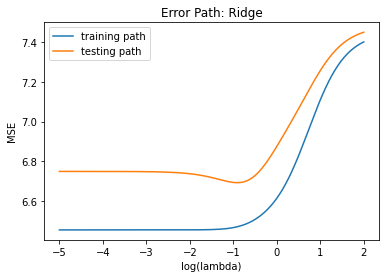

In [10]:
# Change the y-axis to show the actual log10s of the lambdas

plt.plot([x for x in np.linspace(interval_start, interval_end, num=l2_intervals)],train_path,label='training path')
plt.plot([x for x in np.linspace(interval_start, interval_end, num=l2_intervals)],test_path,label='testing path')
plt.legend()
plt.xlabel('log(lambda)')
plt.ylabel('MSE')
plt.title('Error Path: Ridge')


In [11]:
min(test_path)

[6.691778253854419]

Text(0.5, 1.0, 'Parameter path: Ridge')

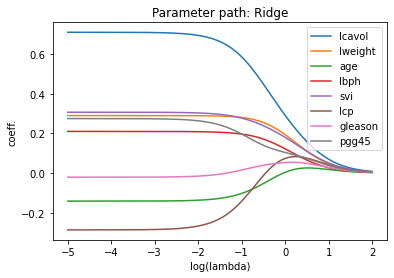

In [12]:
data_labels = ['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']

weight_path = np.array(weight_path)
for w in range(weight_path.shape[1]):
    plt.plot([x for x in np.linspace(interval_start, interval_end, num=l2_intervals)],weight_path[:,w],label = data_labels[w])
plt.legend()
plt.xlabel('log(lambda)')
plt.ylabel('coeff.')
plt.title('Parameter path: Ridge')
